In [1]:
%run supervised_functions.ipynb

Calculating probability for start mol sampling


100%|█████████████████████████████████████████████████████████| 66546/66546 [01:27<00:00, 764.64it/s]


In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

### Action dataset

In [3]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rsig_cs_indices", "psub", "pcen", "psig", "psig_cs_indices"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(84968, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de

# Get top k predictions

In [4]:
import time
def get_topk_predictions(model, source_list, target_list, topk=10):
    # Convert to mols
    if isinstance(source_list, pd.Series):
        source_list = source_list.tolist()
    if isinstance(target_list, pd.Series):
        target_list = target_list.tolist()
    tt = time.time()
    sources = data.Molecule.pack(list(map(molecule_from_smile, source_list)))
    targets = data.Molecule.pack(list(map(molecule_from_smile, target_list)))
    print(f"Took {time.time() - tt}s to pack molecules.")

    # Predictions
    batch_size = 1024
#     pred = model(sources, targets, None, None, "actor").detach()
    pred = torch.concatenate([model(sources[i:min(i+batch_size, sources.batch_size)].to(device), 
                                 targets[i:min(i+batch_size, sources.batch_size)].to(device), None, None, "actor").detach() for i in range(0, sources.batch_size, batch_size)], axis=0)

    action_embeddings = get_action_dataset_embeddings(model.GIN)

    # Get applicable actions for source(s)
    applicable_action_indices_list = []
    
    with Pool(30) as p:
        for idxes in tqdm.tqdm(p.imap(functools.partial(get_emb_indices_and_correct_idx, no_correct_idx=True), 
                                      [{"reactant": source_list[i]} for i in range(pred.shape[0])], chunksize=10),
                              total=pred.shape[0]):
            applicable_action_indices_list.append(idxes)

    # Sort by critic's Q
    dict_of_list_of_indices = {}
    
    for i in tqdm.tqdm(range(pred.shape[0])):
        pred_for_i = pred[i]
        adi = applicable_action_indices_list[i]
        if len(adi) == 0:
            dict_of_list_of_indices[i] = np.array([])
            continue

        # Get top 50 for actor
        dist = torch.linalg.norm(action_embeddings[adi] - pred[i], axis=1)
        dict_of_list_of_indices[i] = adi[torch.argsort(dist)[:50].cpu().numpy().astype(np.int64)]

    # Sort with critic's Q
    i_sorted = list(range(pred.shape[0]))
    action_indices = np.concatenate([dict_of_list_of_indices[i] for i in i_sorted])
    state_indices = np.concatenate([np.full_like(dict_of_list_of_indices[i], i) for i in i_sorted])
    critic_qs = []
    for i in tqdm.tqdm(range(0, action_indices.shape[0], batch_size)):
        batch_reactants = sources[state_indices[i:i+batch_size]]
        batch_products = targets[state_indices[i:i+batch_size]]
        batch_rsigs = action_rsigs[action_indices[i:i+batch_size]]
        batch_psigs = action_psigs[action_indices[i:i+batch_size]]
        critic_qs.append(ac(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic").detach().cpu().numpy())

    critic_qs = np.concatenate(critic_qs)

    # Get action predictions
    action_pred_indices = []
    start = 0
    for i in tqdm.tqdm(i_sorted):
        end = start + dict_of_list_of_indices[i].shape[0]
        i_critic_qs = critic_qs[start:end]

        action_pred_indices.append(dict_of_list_of_indices[i][i_critic_qs.reshape(-1).argsort()[::-1]][:topk])
        start = end

    return action_pred_indices
    
# %time pred = get_topk_predictions(ac, source_list[:100], target_list[target_list_idx][:100])
# print(len(pred))

In [5]:
def _generate_train_data(smile, steps):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
#                 break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product), i]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product', 'step'])
    
    # Fix index
    df.index = index
    
    # Fix target
    df["product"] = Chem.MolToSmiles(product)

    # Fix step
    df['step'] = df.shape[0] - df['step']
    
    return df

def generate_train_data(N, steps, multiprocess=True):
    # Generate dataset
    df_list = []
    final_shape = 0
    smiles_per_random_sample = 300
    pool_chunk_size = 10

    # Create dataset for multi-step pred
    print("Creating dataset...")
    if multiprocess:
        with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
            while final_shape < N:
                smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,), p=categorical_probs_for_sampling_start_mols)

                for new_df in p.imap_unordered(functools.partial(_generate_train_data, steps=steps), smiles, chunksize=10):
                    df_list.append(new_df)
                    final_shape += new_df.shape[0]

                pbar.update(final_shape - pbar.n)
    else:
        raise Exception("Single process not implemented... :'(")

    main_df = pd.concat(df_list)
    return main_df

In [6]:
def apply_actions_on_reactant(args):
    reactant, action_dataset_idx = args
    listy = []
    for idx in action_dataset_idx:
        try:
            listy.append(Chem.MolToSmiles(apply_action(Chem.MolFromSmiles(reactant), *action_dataset.iloc[idx])))
        except Exception as e:
            pass
    return listy

In [13]:
def get_similarity_from_smiles(s1, s2):
    return similarity(Chem.MolFromSmiles(s1), Chem.MolFromSmiles(s2))

### Generate data

In [17]:
# Get test data
test_data_df = generate_train_data(N=10000, steps=5) # we'll get N/step trajectory samples from this
test_data_df.shape

Creating dataset...


11095it [00:41, 267.98it/s]                                                                          


(11095, 11)

In [18]:
temp_df = test_data_df[test_data_df['step'] == 5]

In [19]:
source_list, target_list = temp_df["reactant"].values, temp_df["product"].values
# del temp_df
source_list.shape, target_list.shape

((2219,), (2219,))

### Load model

In [20]:
# Load model
import glob
# file_string = f"models/supervised/actor-critic/*{actor_loss}*steps={steps}*/model.pth"
file_string = f"models/supervised/actor-critic/steps=5||actor_loss=PG||negative_selection=random/model.pth"
ac = torch.load(glob.glob(file_string)[0]).to(device)

### Predictions (trajectories)

In [21]:
target_list_idx = np.arange(target_list.shape[0])
sim_dict = {}
trajectory_dict = {str(i): source_list[i] for i in range(len(source_list))} # Keeps track of trajectory in dict format (need hash keeys for quick access)
source_keys = list(map(str, np.arange(len(source_list)))) # Map for index to keys of previous step in trajectory

# RUN -----------------------
for i_step in range(1, 8): 
    print("Running prediction for step", i_step)
    # Get action predictions
    pred = get_topk_predictions(ac, source_list, target_list[target_list_idx], topk=10)

    # get products
    temp_source_keys = []
    temp_source_list = []
    with Pool(30) as p:
        print("Applying actions for step", i_step)
        for i, product_list in tqdm.tqdm(enumerate(p.imap(apply_actions_on_reactant, zip(source_list, pred), chunksize=10)), total=len(pred)):
            for _i, product in enumerate(product_list):
                key = f"{source_keys[i]}_{_i}"
                trajectory_dict[key] = product
                sim_dict[key] = get_similarity_from_smiles(product, target_list[int(key.split("_")[0])])
                temp_source_keys.append(key)
                temp_source_list.append(product)

    print("Getting top some sim products for each s-t pair")
    temp_source_keys = np.array(temp_source_keys)
    temp_source_list = np.array(temp_source_list)
    temp_source_sim = np.vectorize(sim_dict.get)(temp_source_keys)
    temp_source_argsort = np.argsort(temp_source_sim)
    temp_source_st_idx = np.array(list(map(lambda x: int(x.split("_")[0]), temp_source_keys)))
    temp_source_indices = []
    for t_i in range(target_list.shape[0]):
        temp_source_indices.append((temp_source_argsort[temp_source_st_idx == t_i])[:100])

    temp_source_indices = np.concatenate(temp_source_indices)

    # update source list and source_keys for next step
    source_keys = temp_source_keys[temp_source_indices]
    source_list = temp_source_list[temp_source_indices]
    target_list_idx = list(map(lambda x: int(x.split("_")[0]), source_keys))

Running prediction for step 1
Took 7.437994718551636s to pack molecules.


100%|████████████████████████████████████████████████████████| 2219/2219 [00:00<00:00, 112687.04it/s]


Applying actions for step 1


100%|███████████████████████████████████████████████████████████| 2219/2219 [00:22<00:00, 100.77it/s]


Getting top some sim products for each s-t pair
Running prediction for step 2
Took 84.1964704990387s to pack molecules.


100%|██████████████████████████████████████████████████████| 22185/22185 [00:00<00:00, 142029.51it/s]


Applying actions for step 2


100%|██████████████████████████████████████████████████████████| 22185/22185 [03:44<00:00, 98.72it/s]


Getting top some sim products for each s-t pair
Running prediction for step 3
Took 854.92138504982s to pack molecules.


100%|████████████████████████████████████████████████████| 210672/210672 [00:00<00:00, 221648.79it/s]


Applying actions for step 3


100%|████████████████████████████████████████████████████████| 210672/210672 [37:09<00:00, 94.50it/s]


Getting top some sim products for each s-t pair
Running prediction for step 4
Took 821.7789914608002s to pack molecules.


100%|████████████████████████████████████████████████████| 221683/221683 [00:01<00:00, 193997.77it/s]


Applying actions for step 4


100%|███████████████████████████████████████████████████████| 221683/221683 [34:56<00:00, 105.73it/s]


Getting top some sim products for each s-t pair
Running prediction for step 5
Took 486.9350049495697s to pack molecules.


100%|████████████████████████████████████████████████████| 133371/133371 [00:00<00:00, 198304.49it/s]


Applying actions for step 5


100%|███████████████████████████████████████████████████████| 133371/133371 [20:29<00:00, 108.50it/s]


Getting top some sim products for each s-t pair
Running prediction for step 6
Took 314.55871748924255s to pack molecules.


100%|██████████████████████████████████████████████████████| 87927/87927 [00:00<00:00, 180168.45it/s]


Applying actions for step 6


100%|█████████████████████████████████████████████████████████| 87927/87927 [13:18<00:00, 110.18it/s]


Getting top some sim products for each s-t pair
Running prediction for step 7
Took 206.3521842956543s to pack molecules.


100%|██████████████████████████████████████████████████████| 56559/56559 [00:00<00:00, 168226.28it/s]


Applying actions for step 7


100%|█████████████████████████████████████████████████████████| 56559/56559 [08:53<00:00, 105.92it/s]


Getting top some sim products for each s-t pair


target_list_idx = np.arange(target_list.shape[0])

# initialize objects
trajectory_dict = {} # Keeps track of trajectory in dict format (need hash keeys for quick access)
for i in range(len(source_list)):
    trajectory_dict[str(i)] = source_list[i]
source_keys = list(map(str, list(range(len(source_list))))) # Map for index to keys of previous step in trajectory

# RUN -----------------------
for i_step in range(1, 7): 
    print("Running prediction for step", i_step)
    # Get action predictions
    %time pred = get_topk_predictions(ac, source_list, target_list[target_list_idx])

    # get products
    temp_source_keys = []
    temp_source_list = []
    with Pool(30) as p:
        print("Applying actions for step", i_step)
        for i, product_list in tqdm.tqdm(enumerate(p.imap(apply_actions_on_reactant, zip(source_list, pred), chunksize=10)), total=len(pred)):
            for _i, product in enumerate(product_list):
                key = f"{source_keys[i]}_{_i}"
                trajectory_dict[key] = product
                temp_source_keys.append(key)
                temp_source_list.append(product)
                
    # update source list and source_keys for next step
    source_list = temp_source_list
    source_keys = temp_source_keys
    target_list_idx = list(map(lambda x: int(x.split("_")[0]), source_keys))

# Analysis

In [35]:
np.vectorize(trajectory_dict.get)(['1', '2', '3'])

array(['CC(=O)Nc1ccccc1F', 'CCOC(=O)C(Nc1ccc(C#N)cc1)c1cc(C)cc(N)c1',
       'CCC(CC)Oc1cc(C=CC(=O)O)cc(OC(CC)CC)c1O'], dtype='<U39')

In [37]:
all_keys = np.array(list(trajectory_dict.keys()))

def t_map(x):
    return x.split("_")[0]
%time target_map_for_all_keys = np.vectorize(t_map)(all_keys)

sim_dict = {}

def my_convenient_similarity_fn(s1, m2):
    return similarity(Chem.MolFromSmiles(s1), m2)

with Pool(30) as p:
    for i in tqdm.tqdm(range(target_list.shape[0])):
        target_mol = Chem.MolFromSmiles(target_list[i])
        
        # Get for others
        key_for_i = all_keys[target_map_for_all_keys == str(i)]
        for _i, sim in enumerate(p.imap(functools.partial(my_convenient_similarity_fn, m2=target_mol), np.vectorize(trajectory_dict.get)(key_for_i), chunksize=10)):
            sim_dict[key_for_i[_i]] = sim

CPU times: user 3.06 s, sys: 398 ms, total: 3.45 s
Wall time: 3.45 s


100%|████████████████████████████████████████████████████████████| 2219/2219 [23:16<00:00,  1.59it/s]


######################################################################################################################################################
241
source


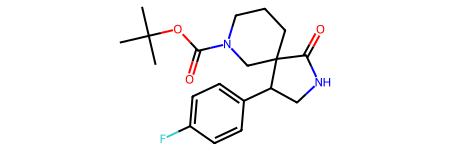

target


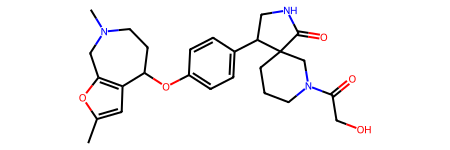

sim = 1: 1 | sim >= 0.9: 3 | sim >= 0.8: 29
--------------------------------------------------
Steps for highest sim = 1.00
Sim = 0.44


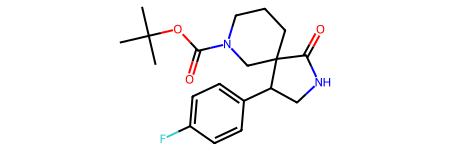

Sim = 0.79


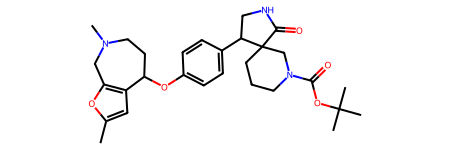

Sim = 1.00


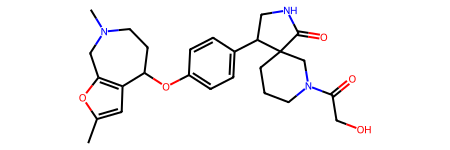

######################################################################################################################################################
230
source


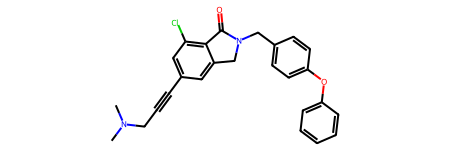

target


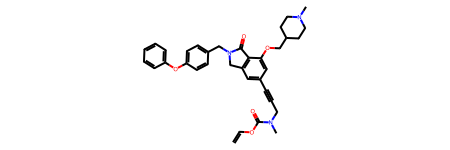

sim = 1: 0 | sim >= 0.9: 0 | sim >= 0.8: 3
--------------------------------------------------
Steps for highest sim = 0.82
Sim = 0.59


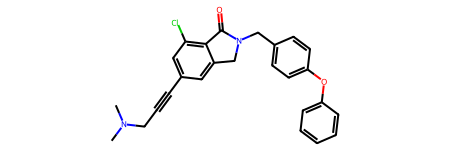

Sim = 0.59


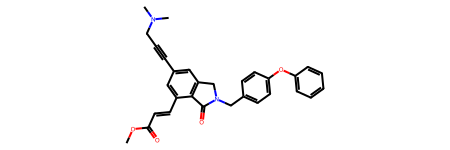

Sim = 0.73


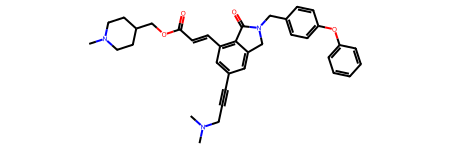

Sim = 0.82


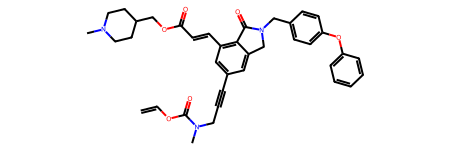

######################################################################################################################################################
878
source


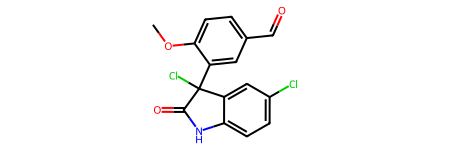

target


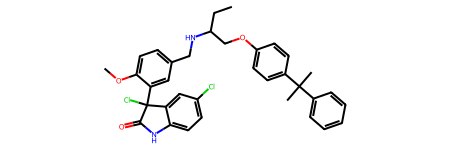

sim = 1: 0 | sim >= 0.9: 0 | sim >= 0.8: 0
--------------------------------------------------
Steps for highest sim = 0.61
Sim = 0.41


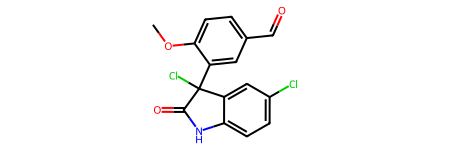

Sim = 0.48


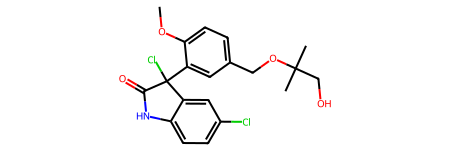

Sim = 0.40


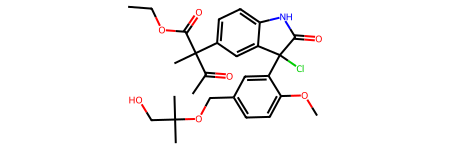

Sim = 0.61


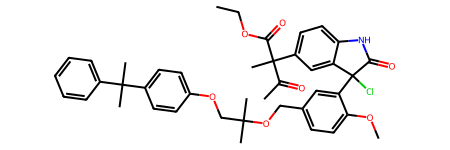

######################################################################################################################################################
407
source


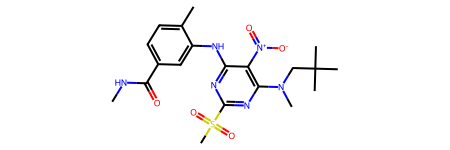

target


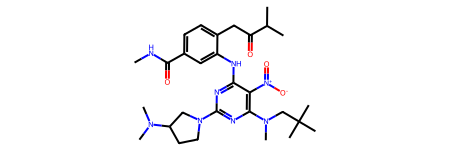

sim = 1: 2 | sim >= 0.9: 3 | sim >= 0.8: 14
--------------------------------------------------
Steps for highest sim = 1.00
Sim = 0.54


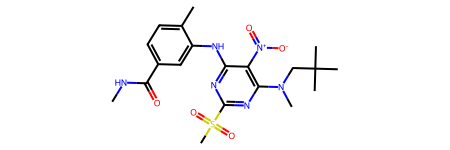

Sim = 0.70


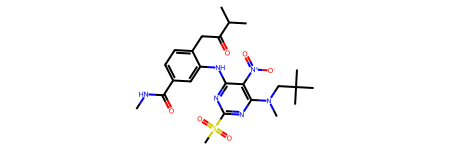

Sim = 1.00


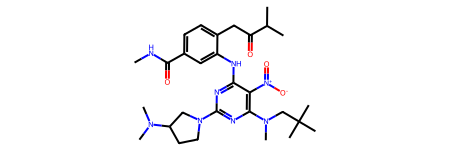

######################################################################################################################################################
92
source


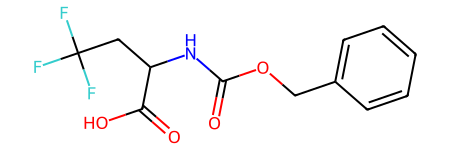

target


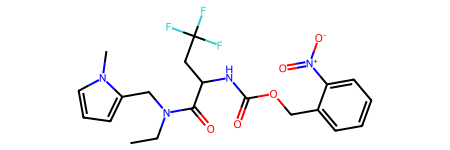

sim = 1: 0 | sim >= 0.9: 0 | sim >= 0.8: 0
--------------------------------------------------
Steps for highest sim = 0.74
Sim = 0.44


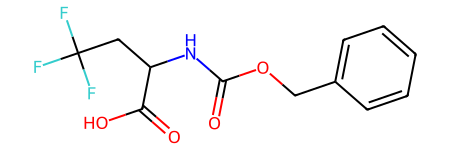

Sim = 0.57


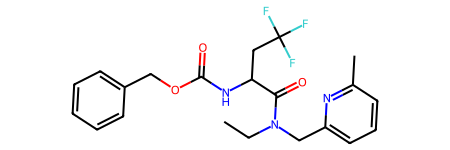

Sim = 0.56


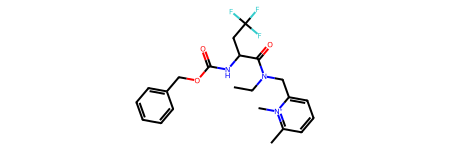

Sim = 0.74


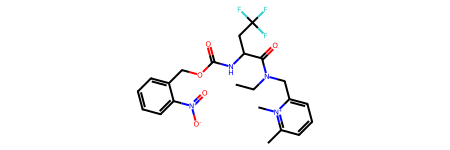

In [39]:
rand_idx = np.random.randint(0, 1000, (5,))

for r in rand_idx:
    print("#"*150)
    print(r)
    print("source")
    display(Chem.MolFromSmiles(trajectory_dict[str(r)]))
    print("target")
    display(Chem.MolFromSmiles(target_list[r]))
    
    keys_for_r = np.array(list(filter(lambda x: x.startswith(str(r)+'_'), all_keys)))
    sim_for_r = np.vectorize(sim_dict.get)(keys_for_r)
    
    print(f"sim = 1: {(sim_for_r == 1).sum()} | sim >= 0.9: {(sim_for_r >= 0.9).sum()} | sim >= 0.8: {(sim_for_r >= 0.8).sum()}")
    
    print("-"*50)
    print(f"Steps for highest sim = {sim_for_r.max():.2f}")
    key = keys_for_r[(sim_for_r == sim_for_r.max())][0]
    
    traj_idxes = key.split('_')
    for i in range(1, len(traj_idxes)+1):
        key = "_".join(traj_idxes[:i])
        print(f"Sim = {sim_dict[key]:.2f}")
        display(Chem.MolFromSmiles(trajectory_dict[key]))

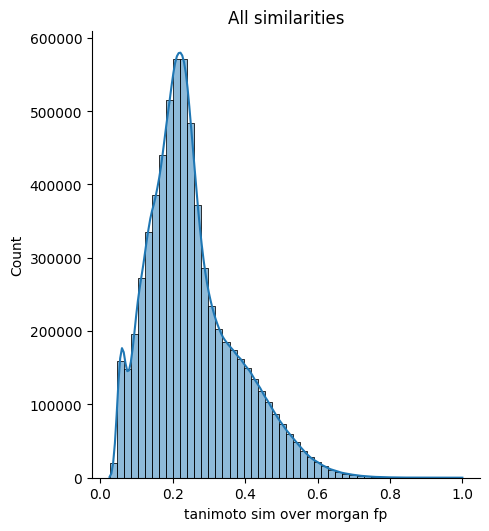

In [38]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

sim_vals = np.array(list(sim_dict.values()))
sns.displot(sim_vals, kde=True, bins=50)
plt.title("All similarities")
plt.xlabel("tanimoto sim over morgan fp")
plt.show()

In [39]:
best_sim_list = []
step_for_best_sim_list = []

for i in tqdm.tqdm(range(len(target_list))):
    keys_for_i = all_keys[target_map_for_all_keys == str(i)]
    sim_list_for_i = np.vectorize(sim_dict.get)(keys_for_i)
    
    best_arg = sim_list_for_i.argmax()
    best_sim_list.append(sim_list_for_i[best_arg])
    step_for_best_sim_list.append(len(keys_for_i[best_arg].split("_"))-1)

best_sim_list = np.array(best_sim_list)
step_for_best_sim_list = np.array(step_for_best_sim_list)
print(f"Average best sim = {np.mean(best_sim_list)}")
print(f"% correct paths predicted = {(best_sim_list==1).sum()/best_sim_list.shape[0]*100}")
print(f"Average path length for best sim = {np.mean(step_for_best_sim_list)}")

100%|████████████████████████████████████████████████████████████| 2219/2219 [01:59<00:00, 18.59it/s]

Average best sim = 0.6496280867138764
% correct paths predicted = 1.1266336187471835
Average path length for best sim = 3.015322217214962


Help on function qed in module rewards.properties:

qed(mol)



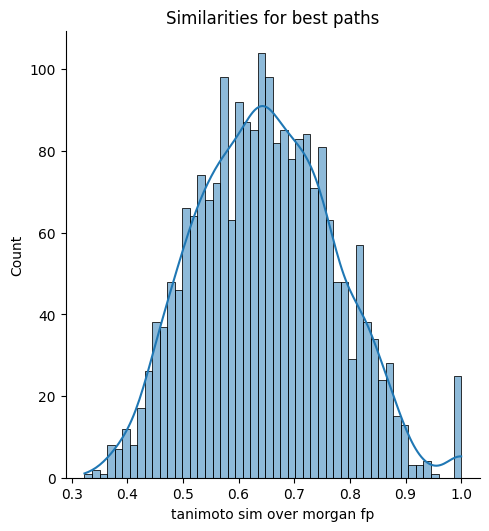

In [40]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

sns.displot(best_sim_list, kde=True, bins=50)
plt.title("Similarities for best paths")
plt.xlabel("tanimoto sim over morgan fp")
plt.show()

/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  


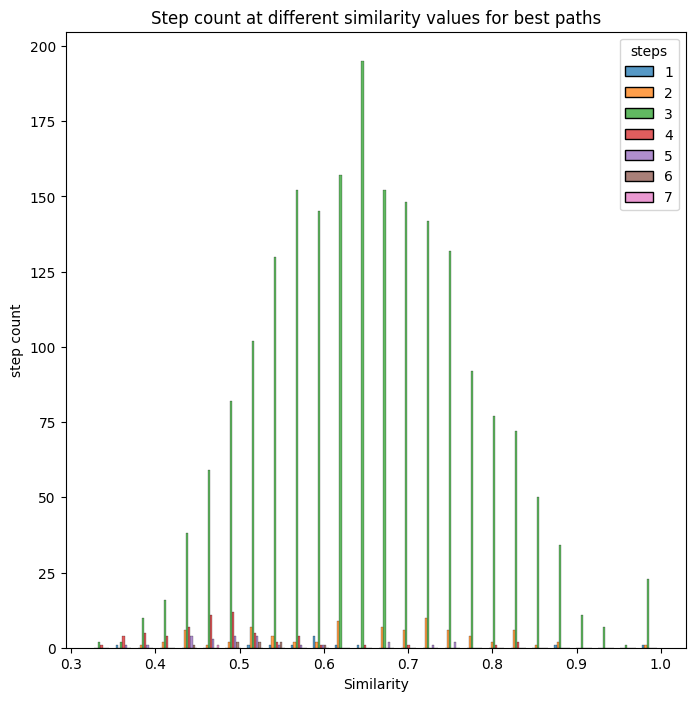

In [41]:
plt.figure(figsize=(8, 8))
sns.histplot(pd.DataFrame({"steps": step_for_best_sim_list, "sim": best_sim_list}), x="sim", hue='steps', multiple='dodge', shrink=0.7, palette=sns.color_palette())
plt.ylabel("step count")
plt.xlabel("Similarity")
plt.title("Step count at different similarity values for best paths")
plt.show()

In [45]:
# Paths with sim=1
pd.value_counts(step_for_best_sim_list[best_sim_list==1])

3    23
2     1
1     1
dtype: int64

# Drawing

In [121]:
from rdkit.Chem import AllChem, Draw
from reaction_centre_and_signature import Reaction
mts = Chem.MolToSmiles
mfs = Chem.MolFromSmiles


sim1_indices = np.where(best_sim_list==1)[0]

In [48]:
sim1_indices

(array([  82,  132,  293,  338,  381,  802,  868,  897, 1053, 1066, 1067,
        1086, 1090, 1189, 1230, 1251, 1267, 1279, 1303, 1586, 1672, 1747,
        1813, 1989, 2028]),)

82



##############################################################################################################################################################################################
##############################################################################################################################################################################################


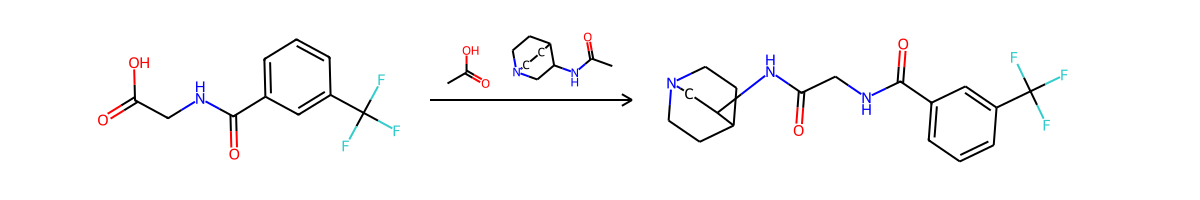

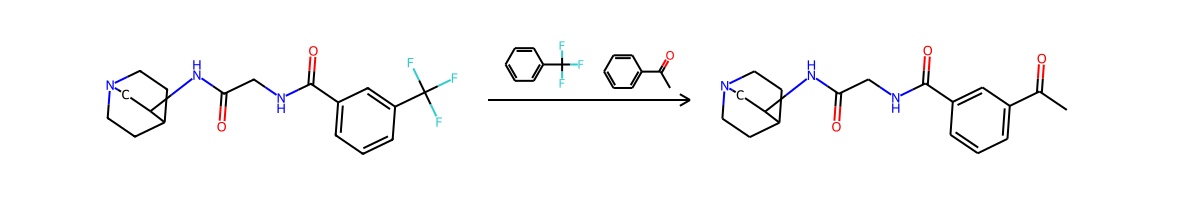

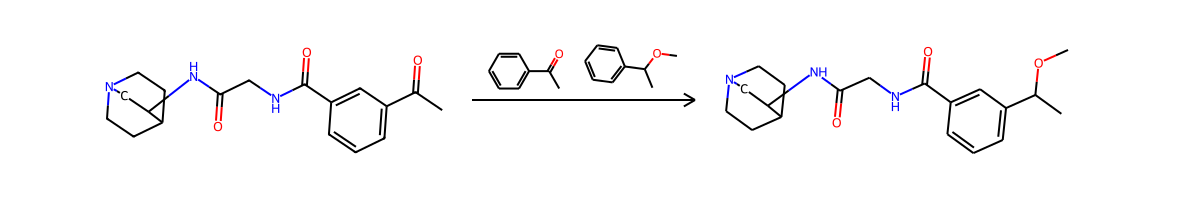

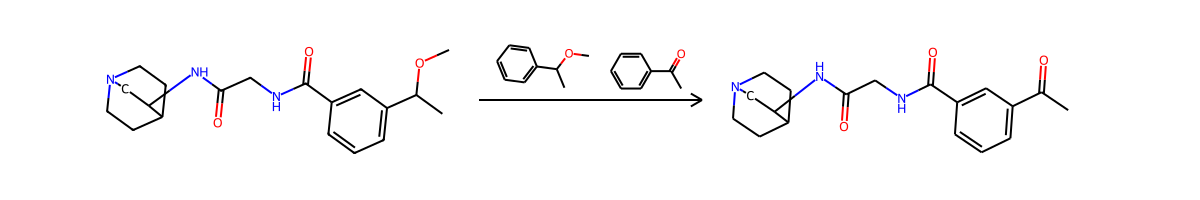

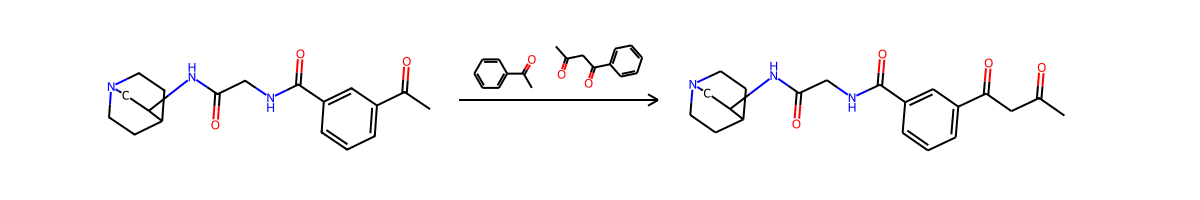

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
82_2_0_0


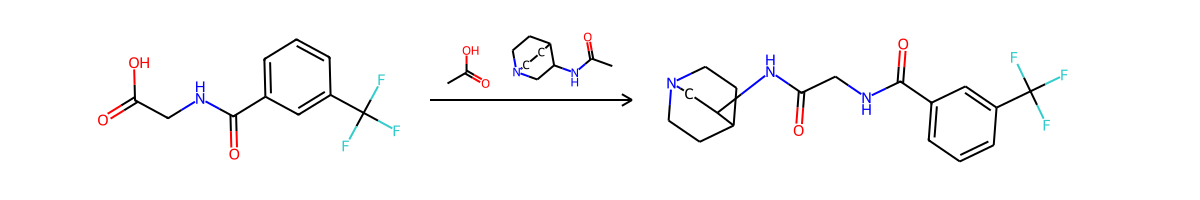

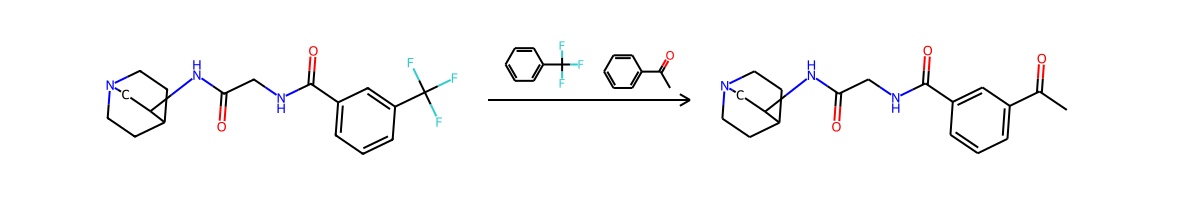

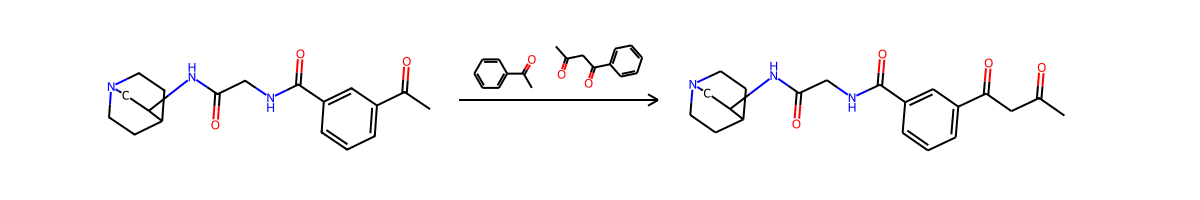

##############################################################################################################################################################################################
##############################################################################################################################################################################################
132



##############################################################################################################################################################################################
##############################################################################################################################################################################################


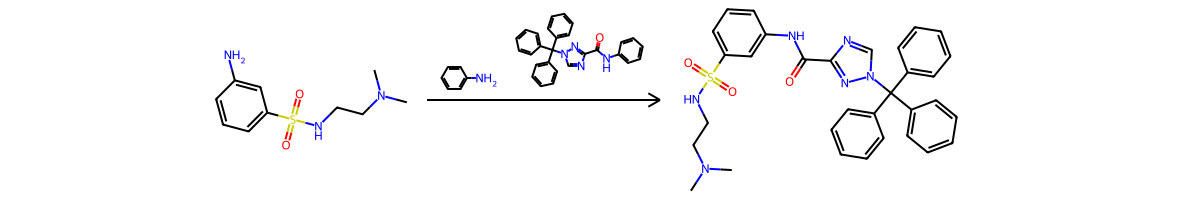

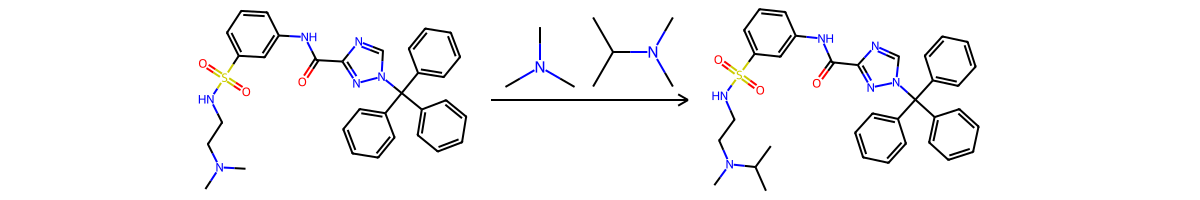

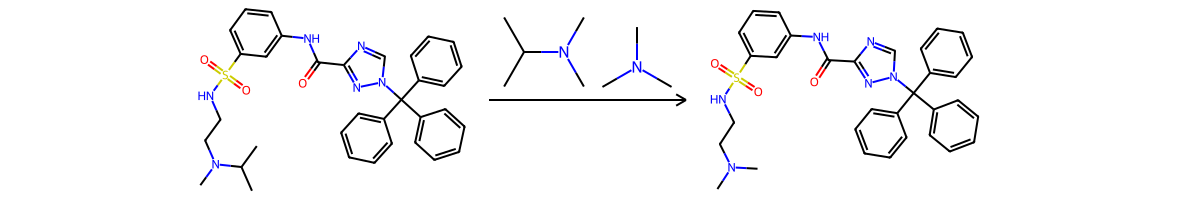

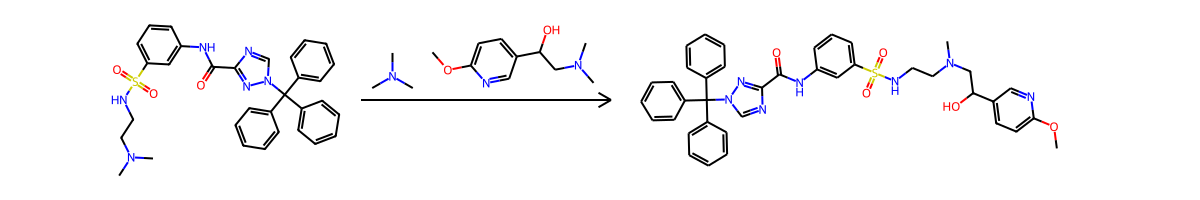

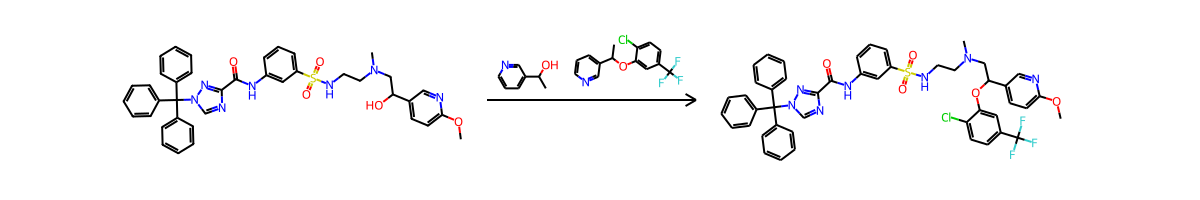

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
132_0_0_1


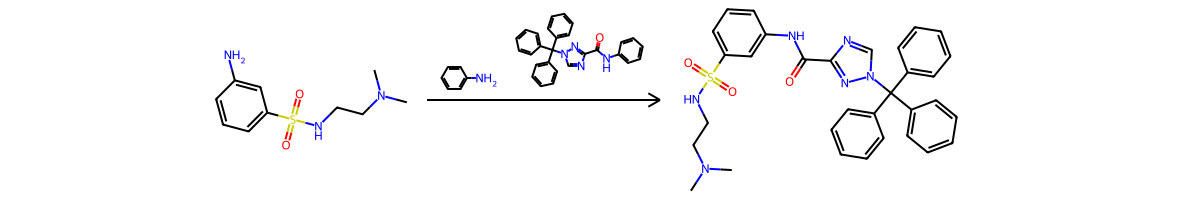

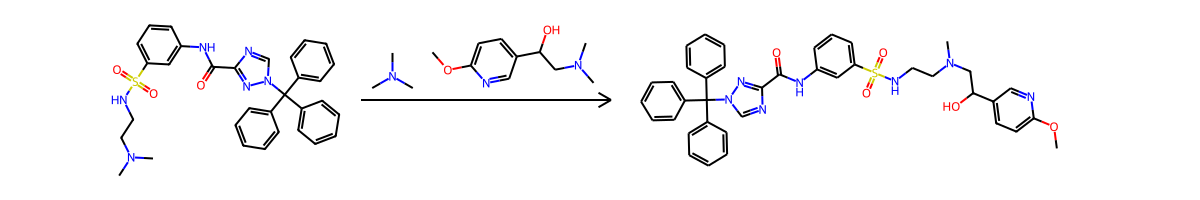

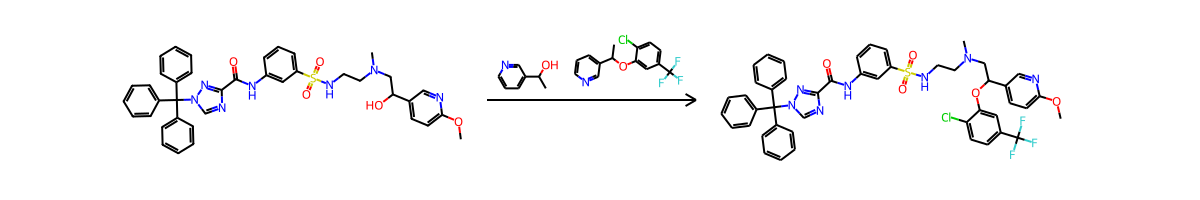

##############################################################################################################################################################################################
##############################################################################################################################################################################################
293



##############################################################################################################################################################################################
##############################################################################################################################################################################################


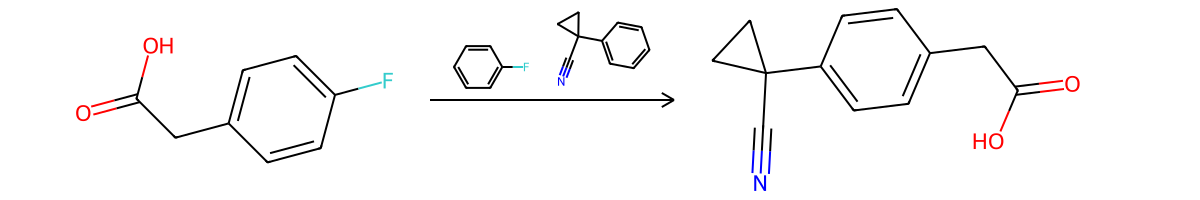

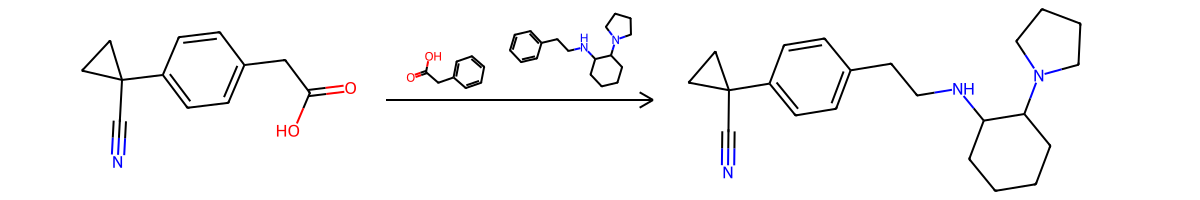

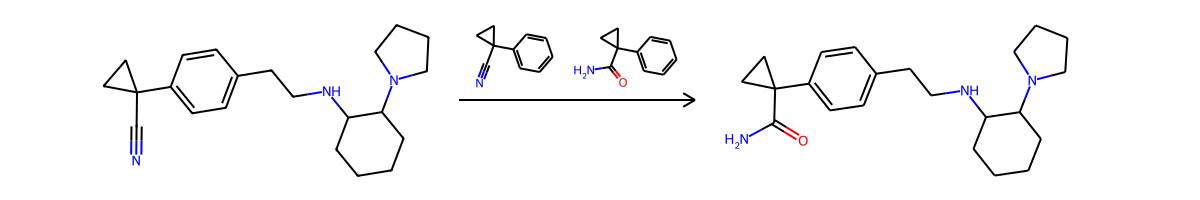

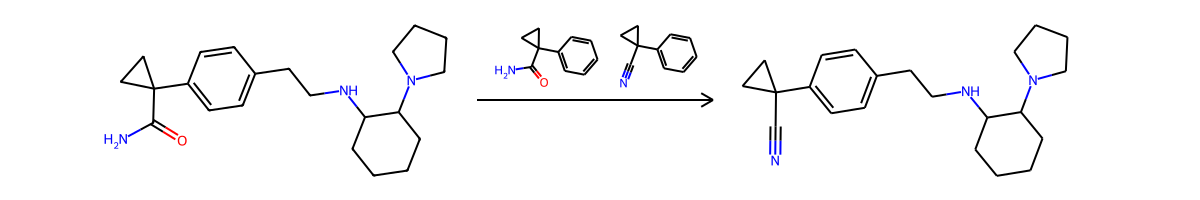

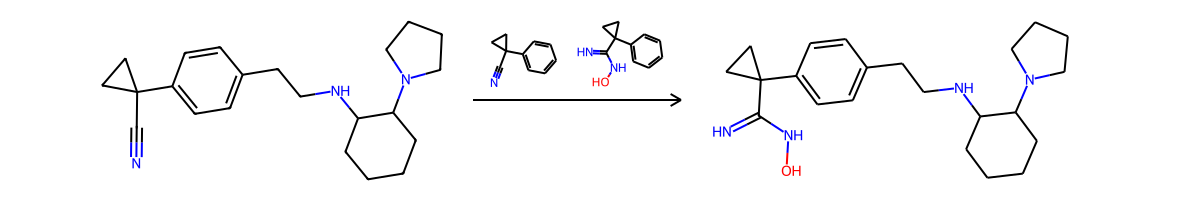

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
293_0_3_0


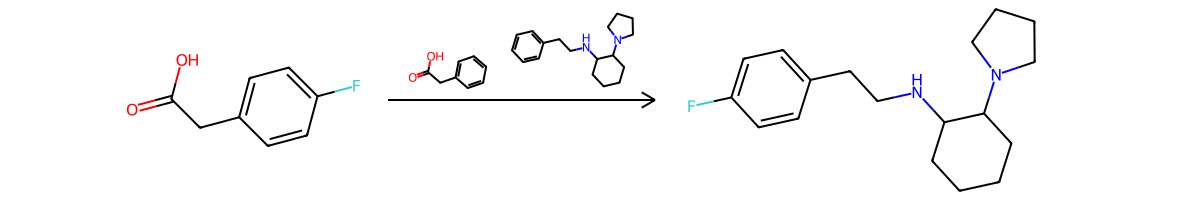

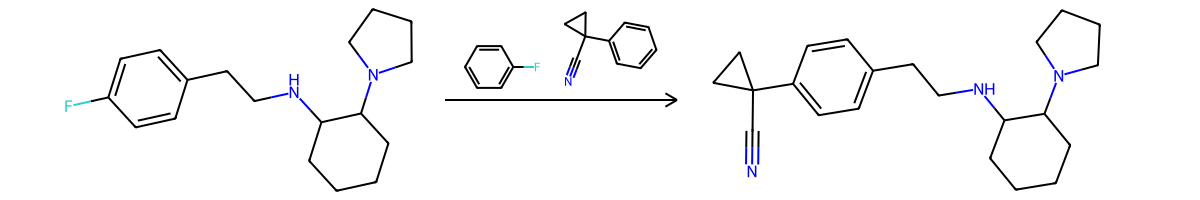

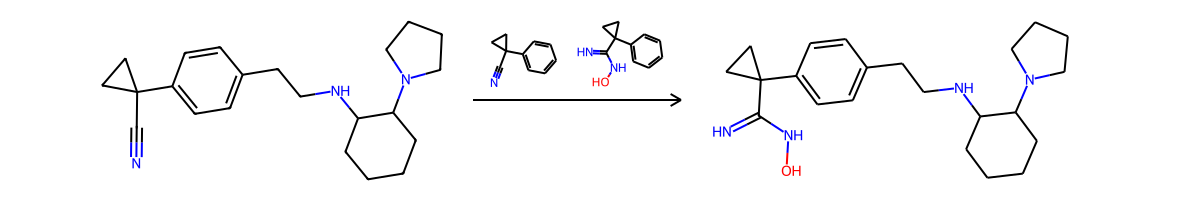

##############################################################################################################################################################################################
##############################################################################################################################################################################################
338



##############################################################################################################################################################################################
##############################################################################################################################################################################################


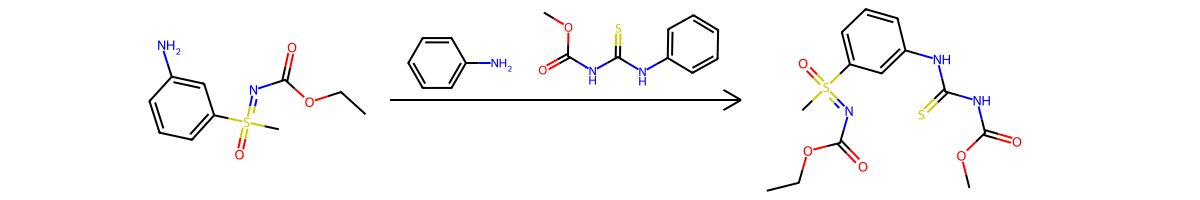

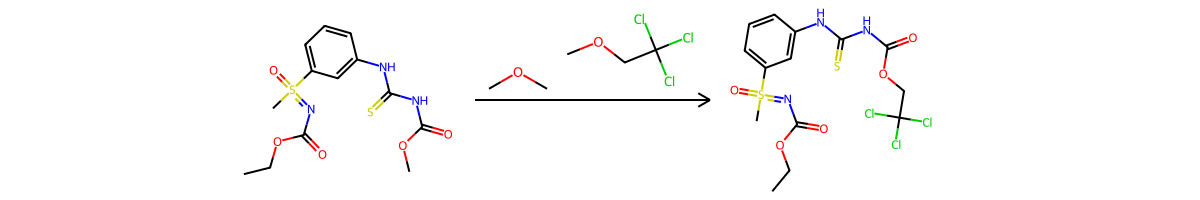

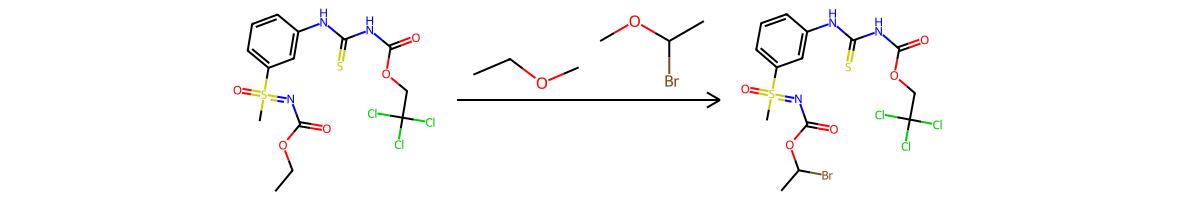

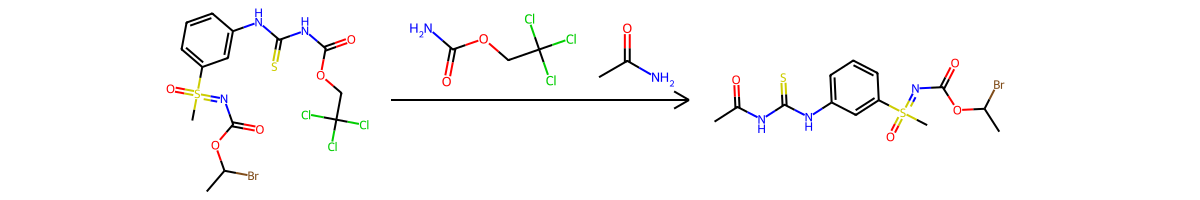

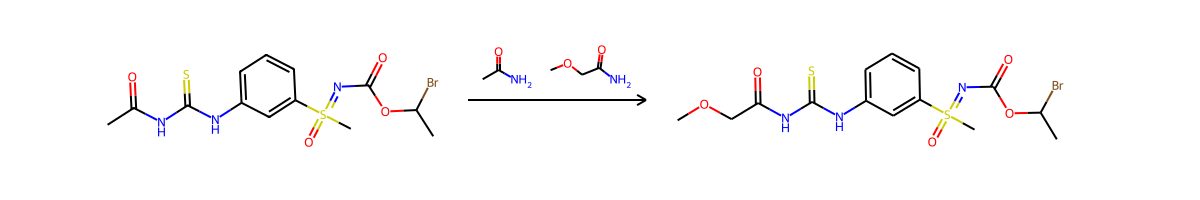

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
338_0_1_0


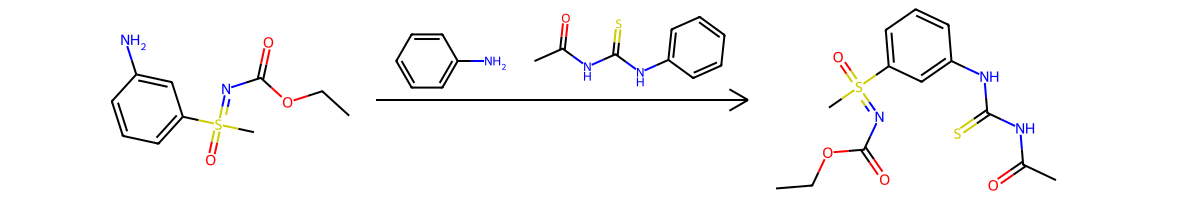

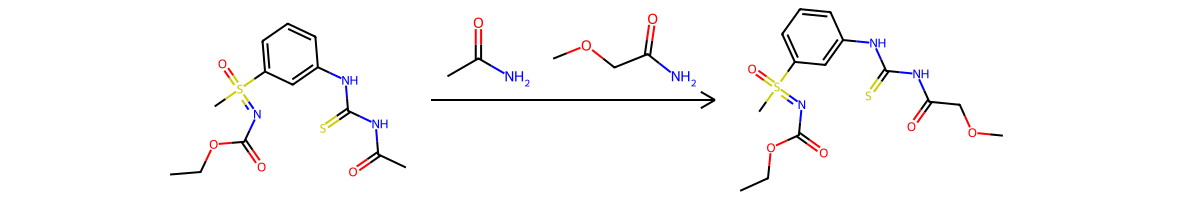

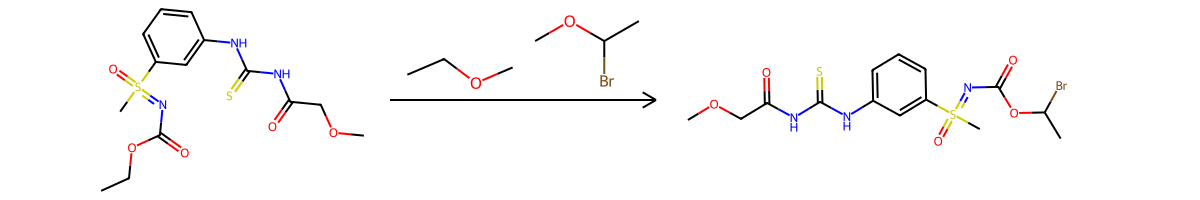

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
338_0_5_1


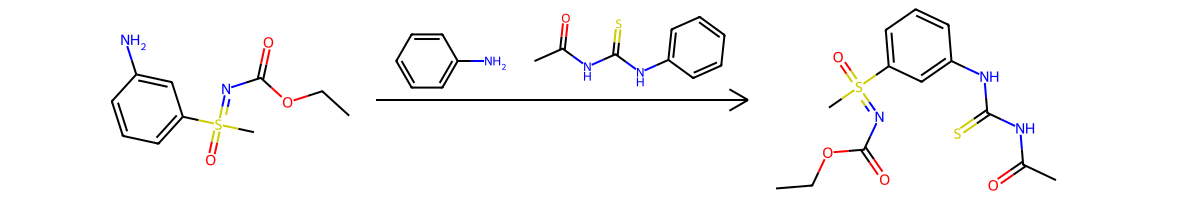

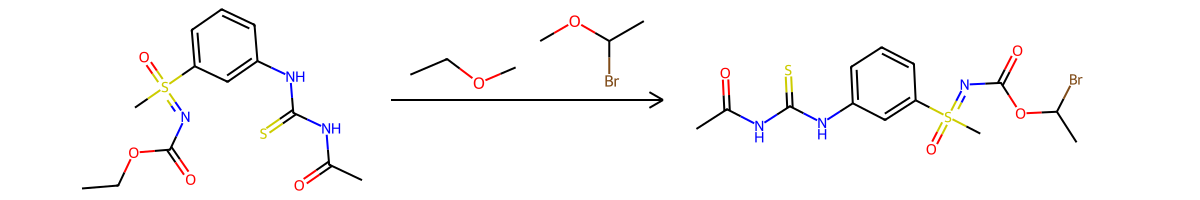

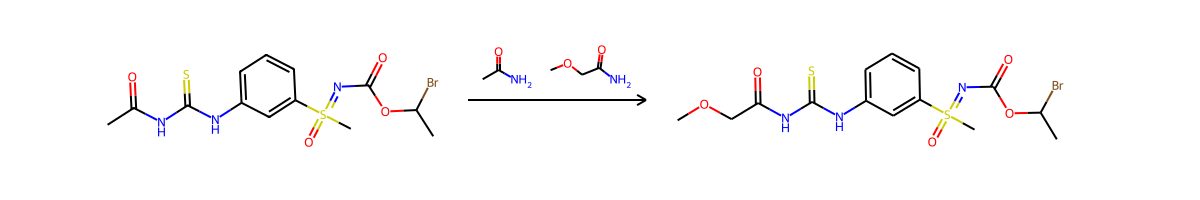

##############################################################################################################################################################################################
##############################################################################################################################################################################################
381



##############################################################################################################################################################################################
##############################################################################################################################################################################################


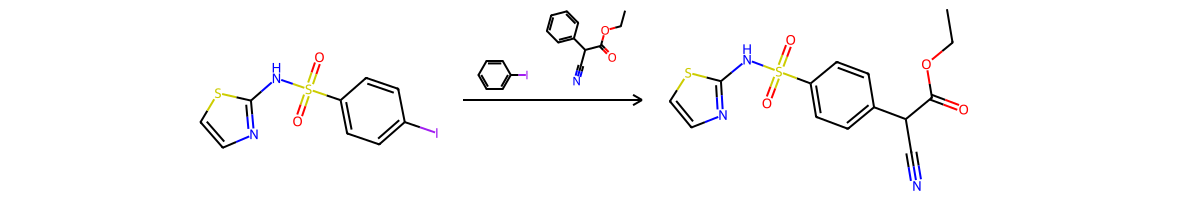

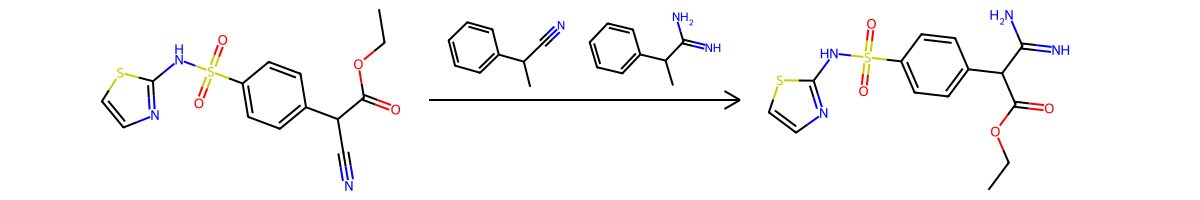

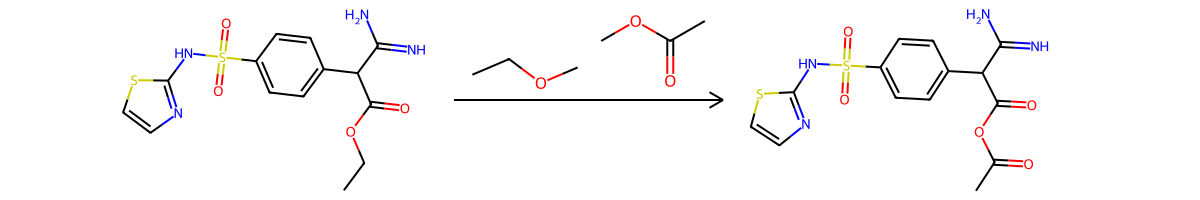

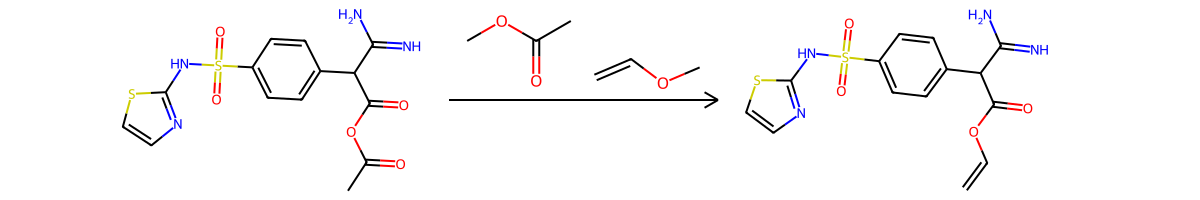

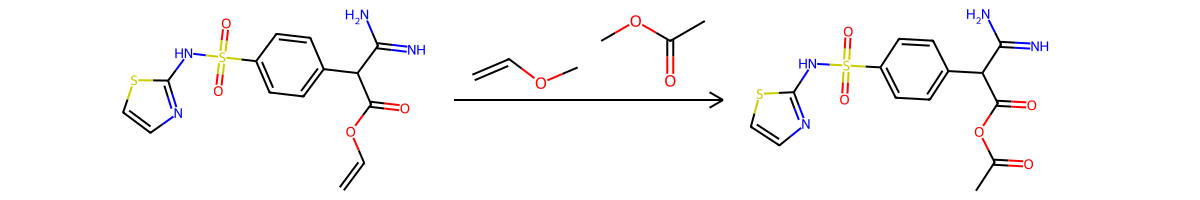

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
381_1_1_0


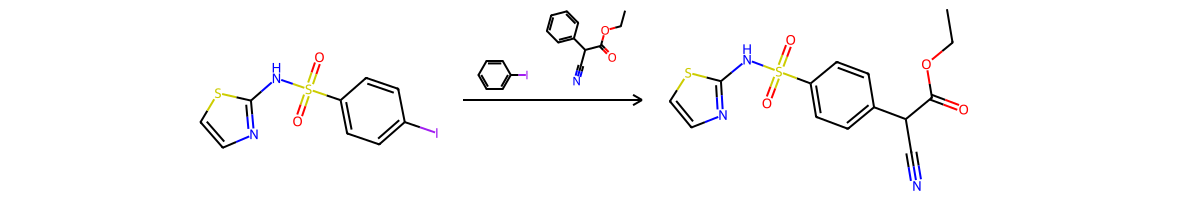

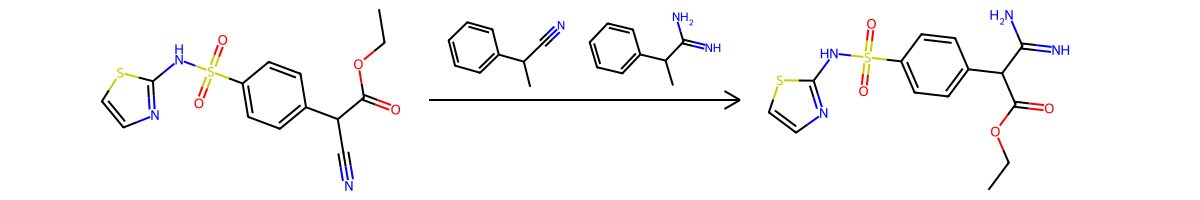

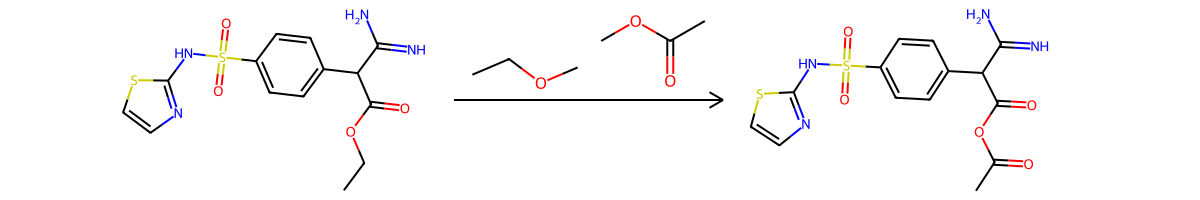

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
381_1_0_0


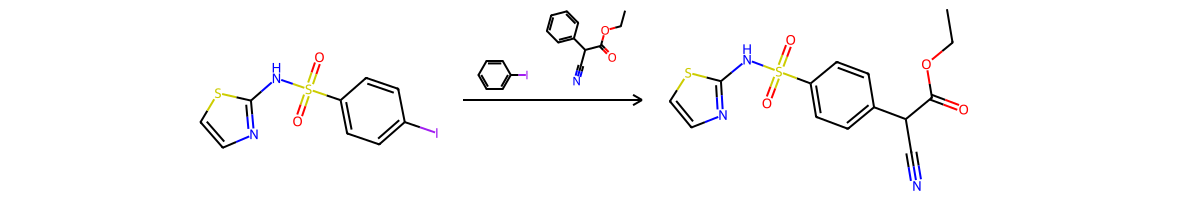

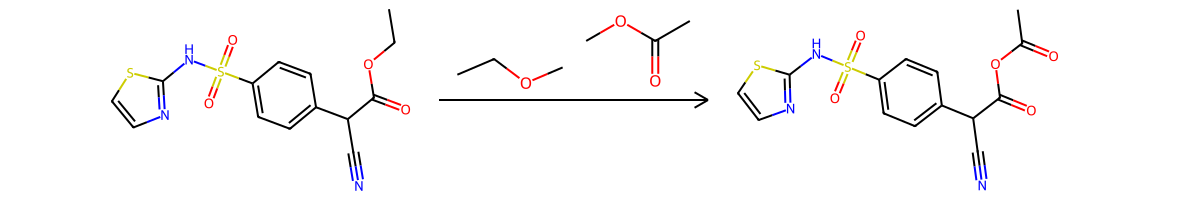

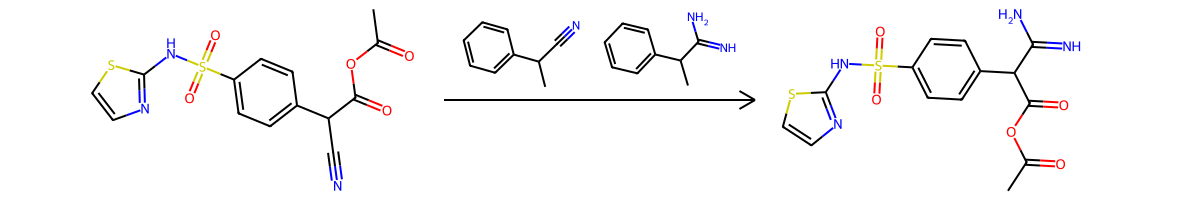

##############################################################################################################################################################################################
##############################################################################################################################################################################################
802



##############################################################################################################################################################################################
##############################################################################################################################################################################################


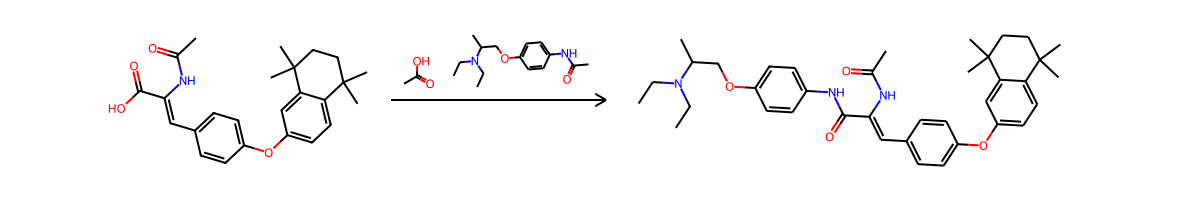

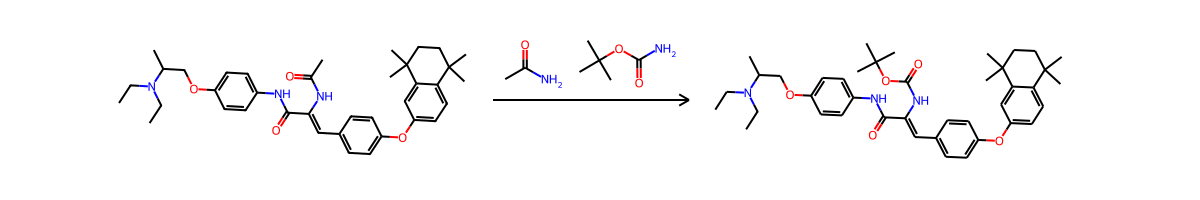

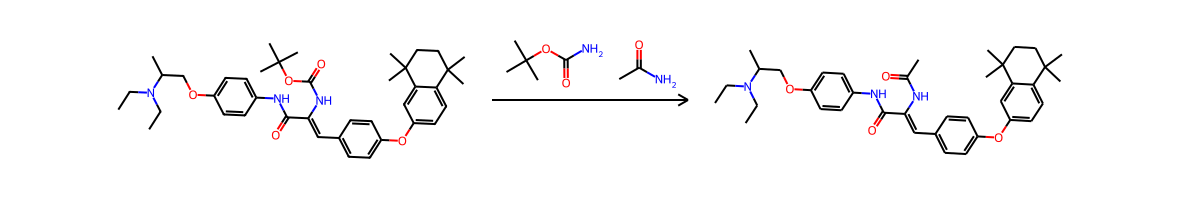

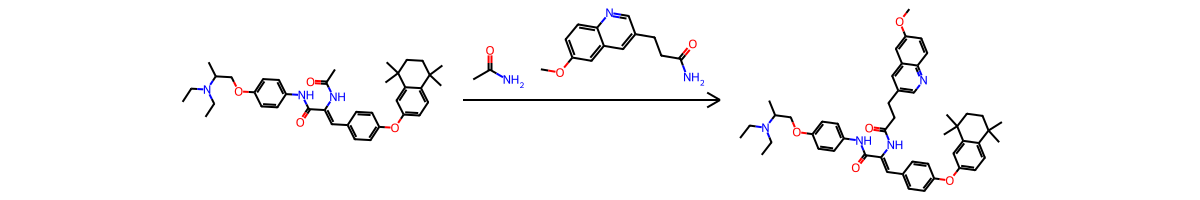

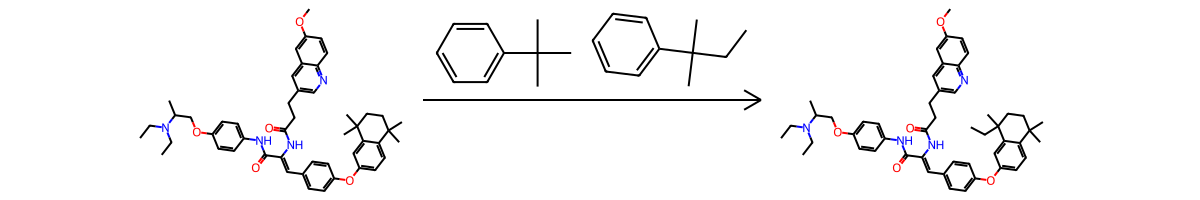

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
802_5_1_1


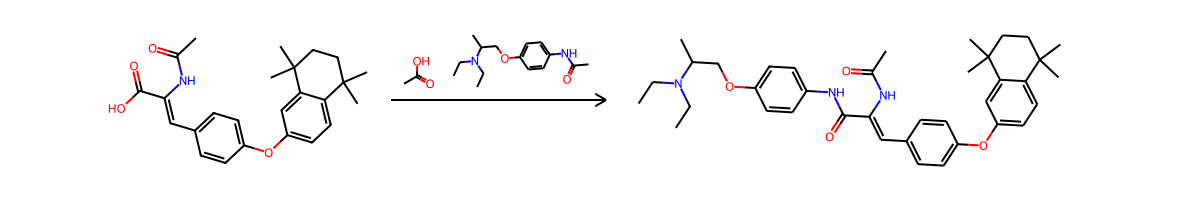

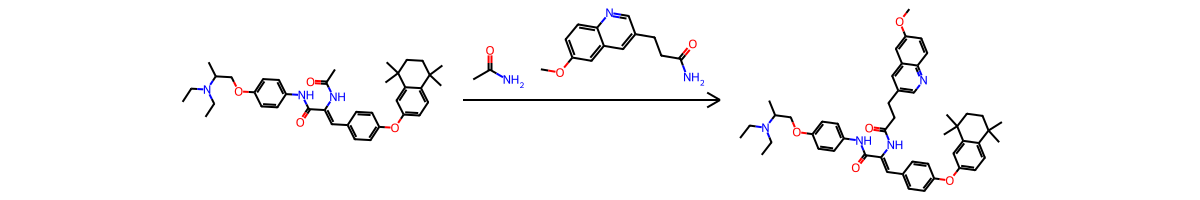

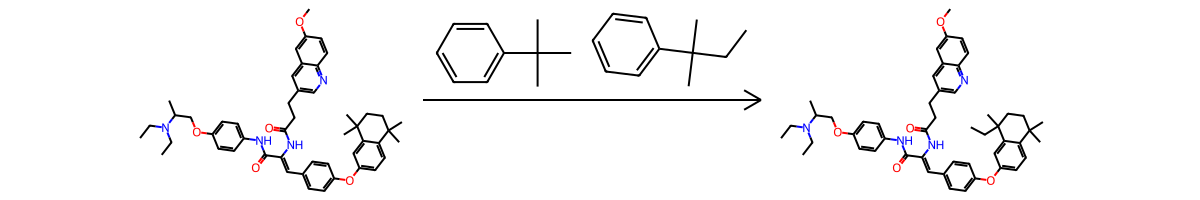

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
802_5_1_2


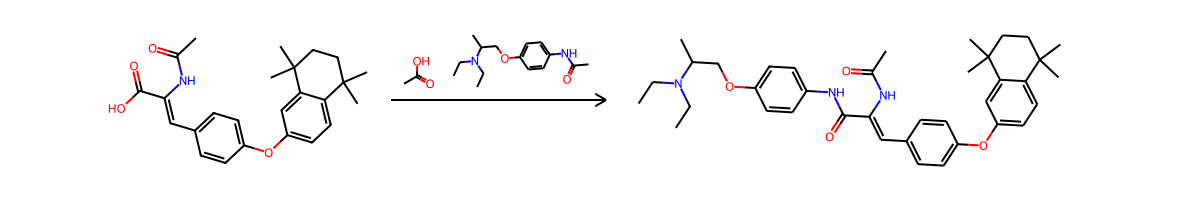

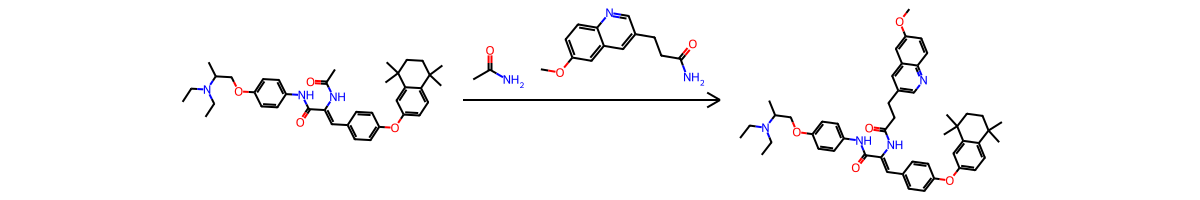

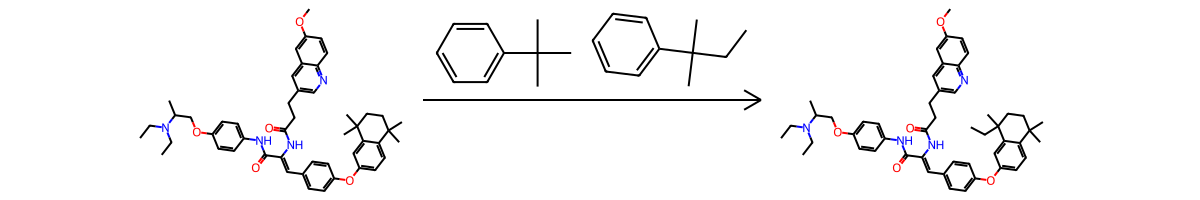

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
802_5_2_1


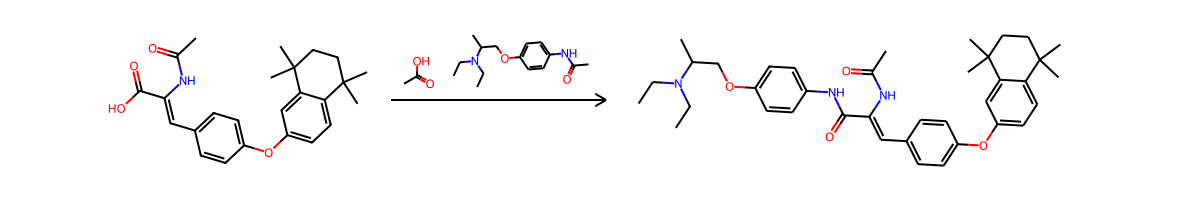

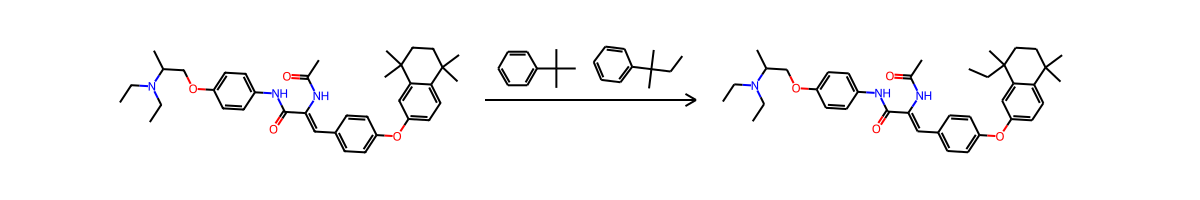

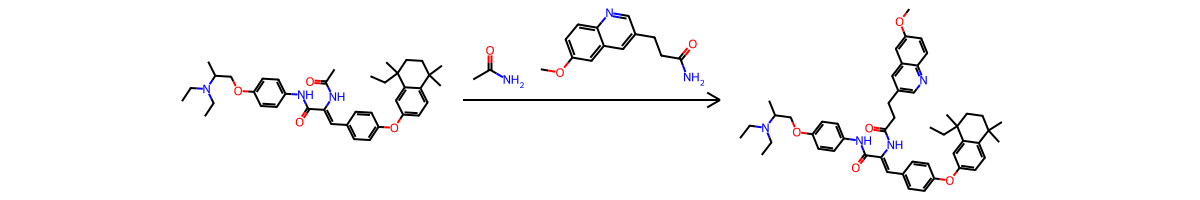

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
802_5_3_1


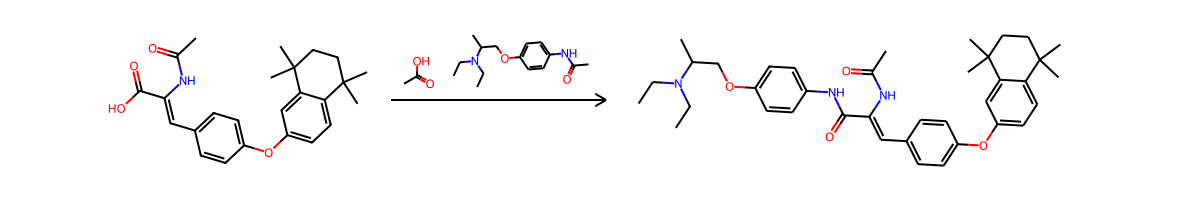

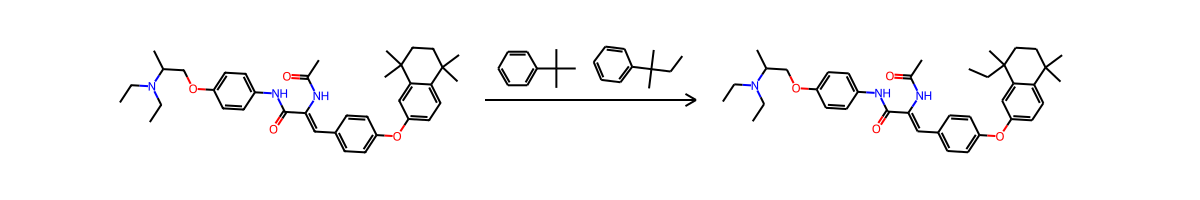

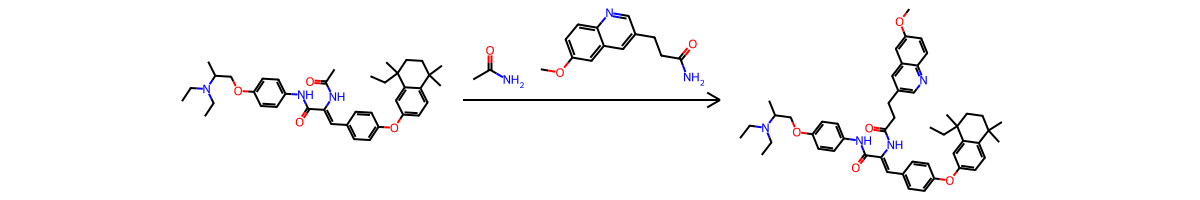

##############################################################################################################################################################################################
##############################################################################################################################################################################################
868



##############################################################################################################################################################################################
##############################################################################################################################################################################################


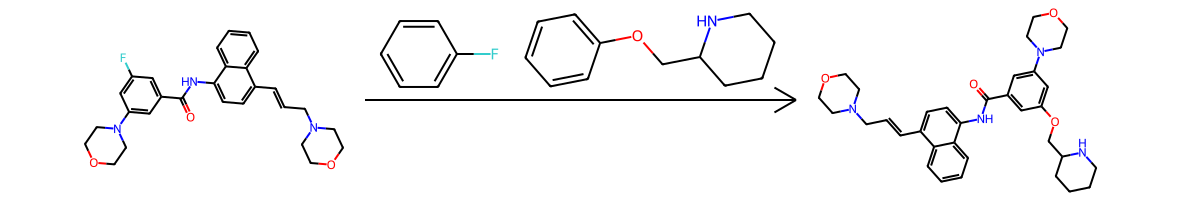

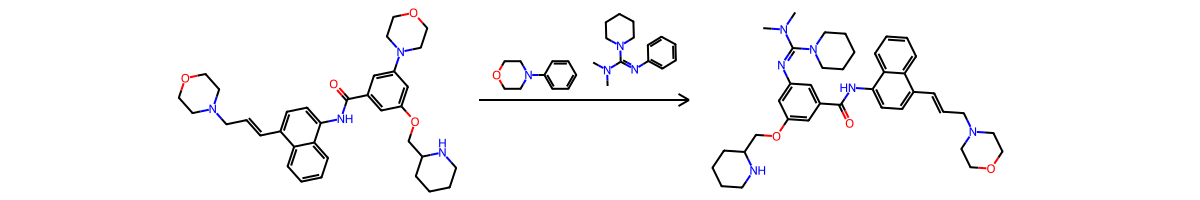

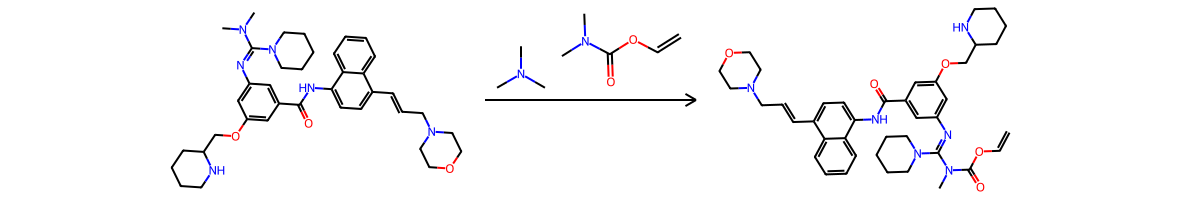

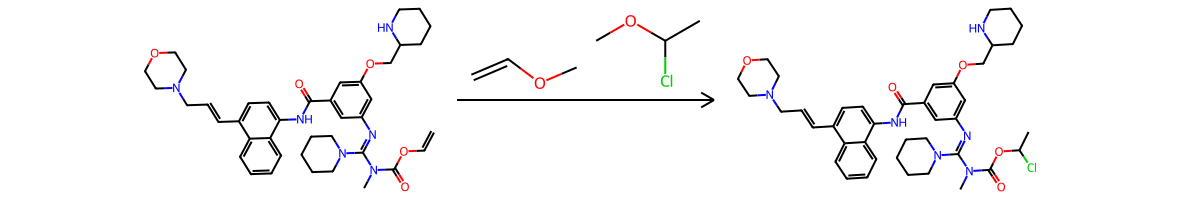

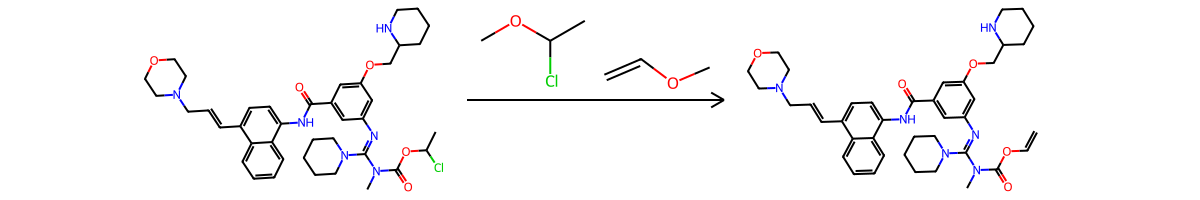

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
868_2_0_0


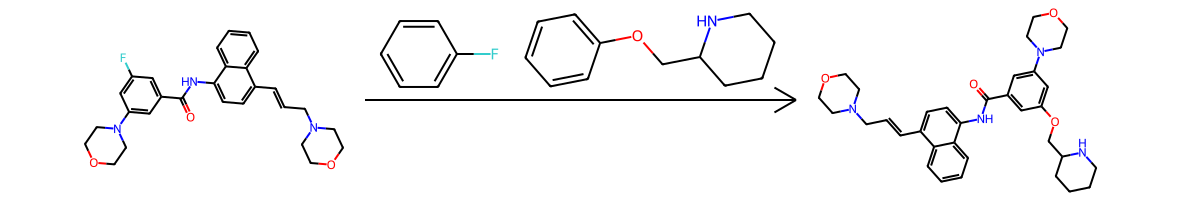

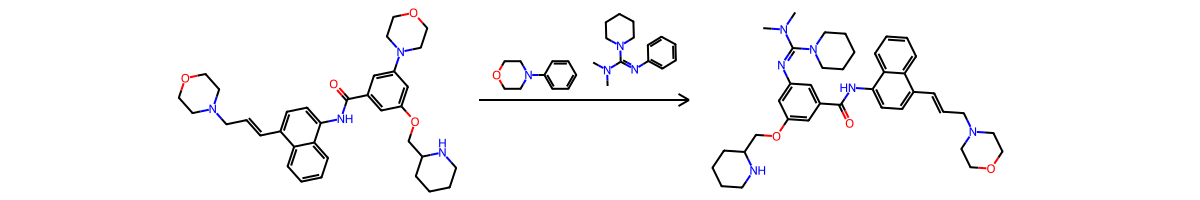

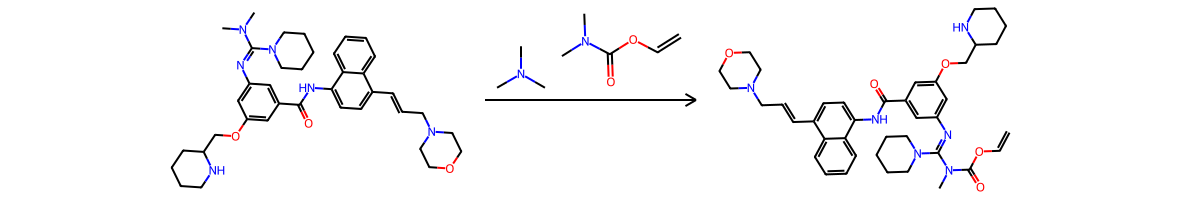

##############################################################################################################################################################################################
##############################################################################################################################################################################################
897



##############################################################################################################################################################################################
##############################################################################################################################################################################################


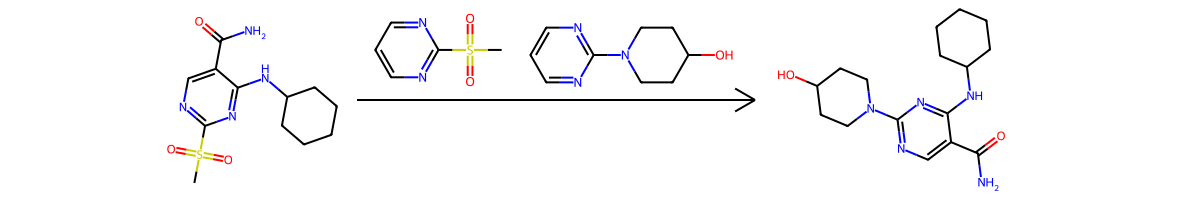

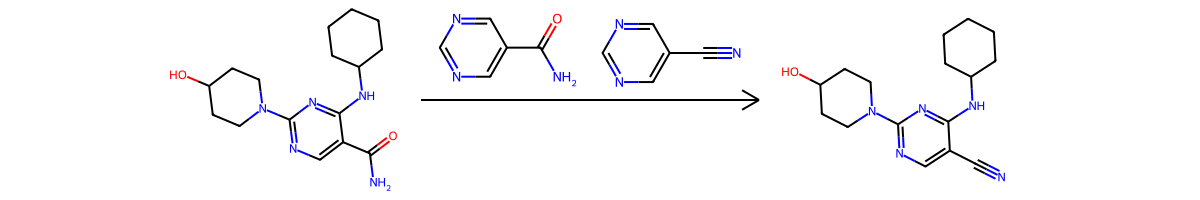

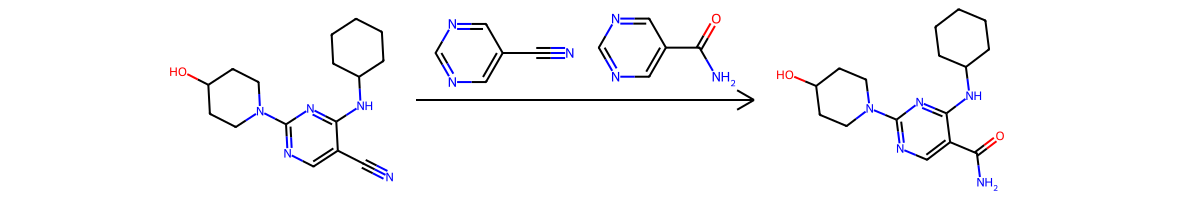

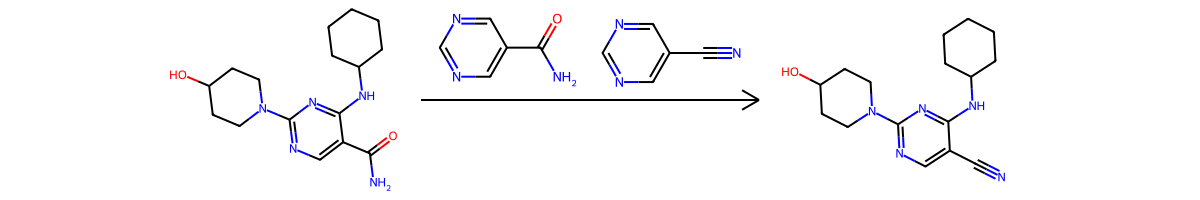

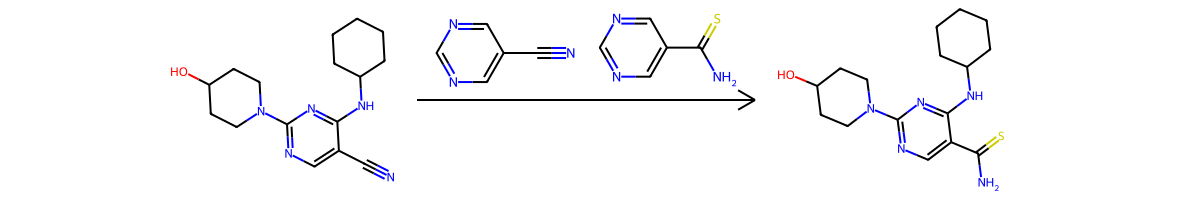

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
897_3_0_0


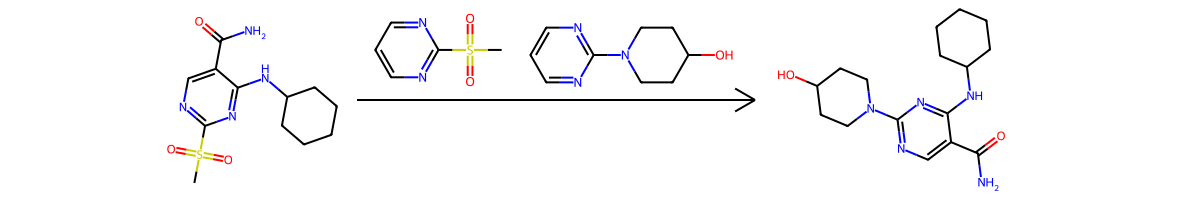

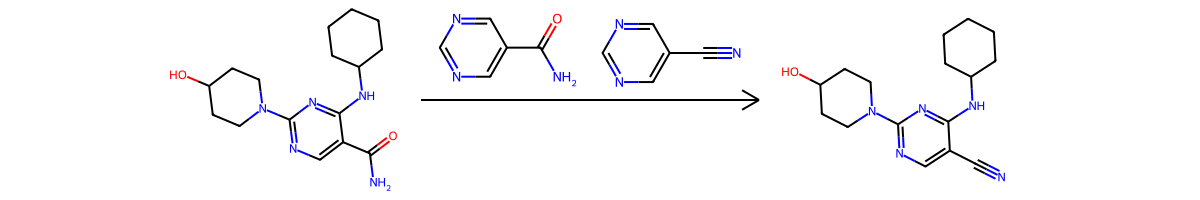

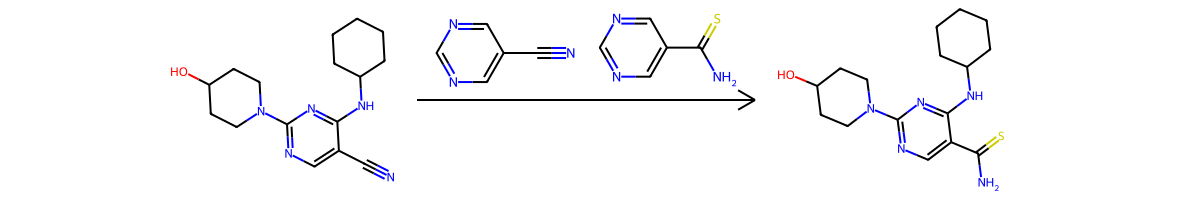

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1053



##############################################################################################################################################################################################
##############################################################################################################################################################################################


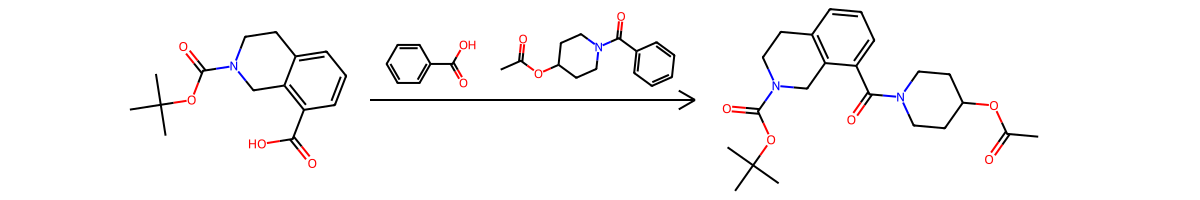

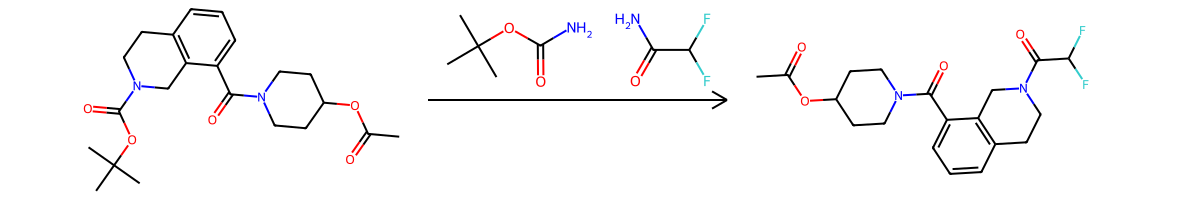

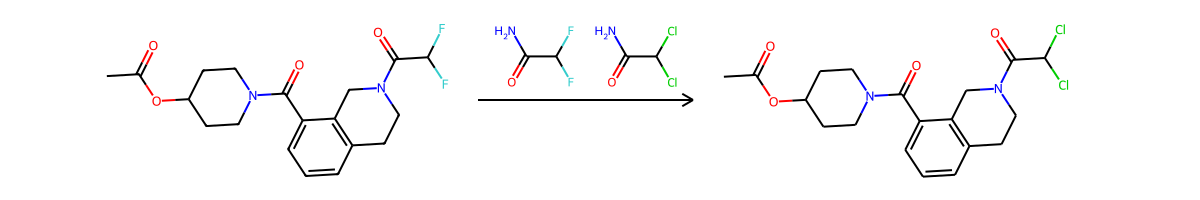

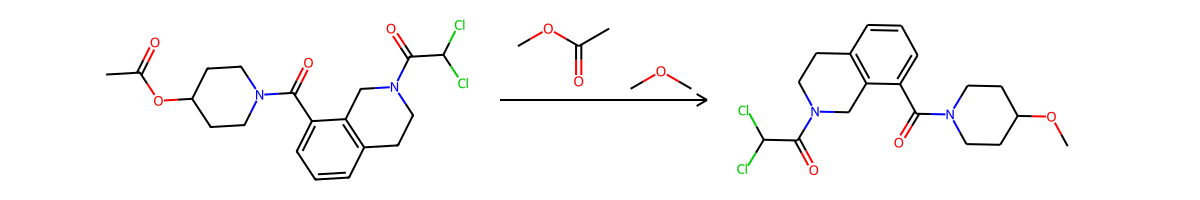

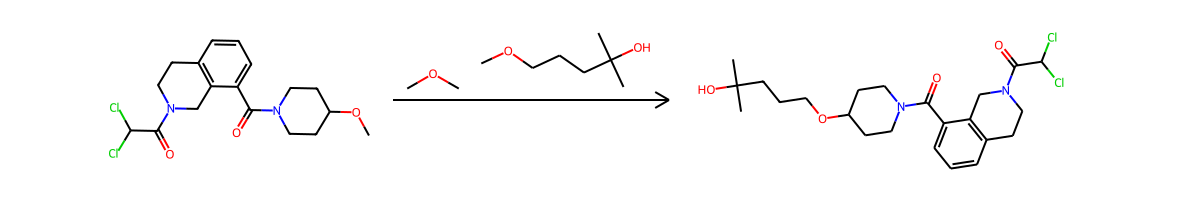

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1053_7_0_0


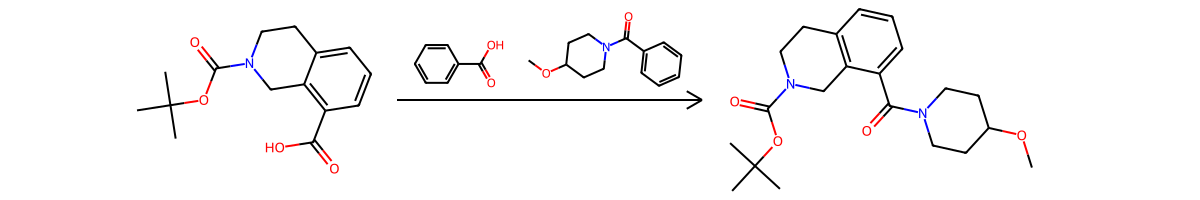

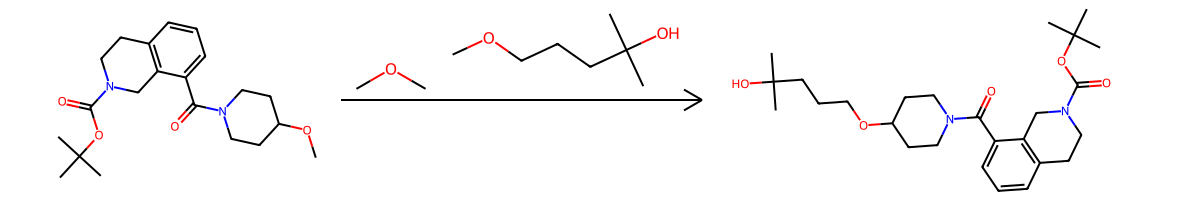

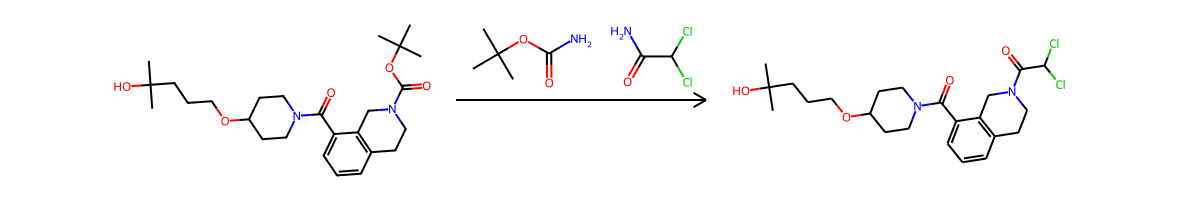

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1053_7_4_0


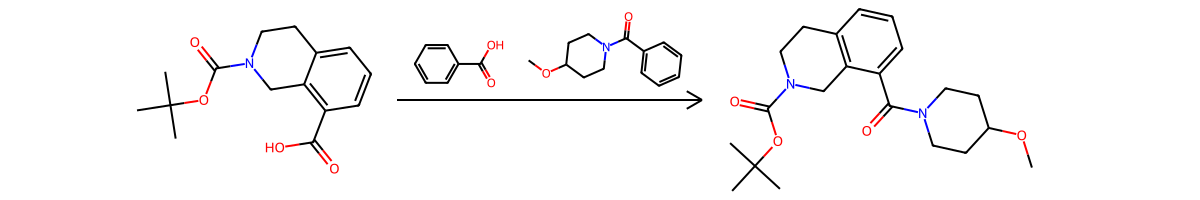

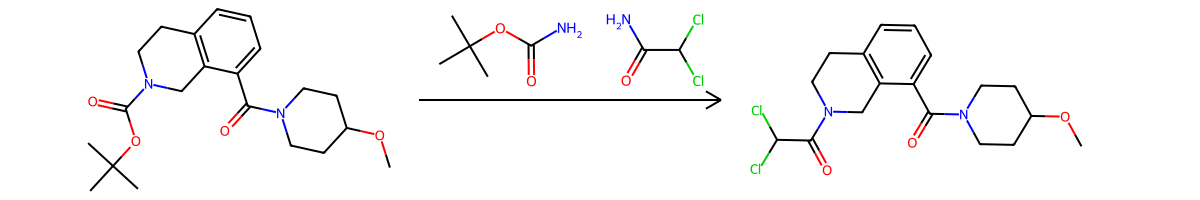

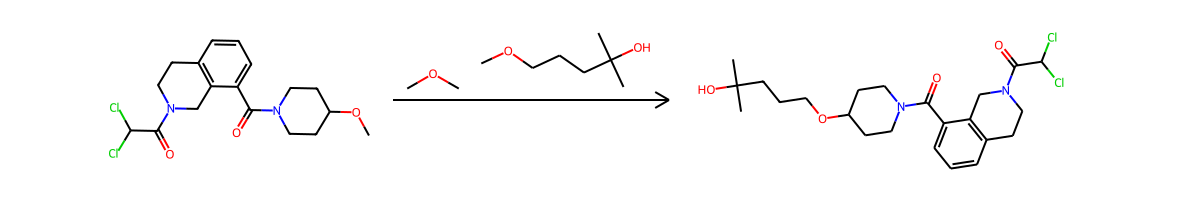

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1066



##############################################################################################################################################################################################
##############################################################################################################################################################################################


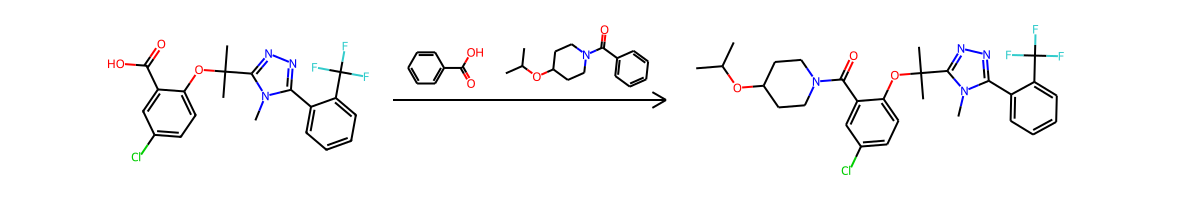

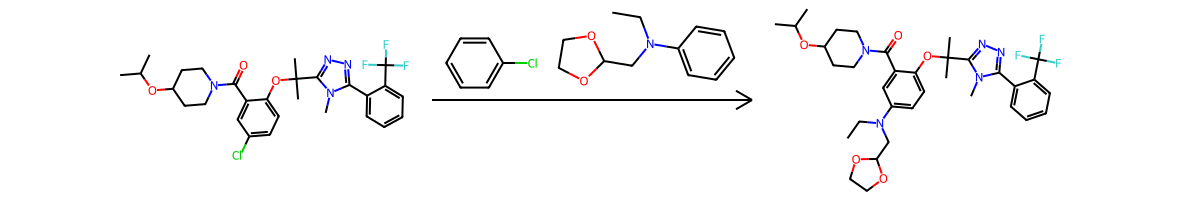

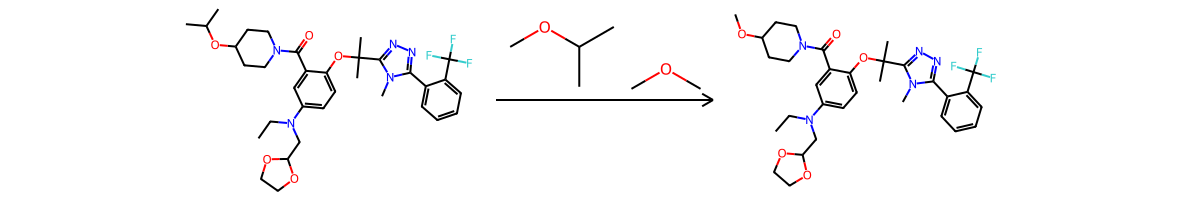

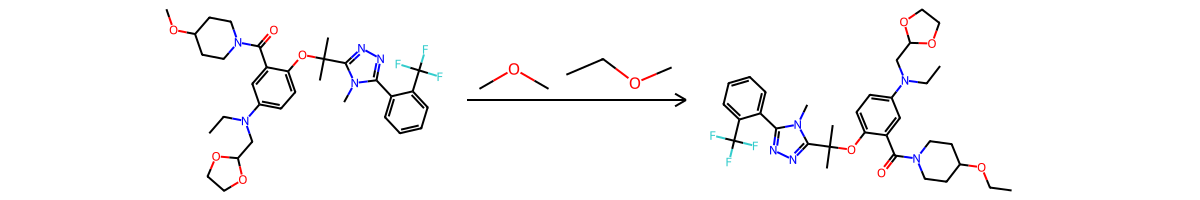

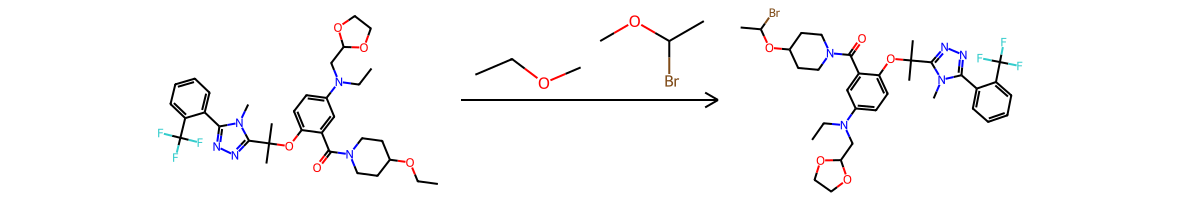

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1066_6_0_0


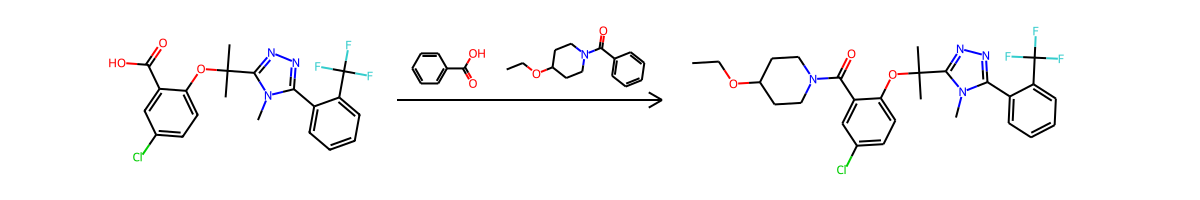

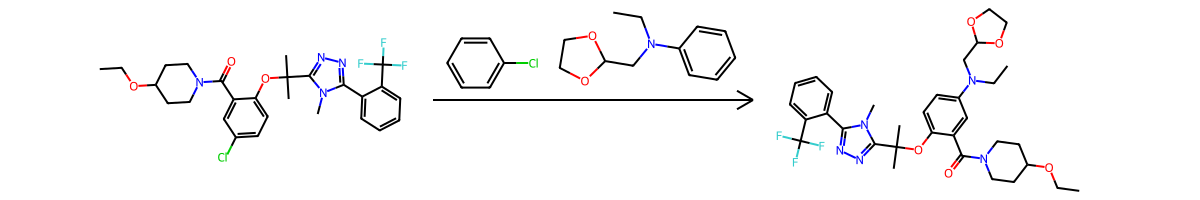

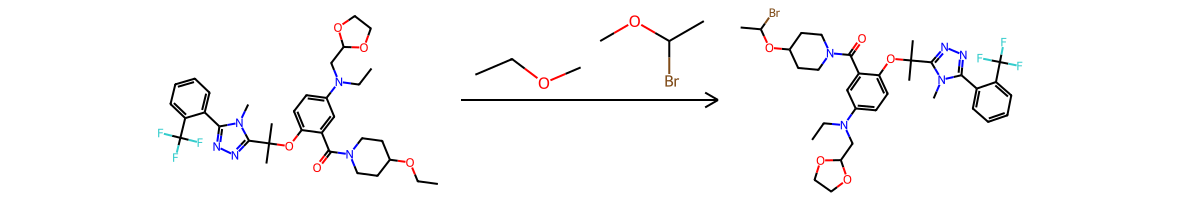

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1067



##############################################################################################################################################################################################
##############################################################################################################################################################################################


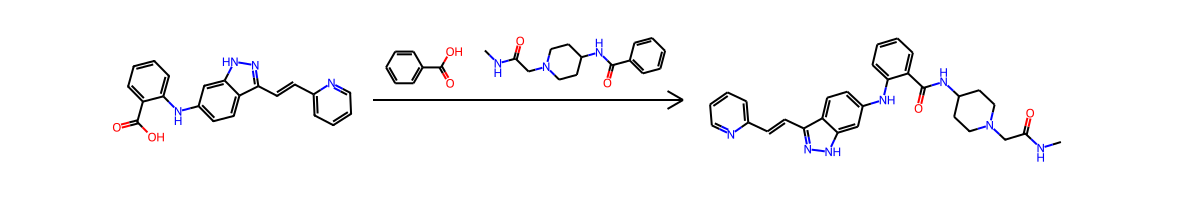

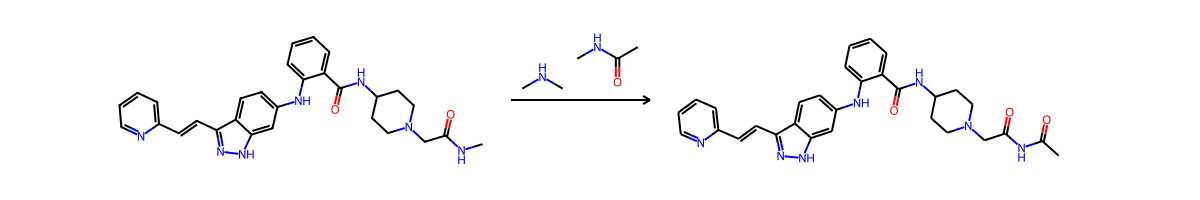

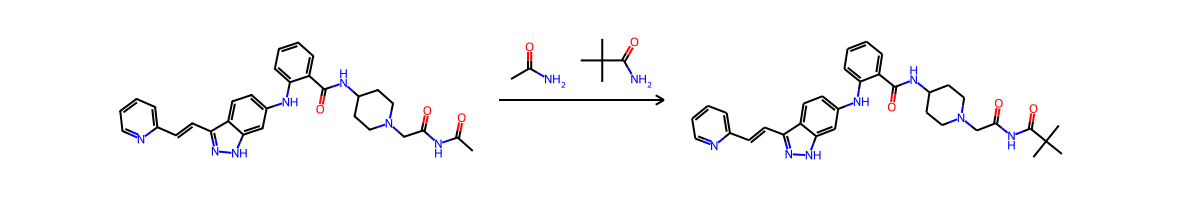

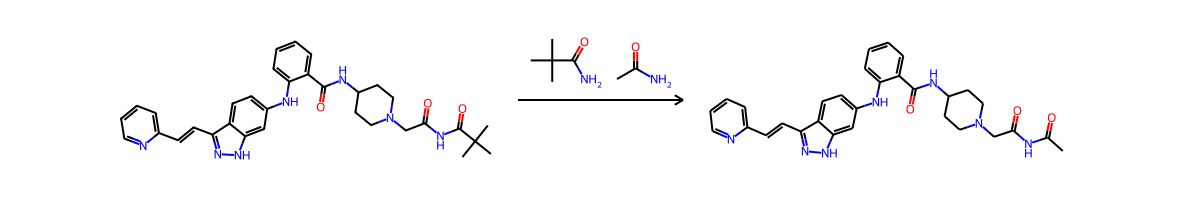

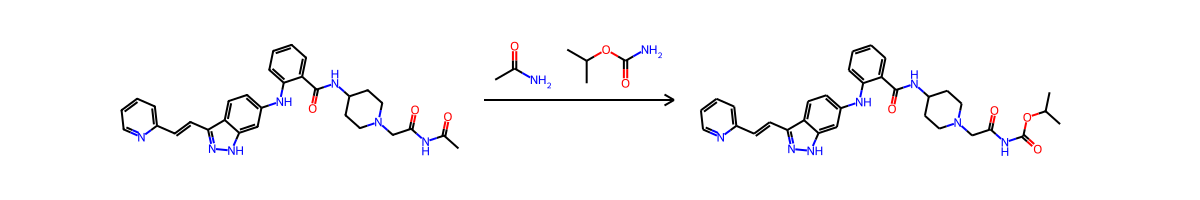

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1067_2_0_0


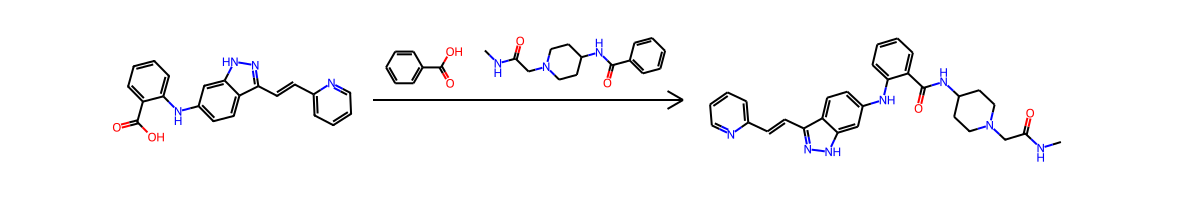

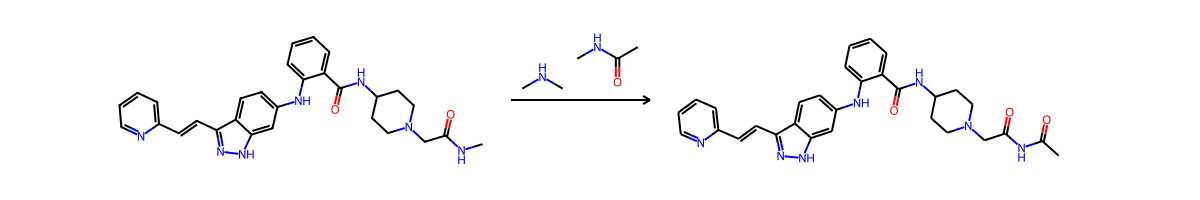

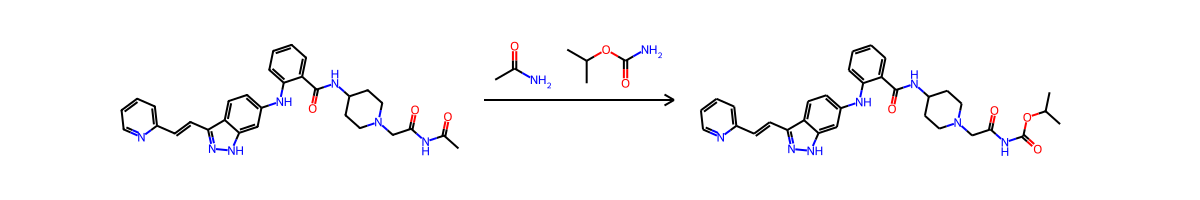

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1086



##############################################################################################################################################################################################
##############################################################################################################################################################################################


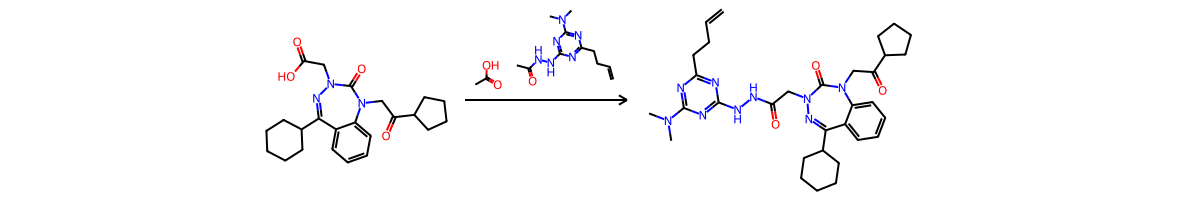

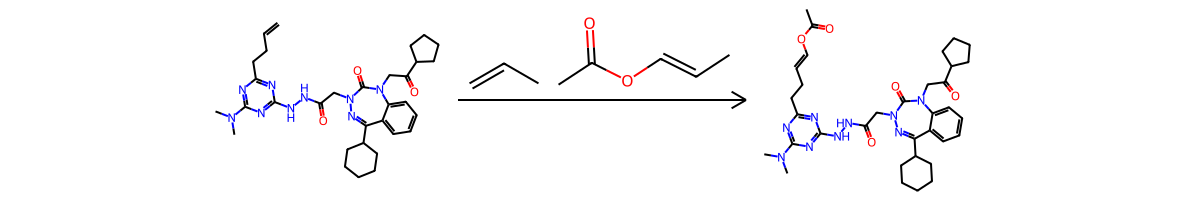

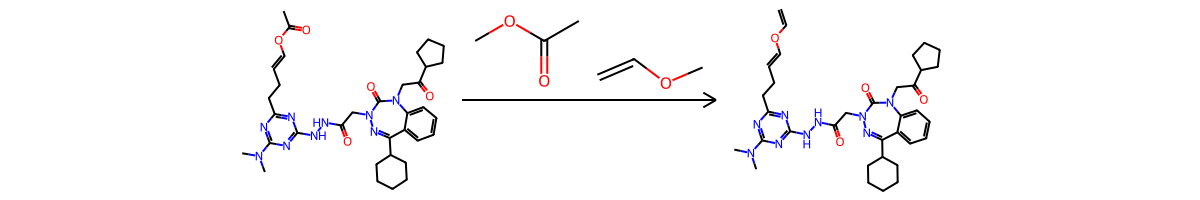

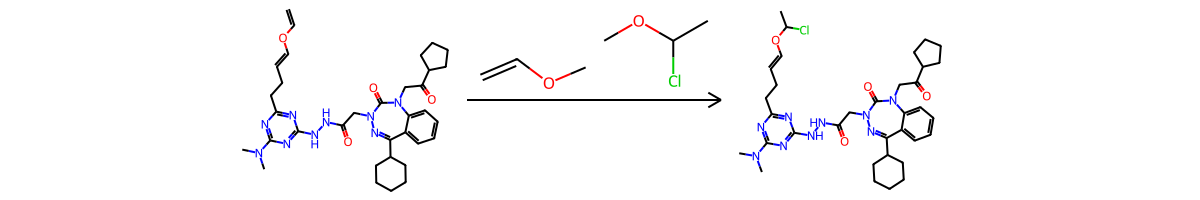

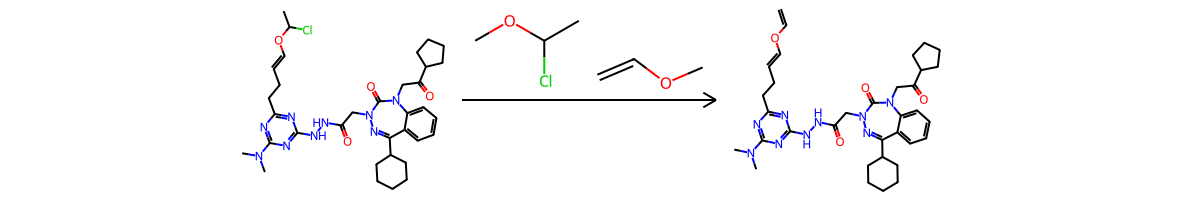

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1086_0_0_0


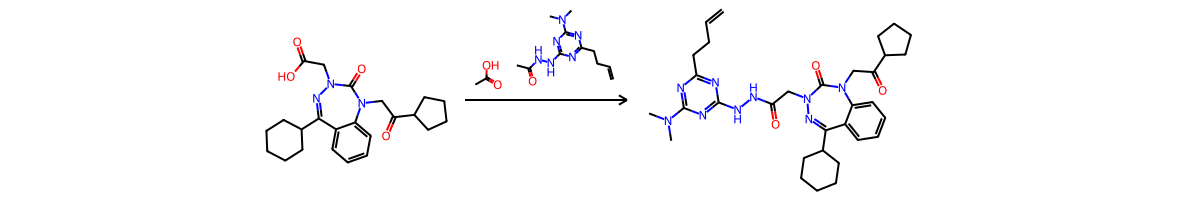

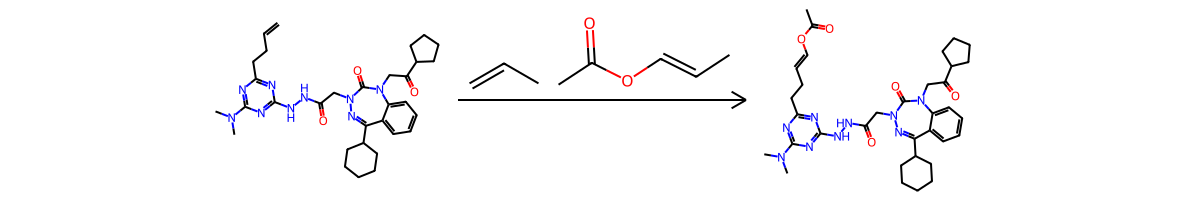

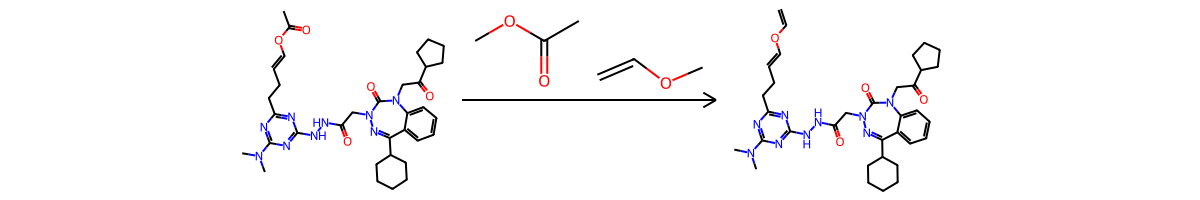

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1090



##############################################################################################################################################################################################
##############################################################################################################################################################################################


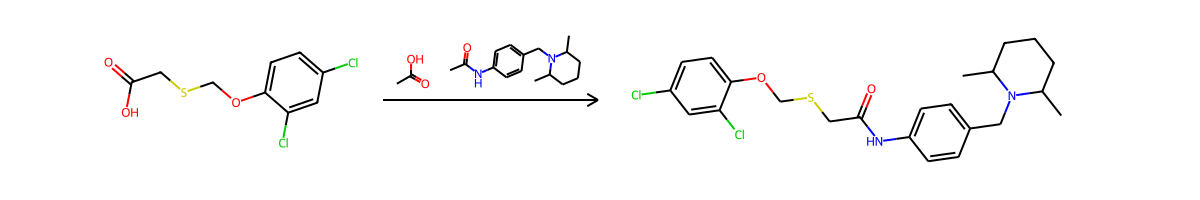

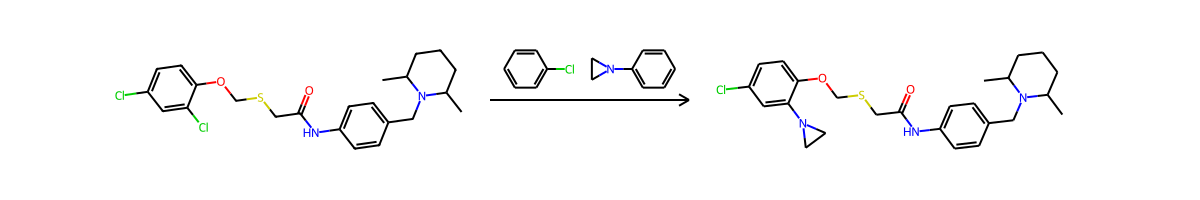

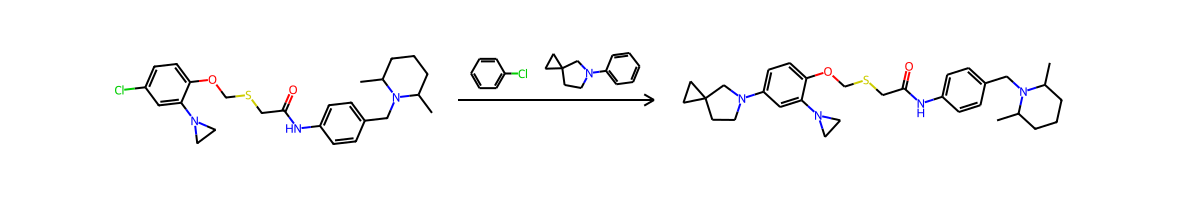

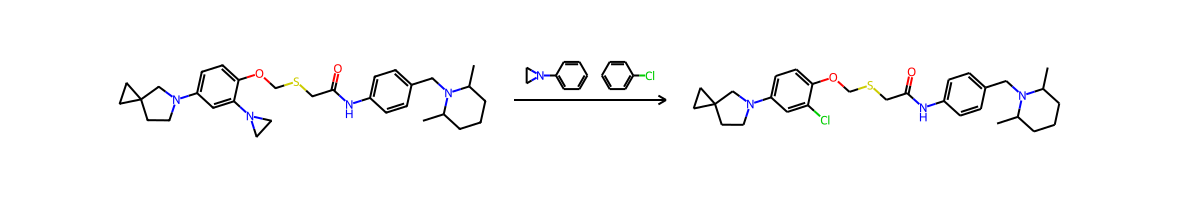

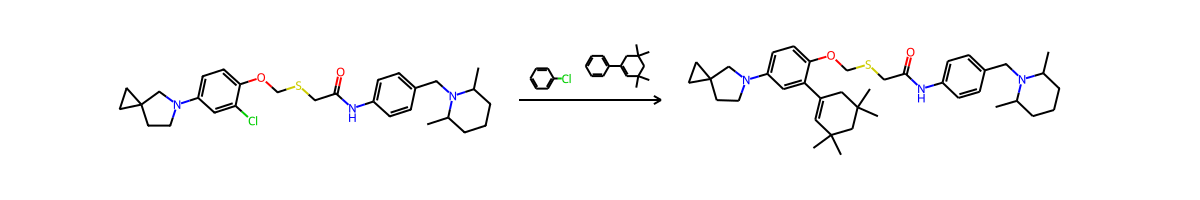

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1090_0_2_0


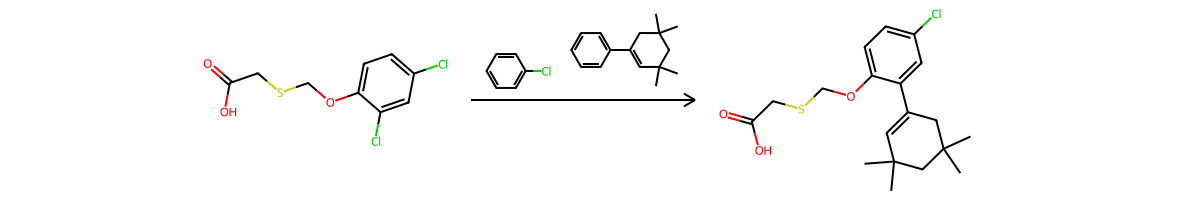

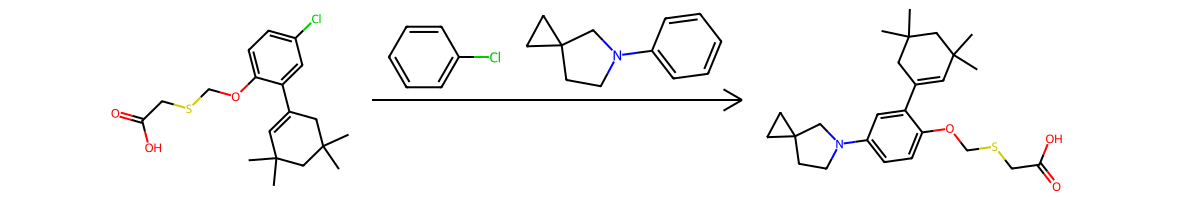

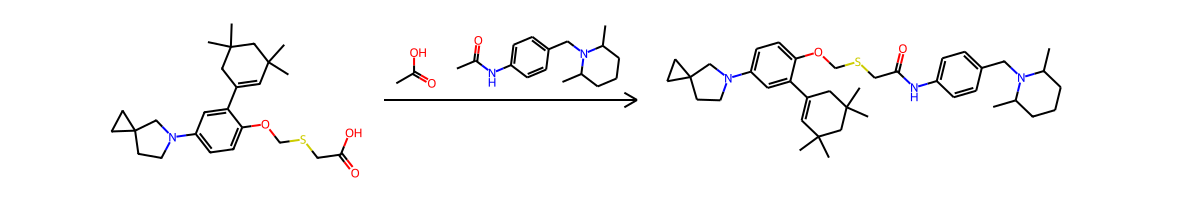

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1090_0_0_0


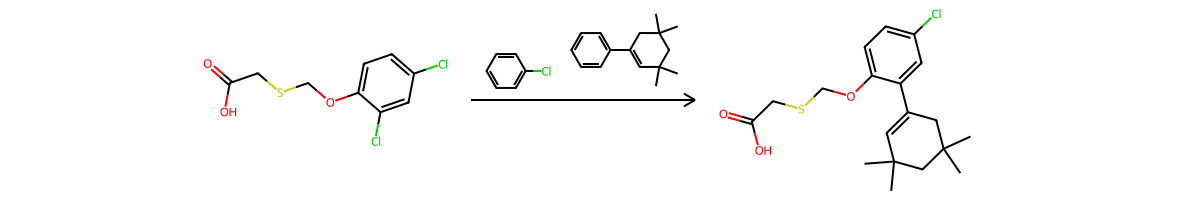

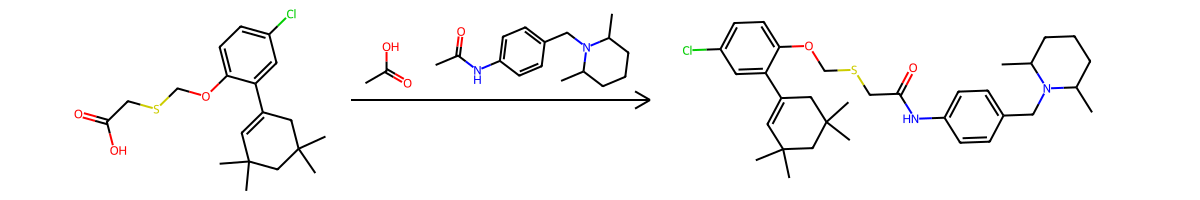

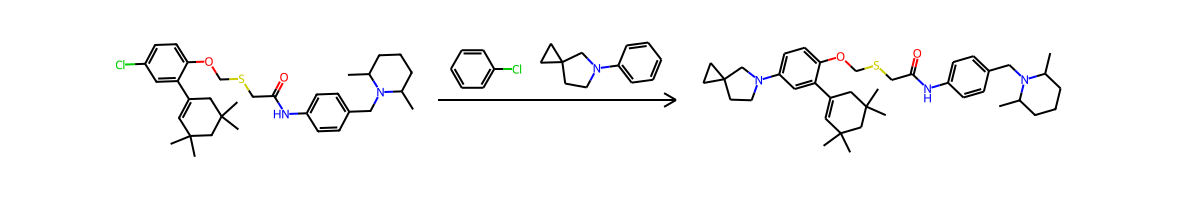

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1189



##############################################################################################################################################################################################
##############################################################################################################################################################################################


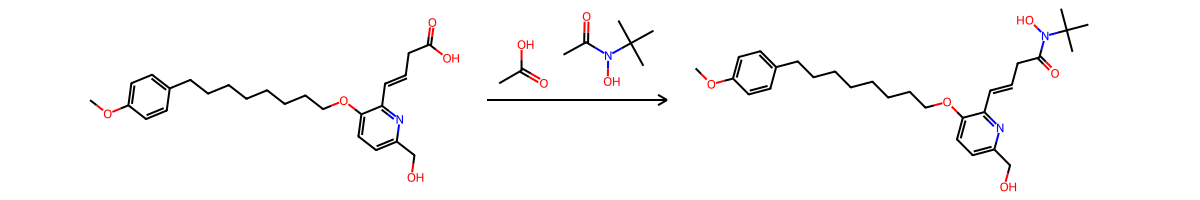

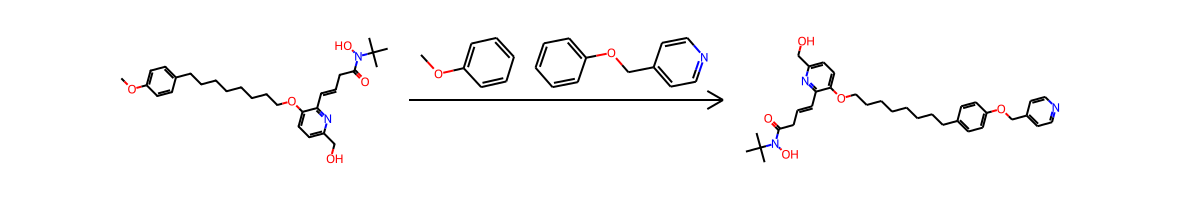

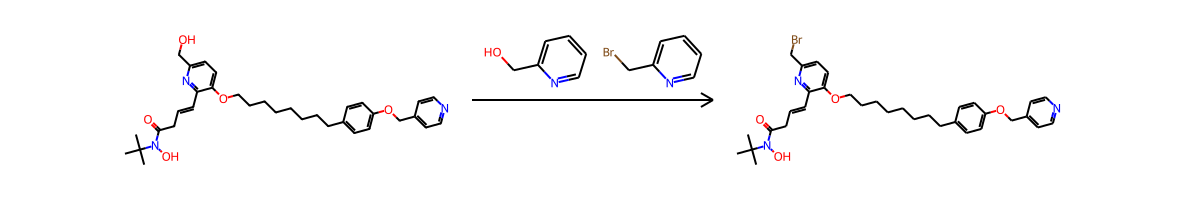

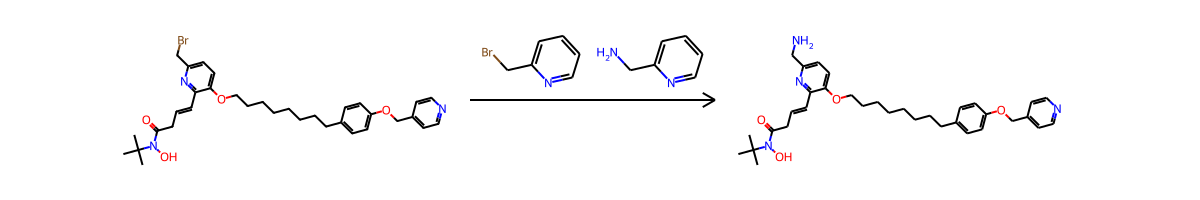

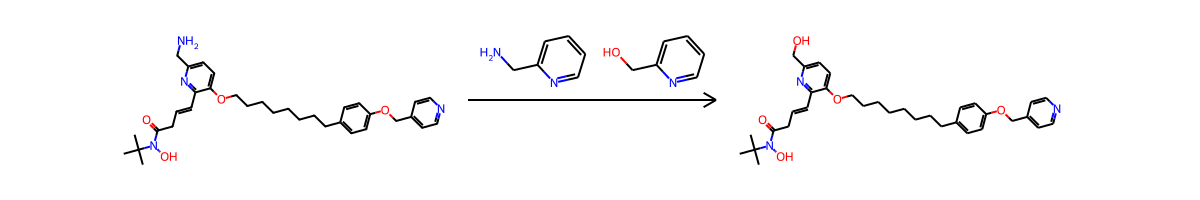

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1189_0_5


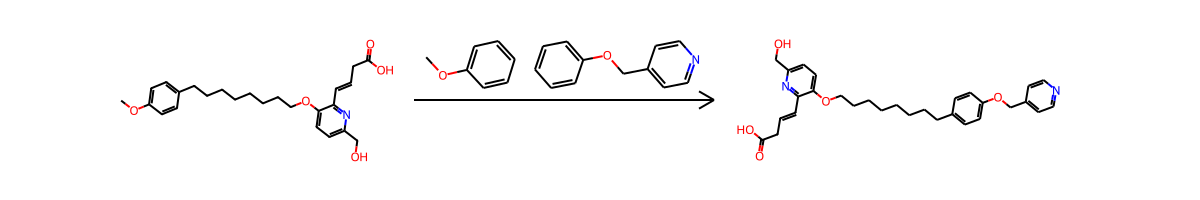

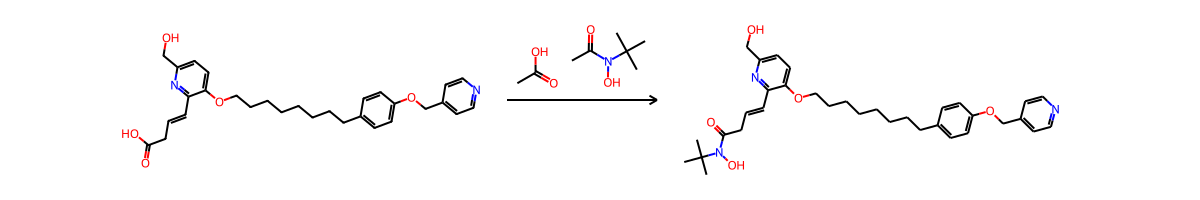

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1230



##############################################################################################################################################################################################
##############################################################################################################################################################################################


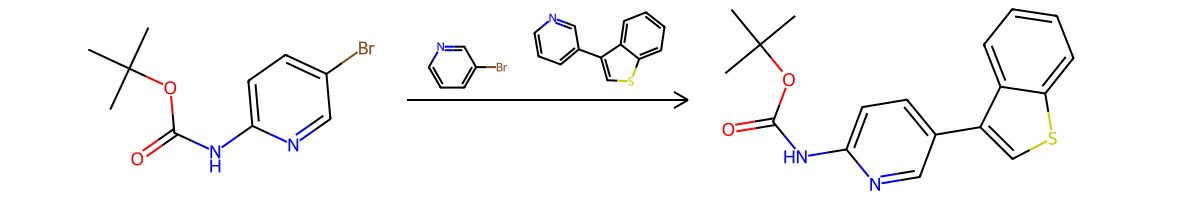

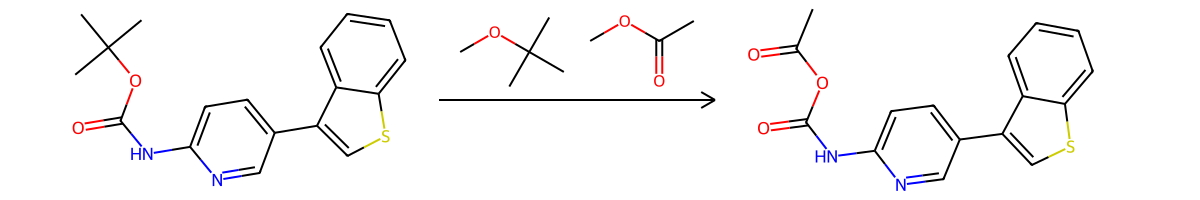

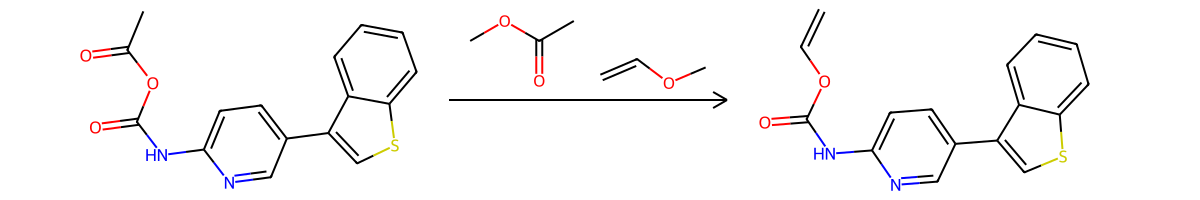

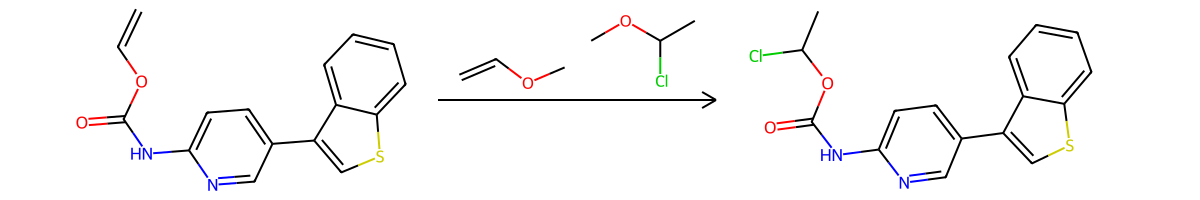

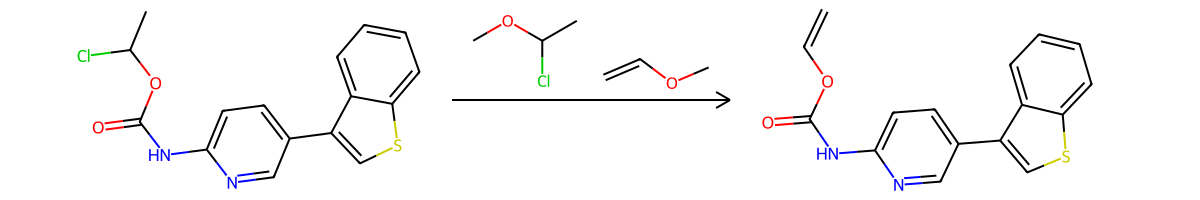

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1230_0_0_0


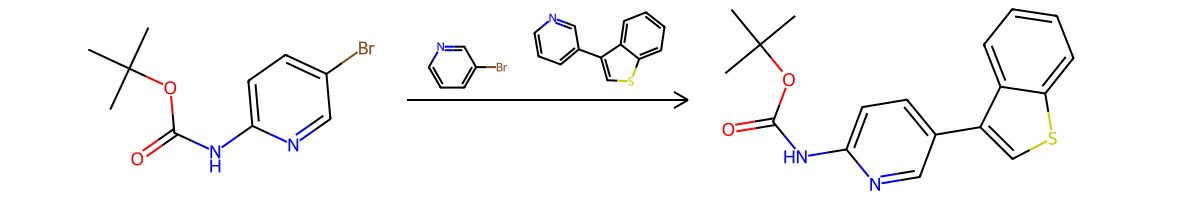

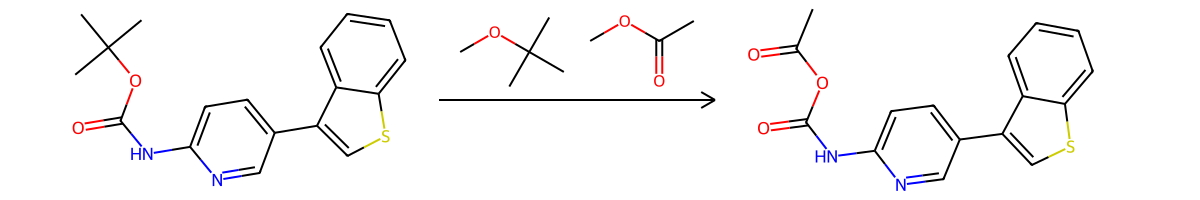

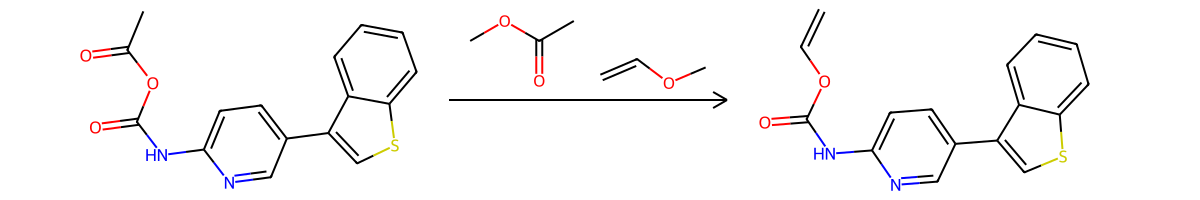

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1251



##############################################################################################################################################################################################
##############################################################################################################################################################################################


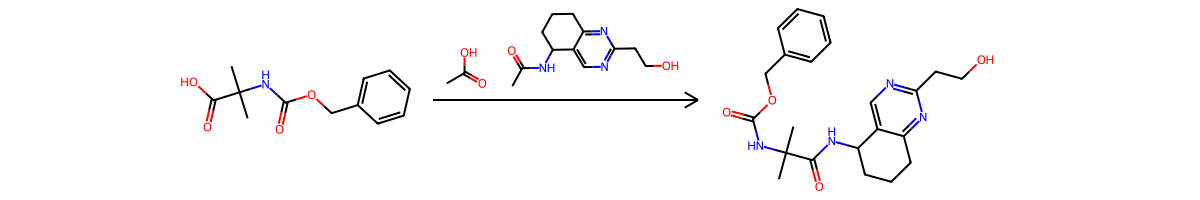

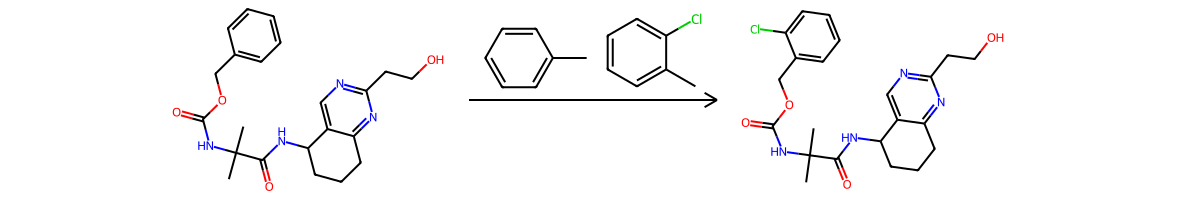

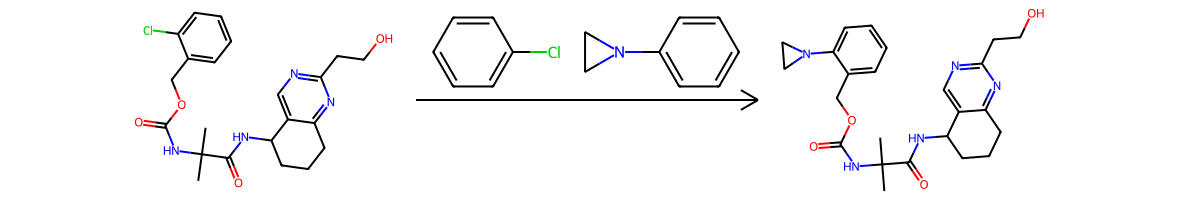

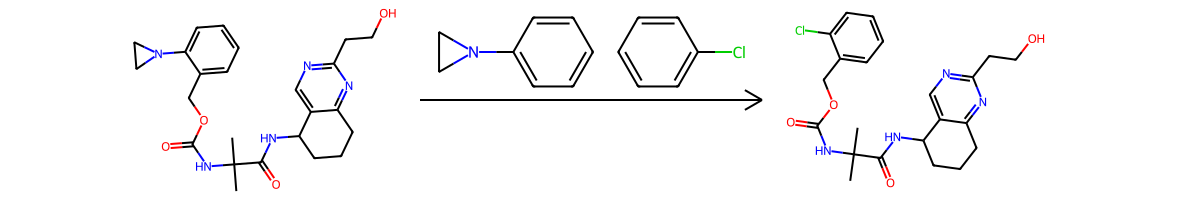

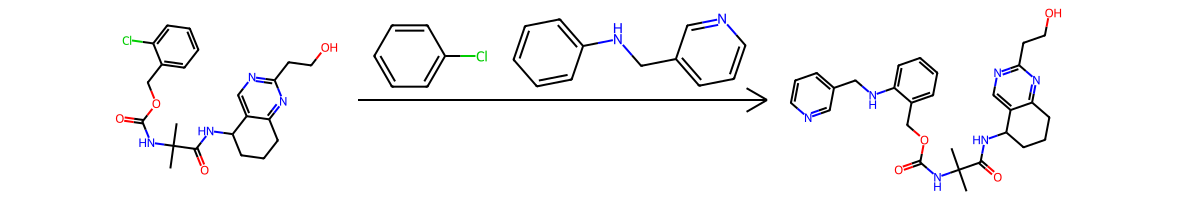

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1251_2_0_0


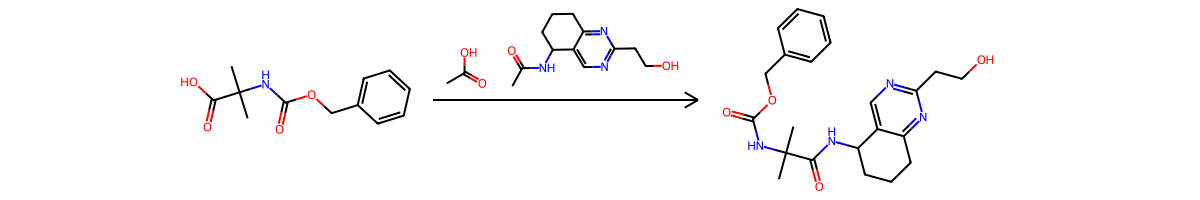

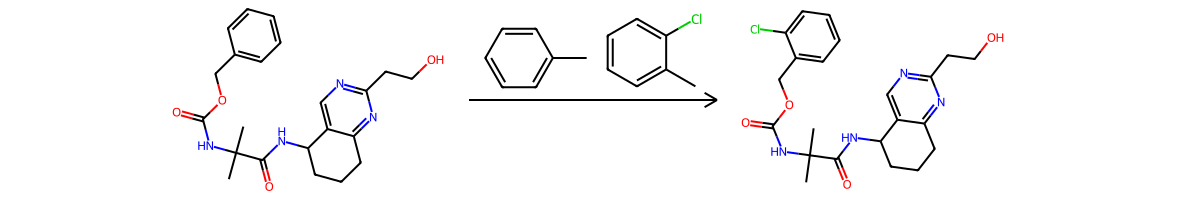

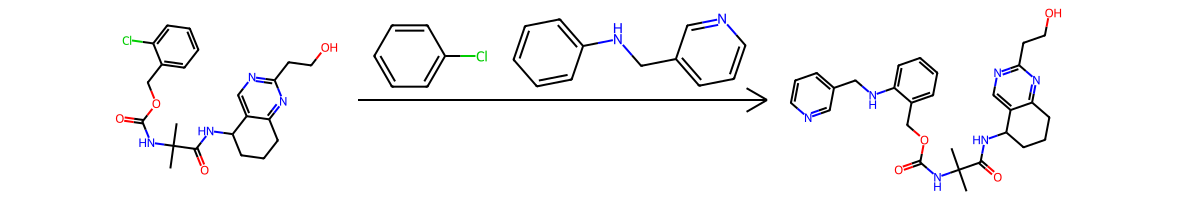

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1251_2_1_0


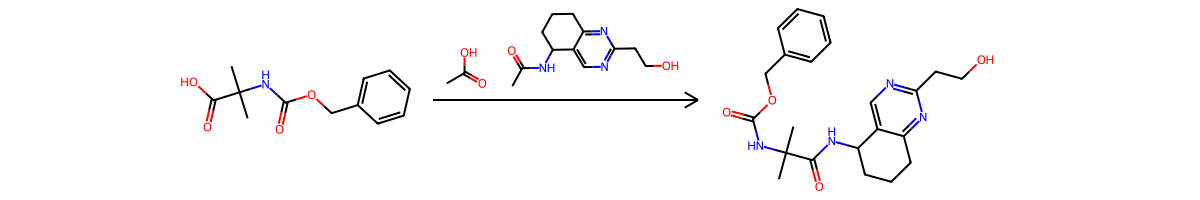

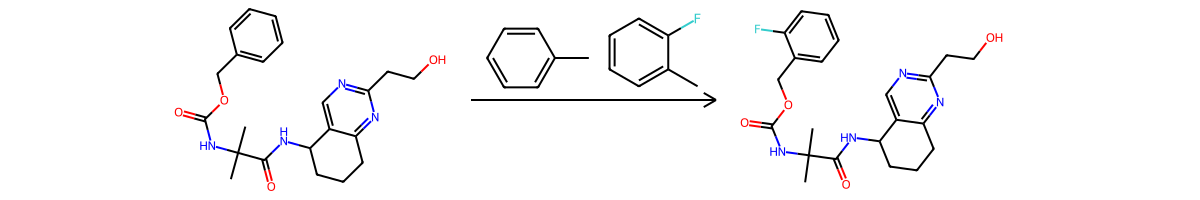

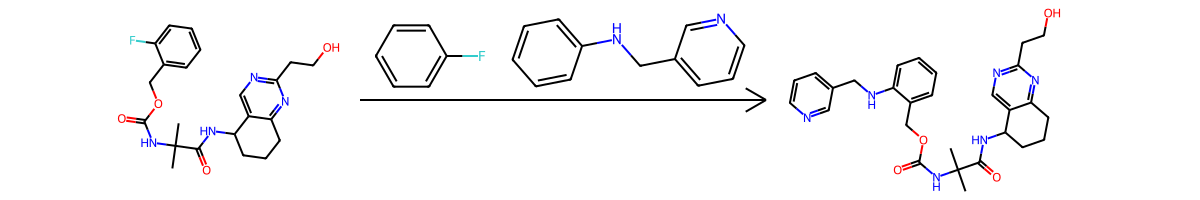

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1267



##############################################################################################################################################################################################
##############################################################################################################################################################################################


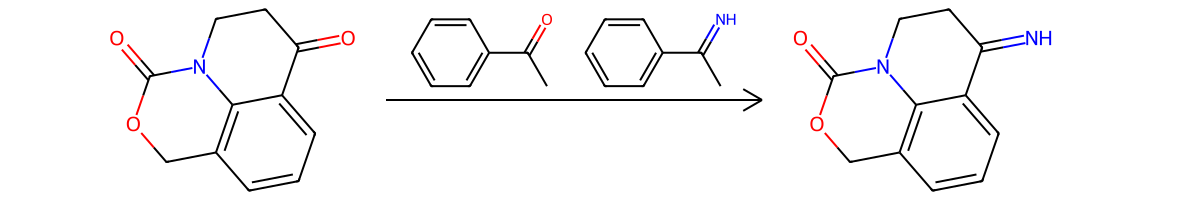

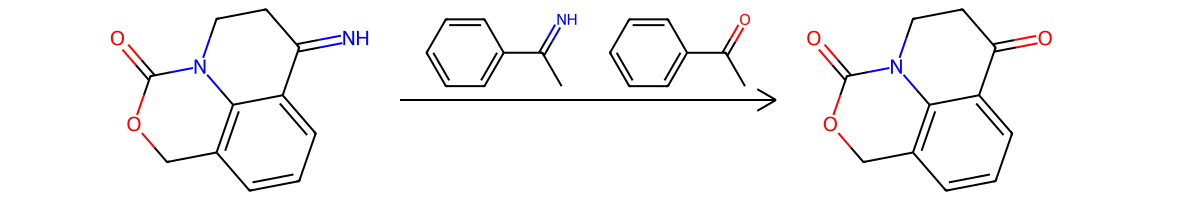

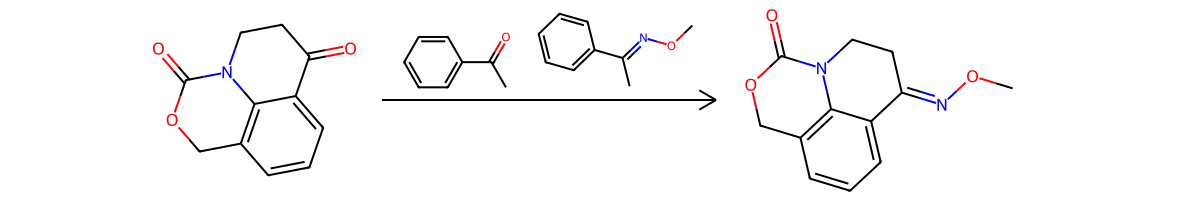

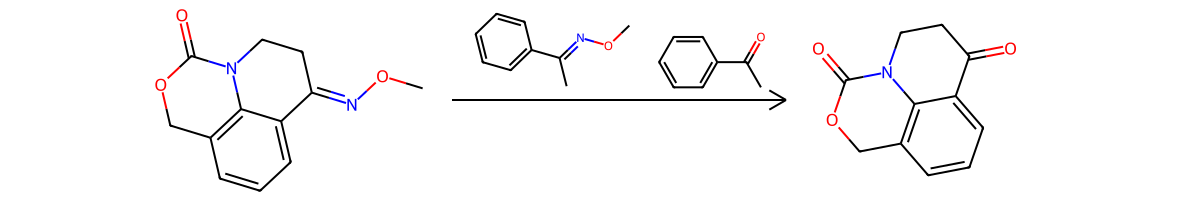

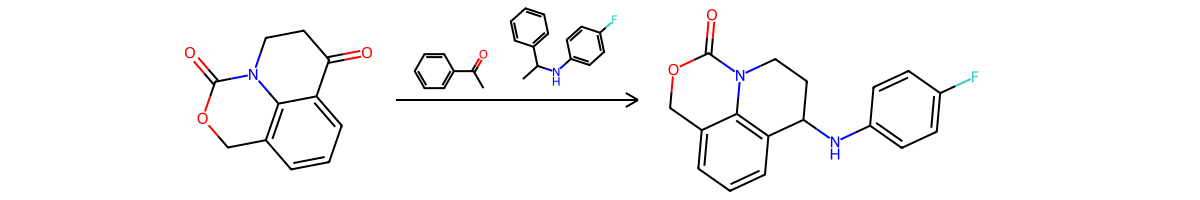

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1267_3


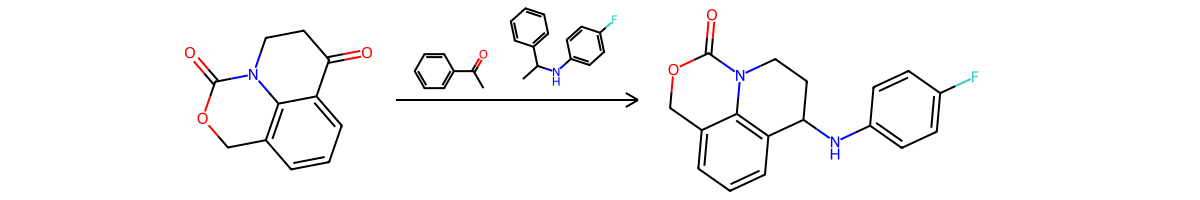

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1279



##############################################################################################################################################################################################
##############################################################################################################################################################################################


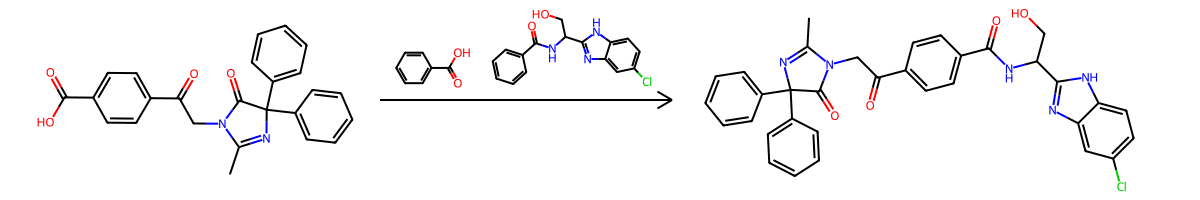

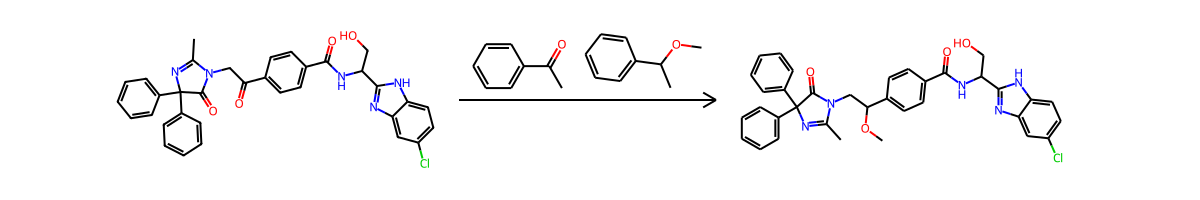

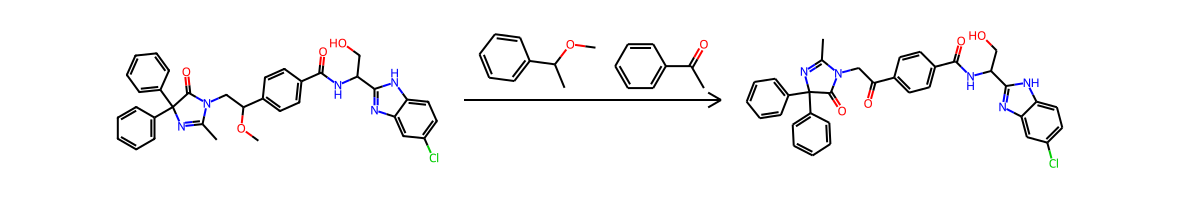

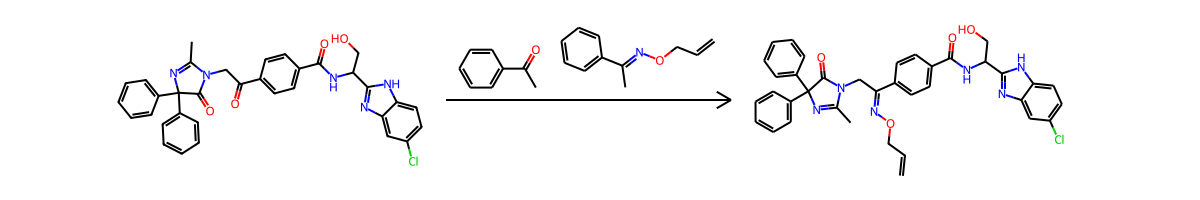

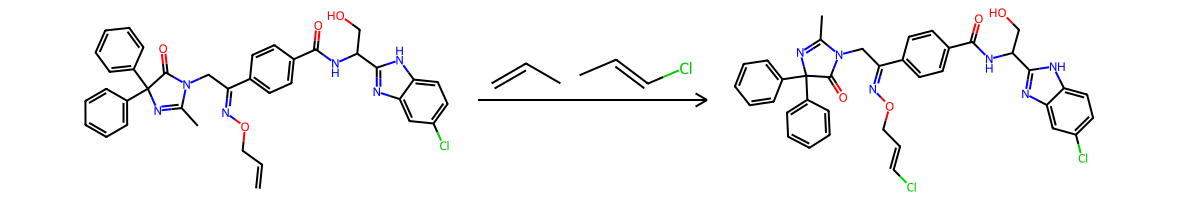

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1279_1_0_0


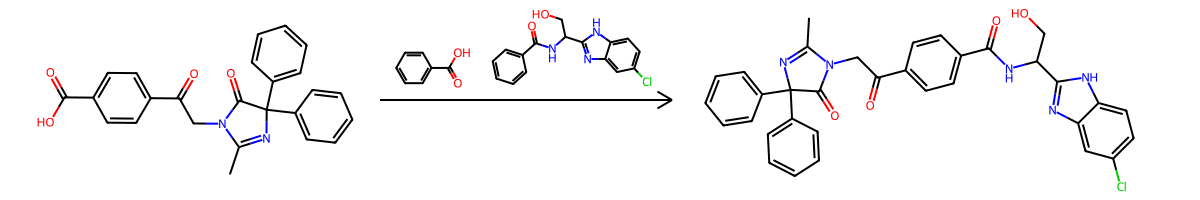

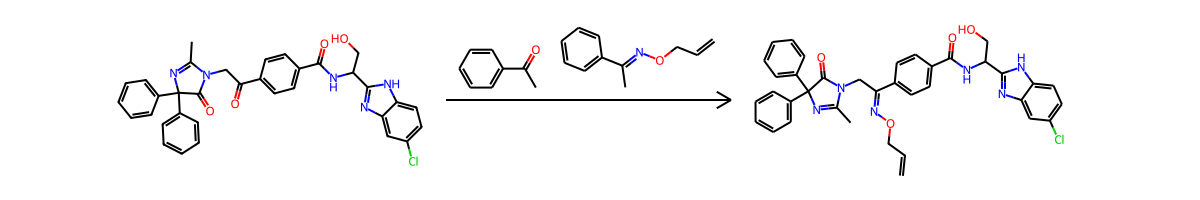

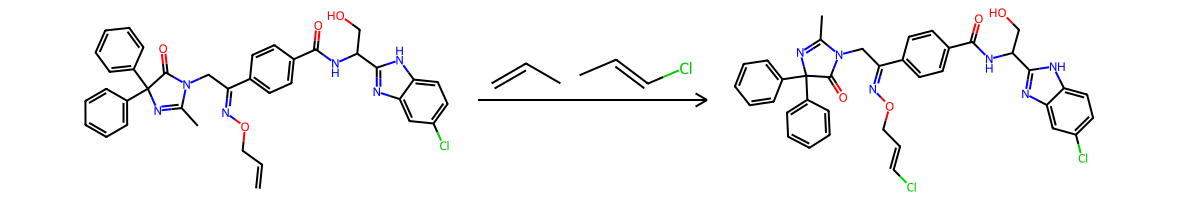

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1303



##############################################################################################################################################################################################
##############################################################################################################################################################################################


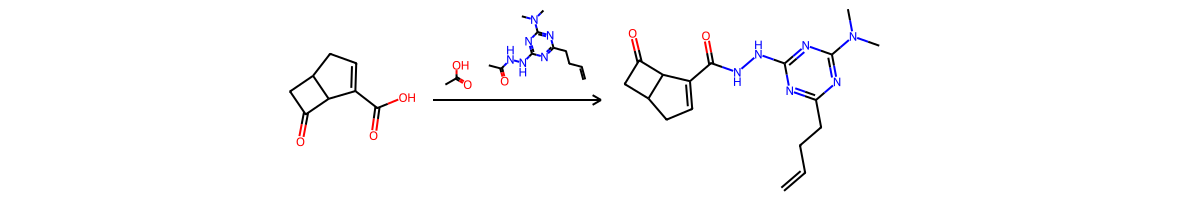

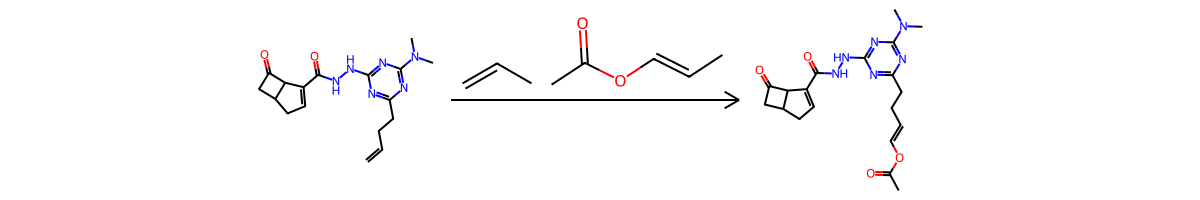

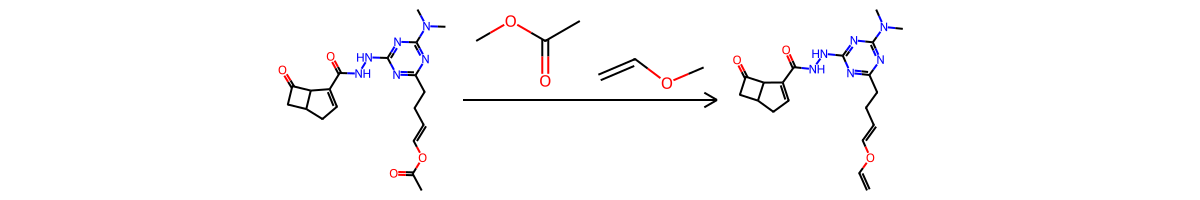

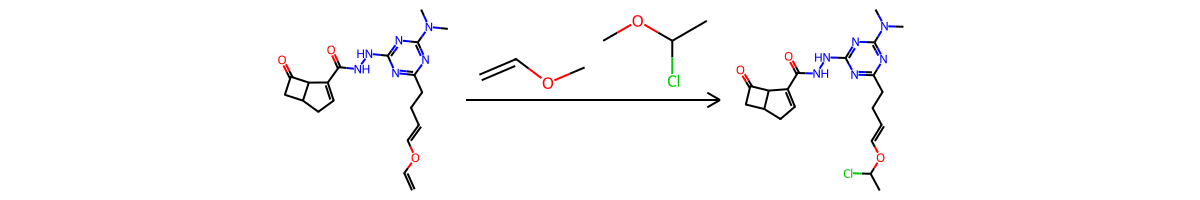

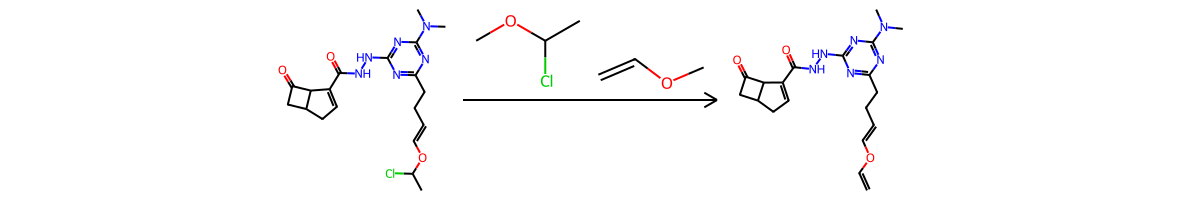

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1303_1_0_0


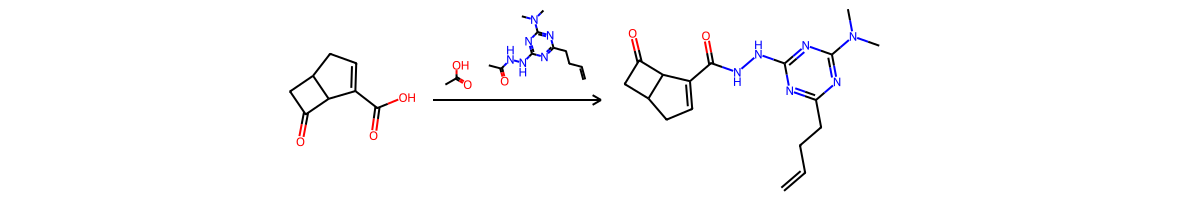

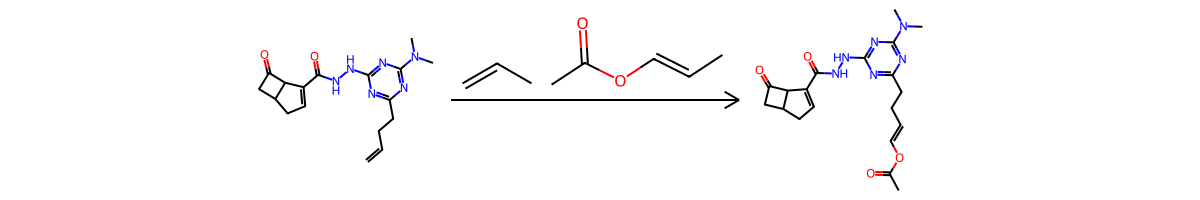

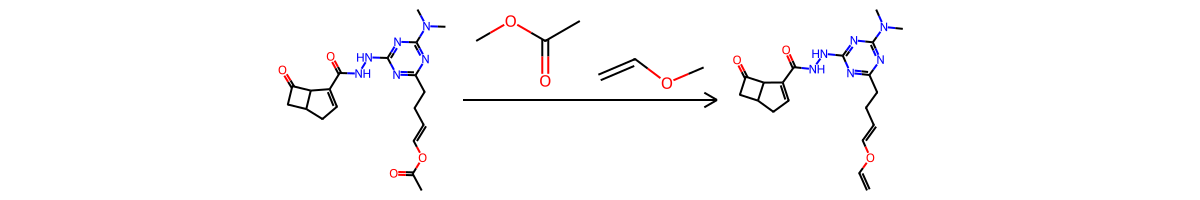

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1586



##############################################################################################################################################################################################
##############################################################################################################################################################################################


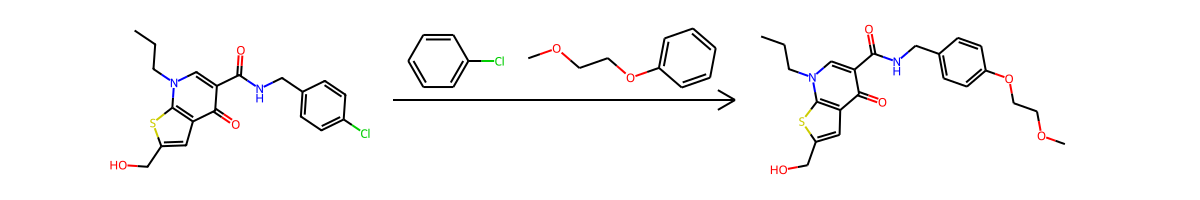

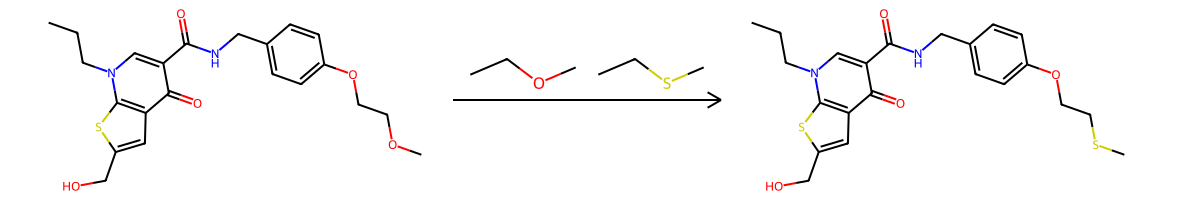

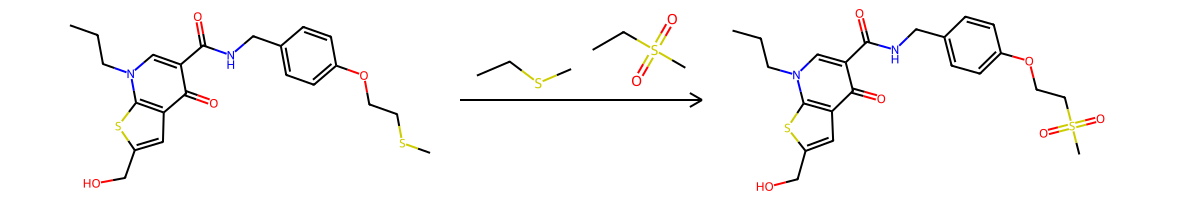

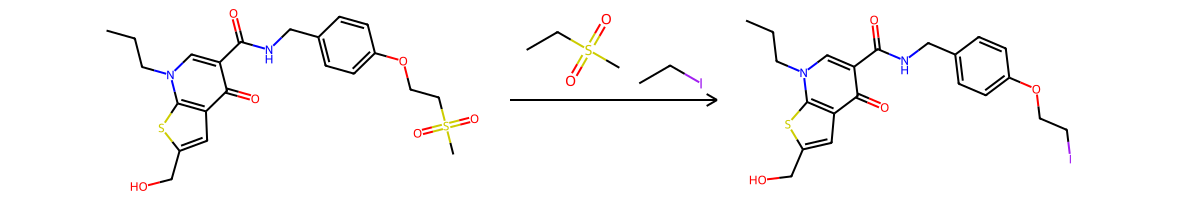

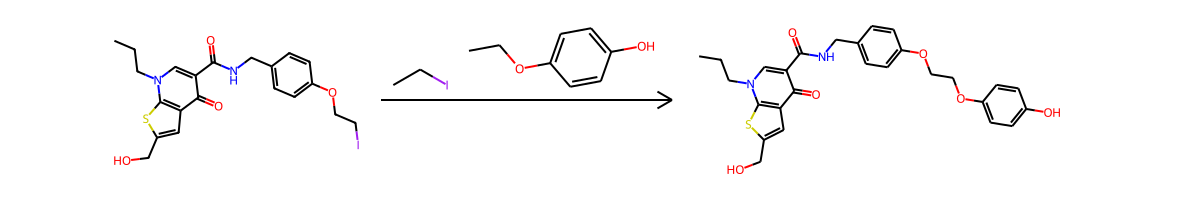

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1586_4_7_5


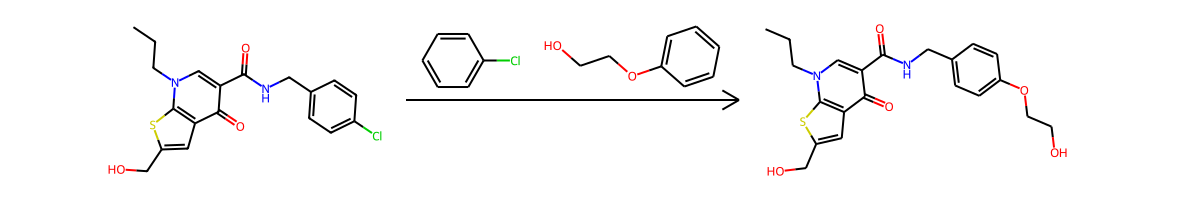

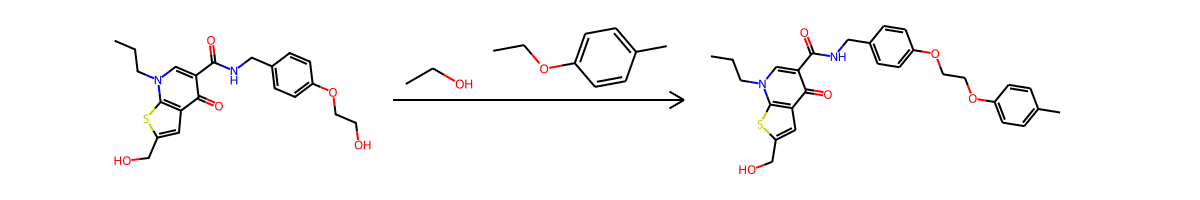

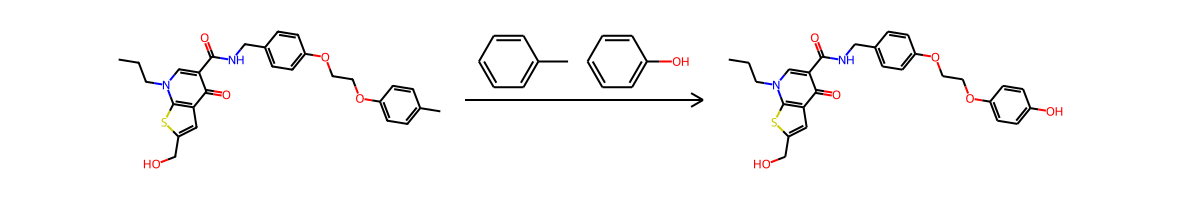

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1586_4_2_2


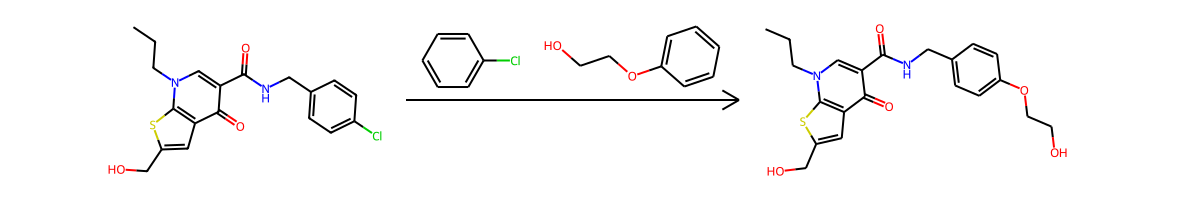

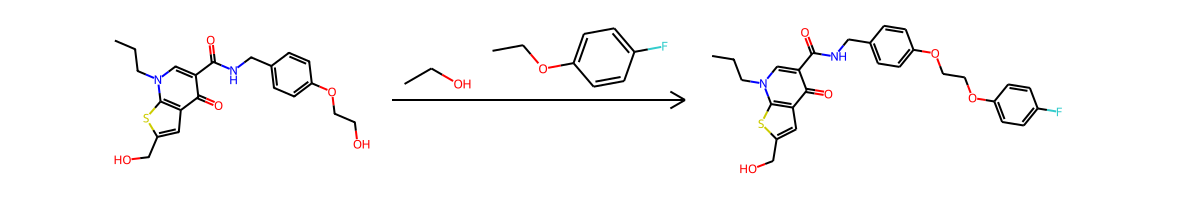

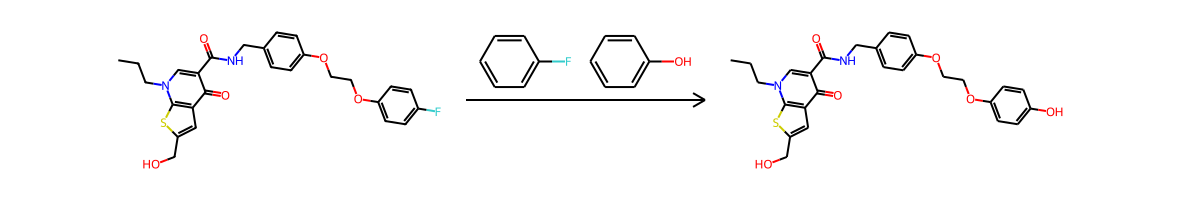

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1586_4_1_1


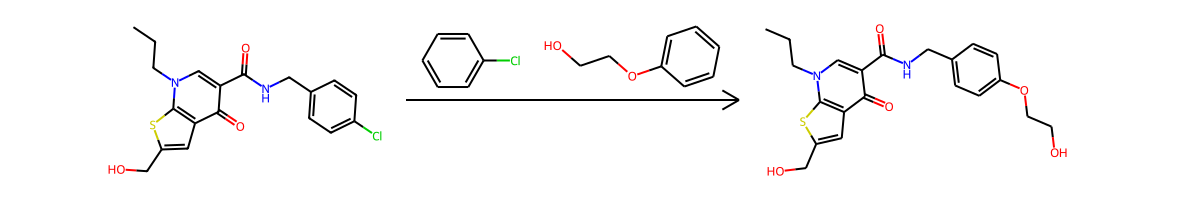

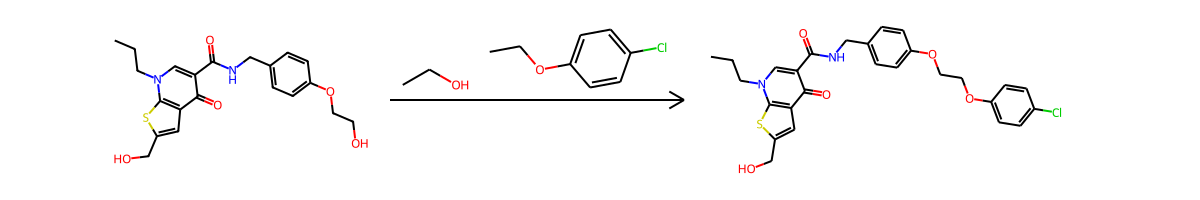

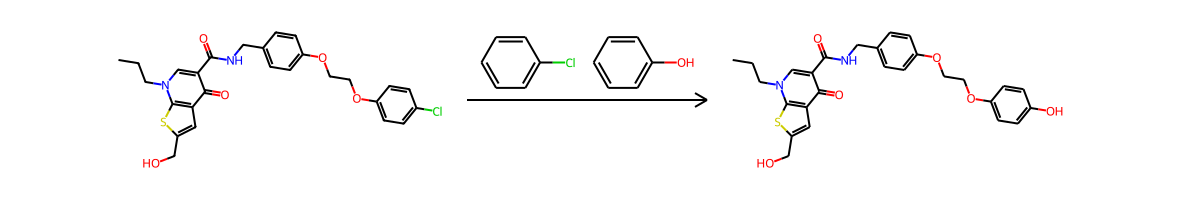

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1586_3_0_1


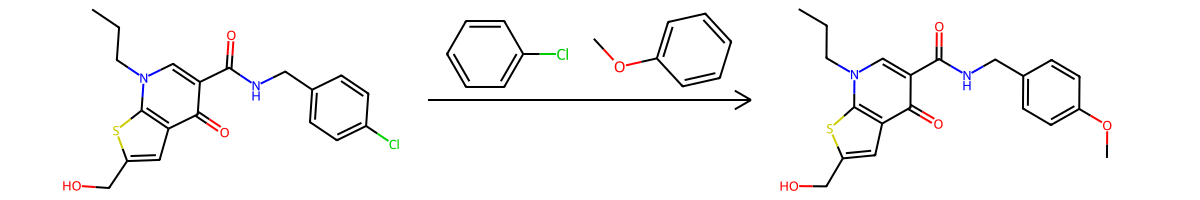

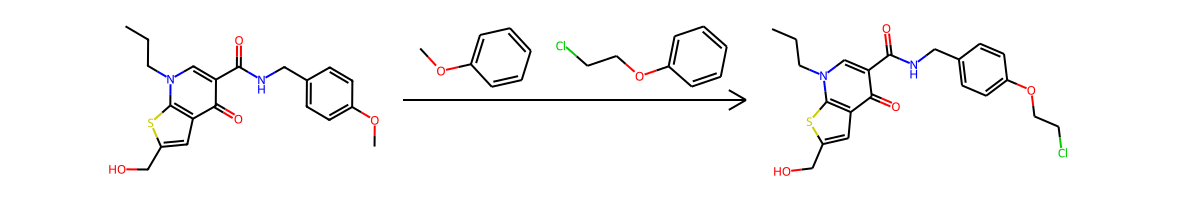

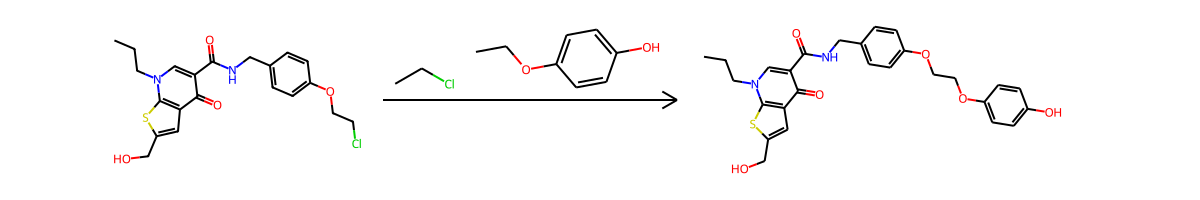

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1586_1_1_2


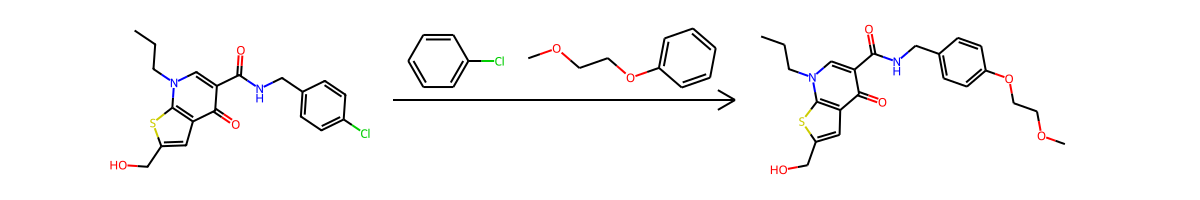

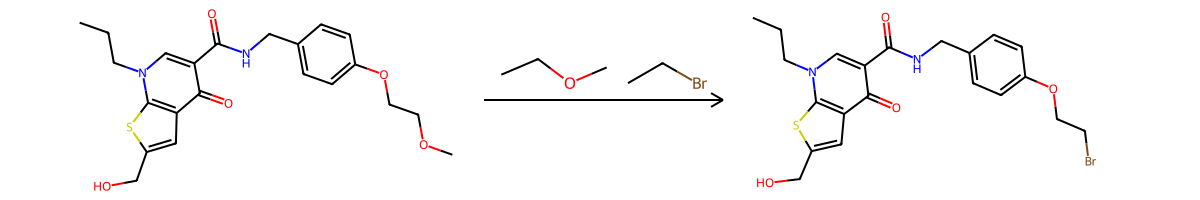

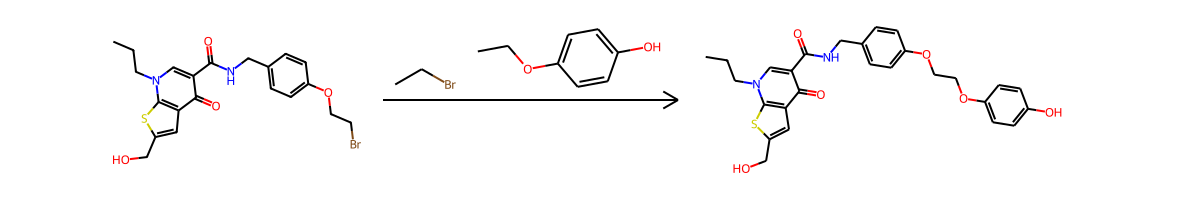

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1672



##############################################################################################################################################################################################
##############################################################################################################################################################################################


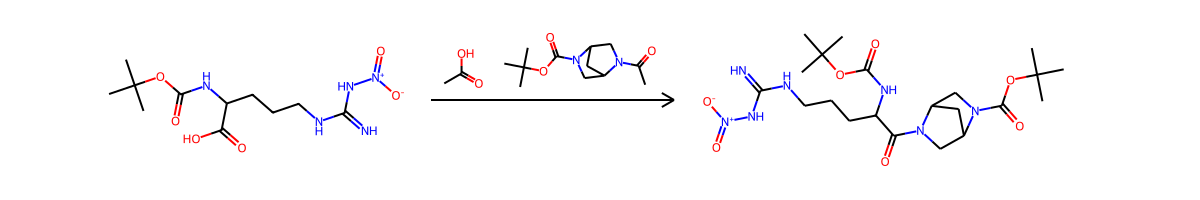

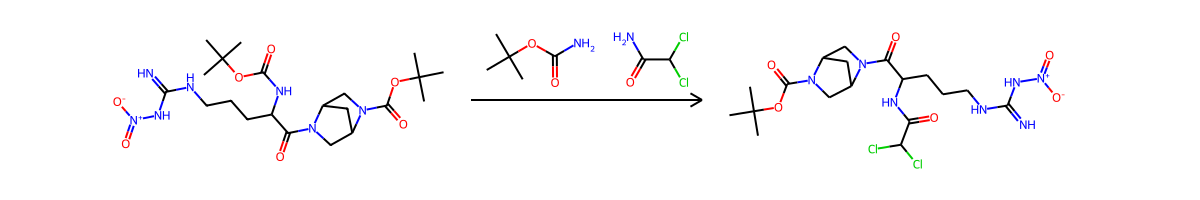

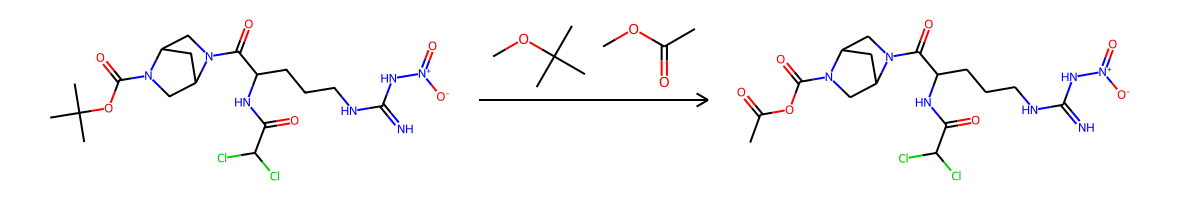

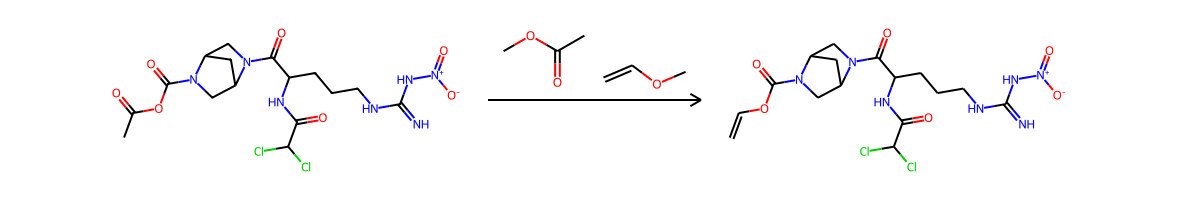

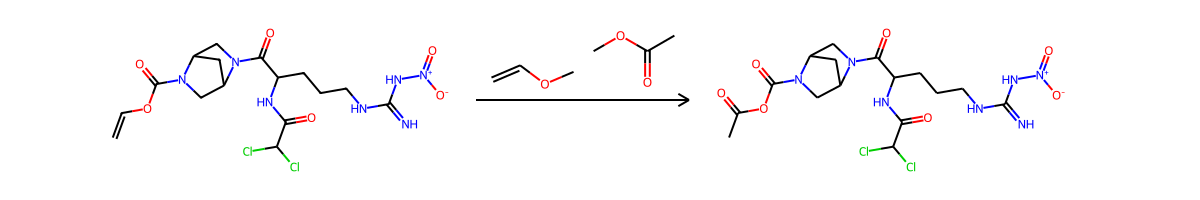

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1672_1_0_0


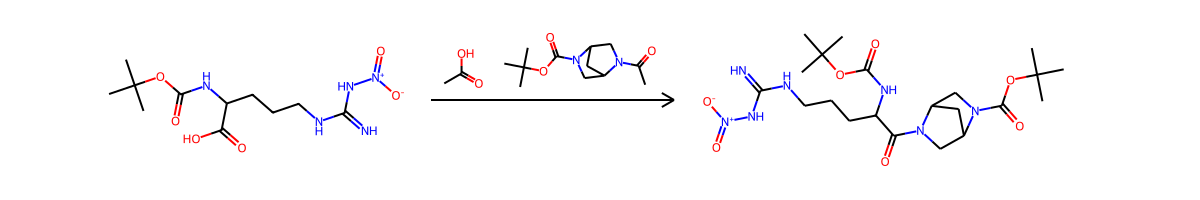

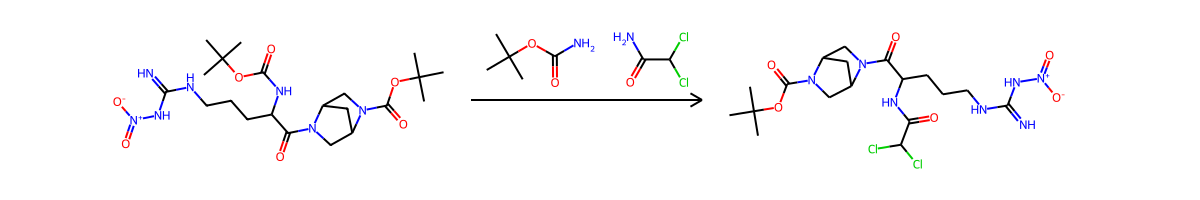

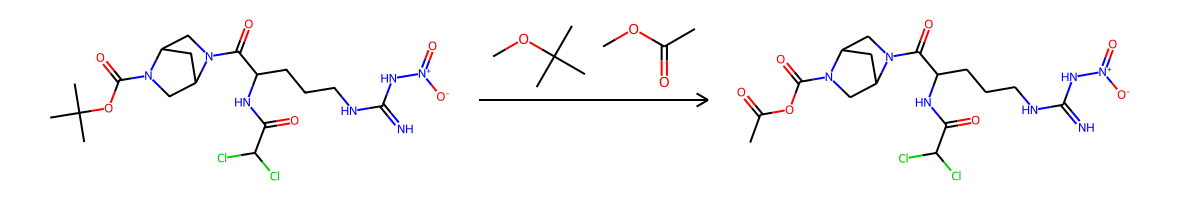

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1747



##############################################################################################################################################################################################
##############################################################################################################################################################################################


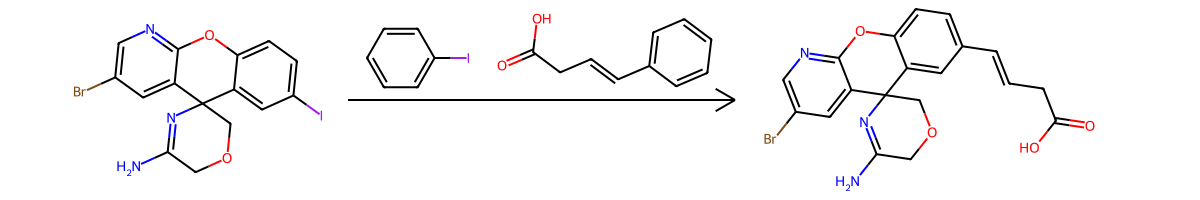

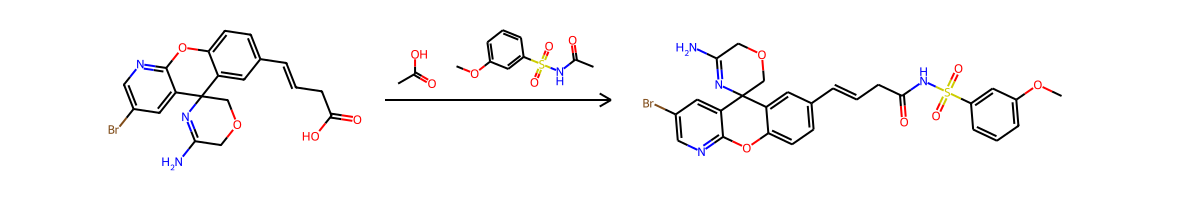

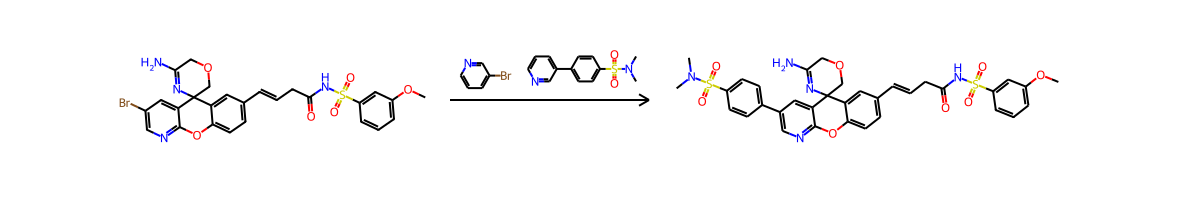

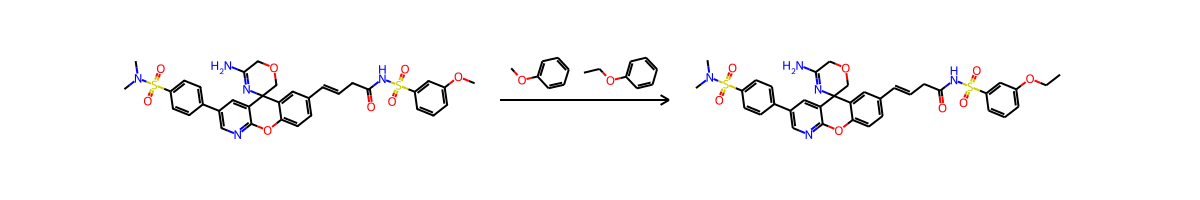

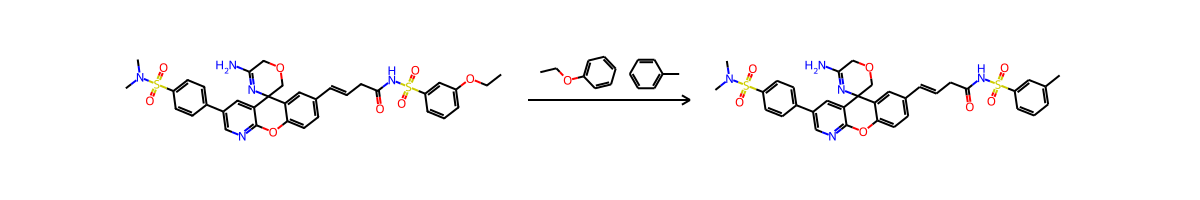

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1747_2_4_6


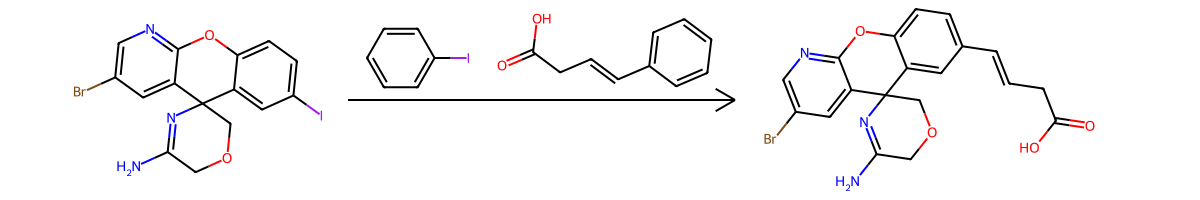

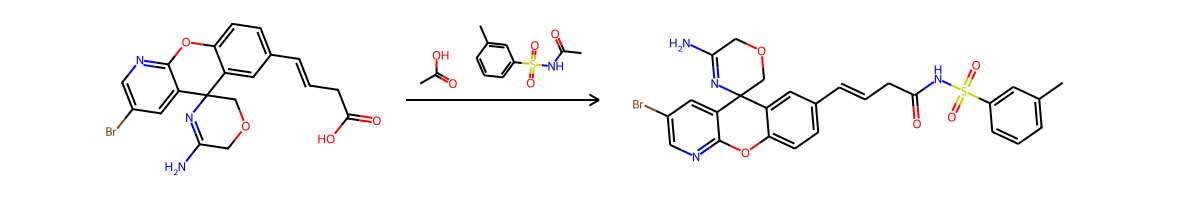

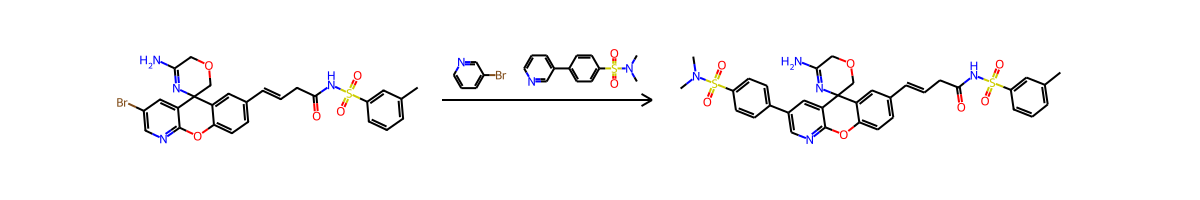

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1813



##############################################################################################################################################################################################
##############################################################################################################################################################################################


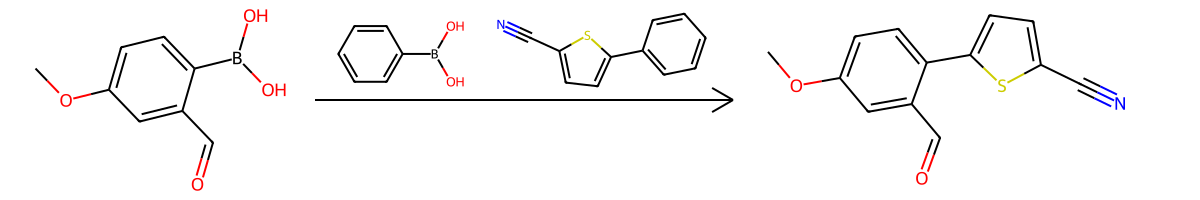

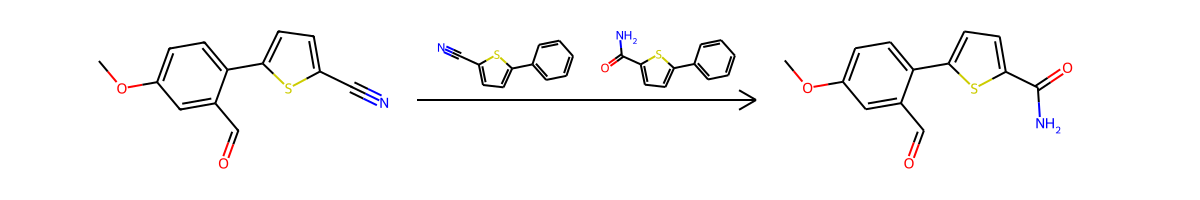

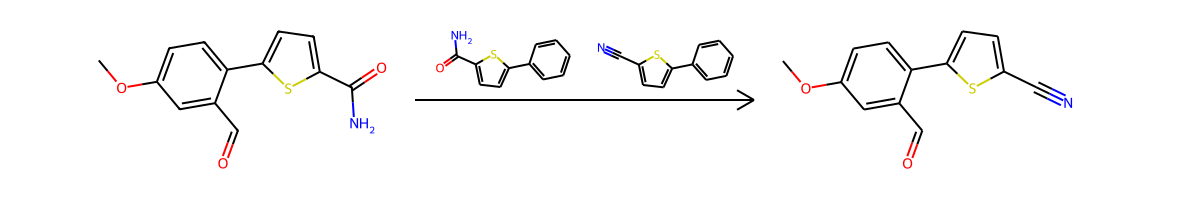

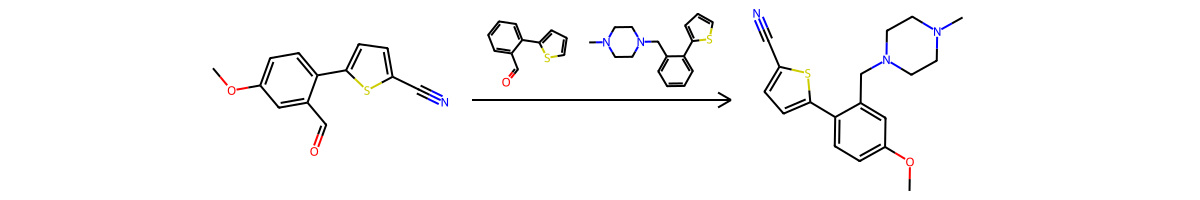

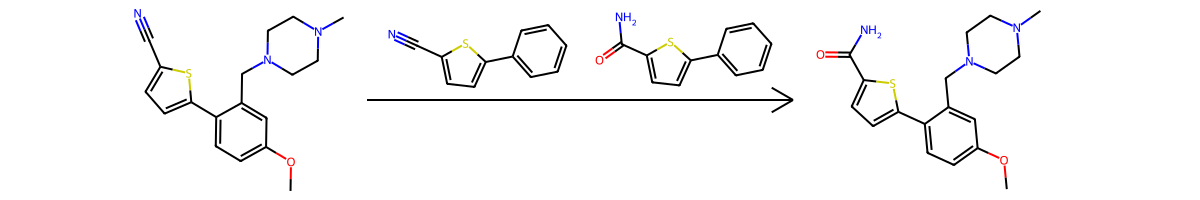

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1813_3_0_0


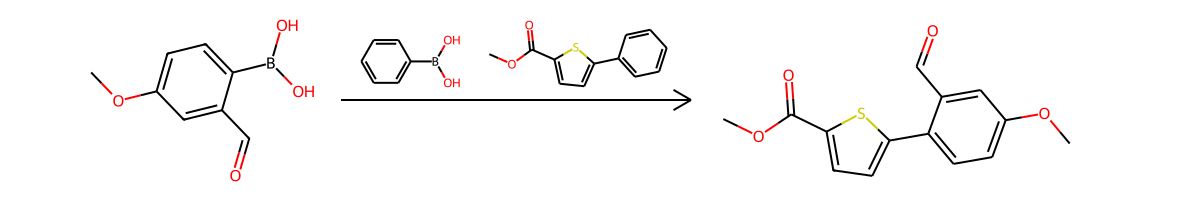

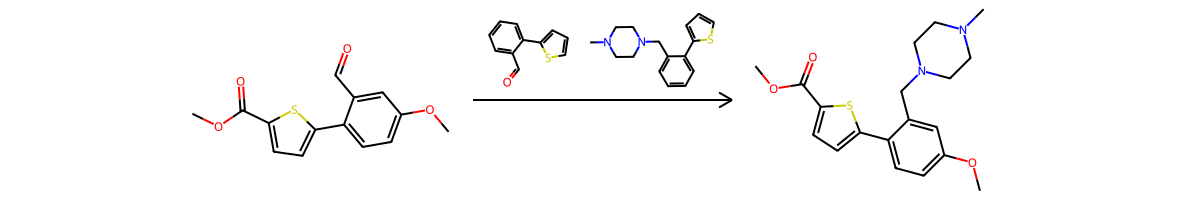

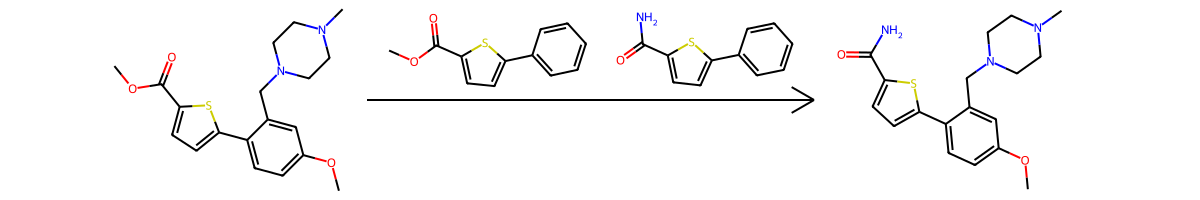

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1813_3_1_0


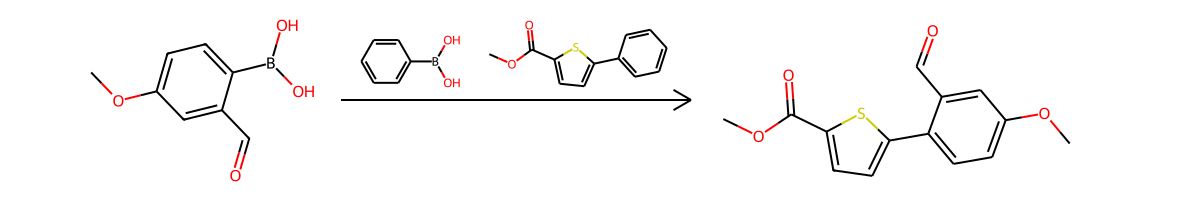

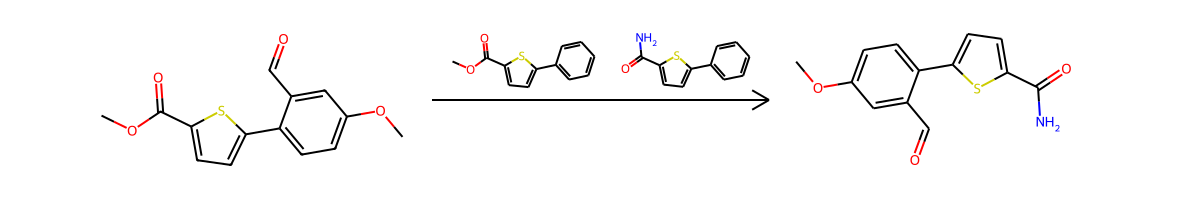

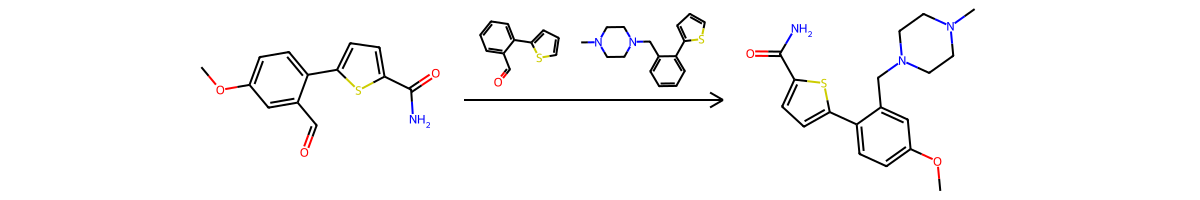

##############################################################################################################################################################################################
##############################################################################################################################################################################################
1989



##############################################################################################################################################################################################
##############################################################################################################################################################################################


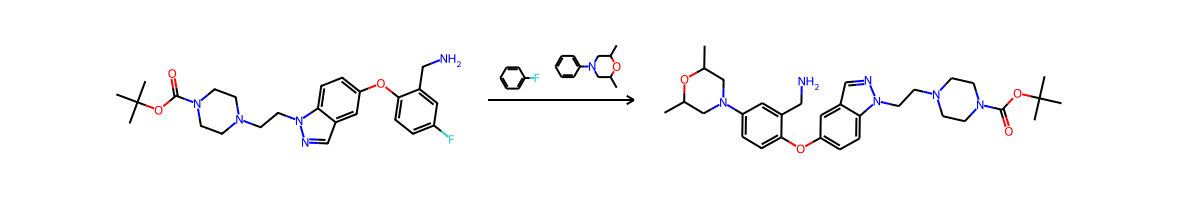

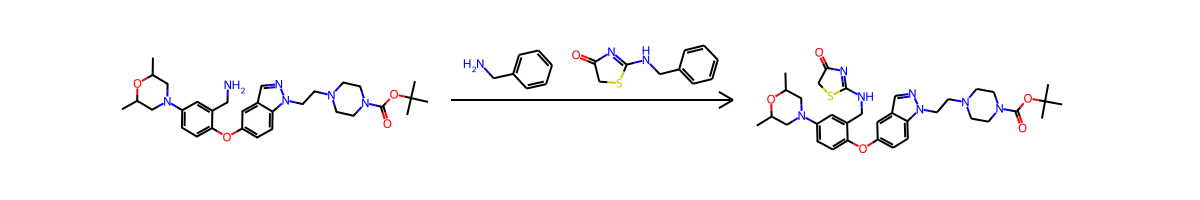

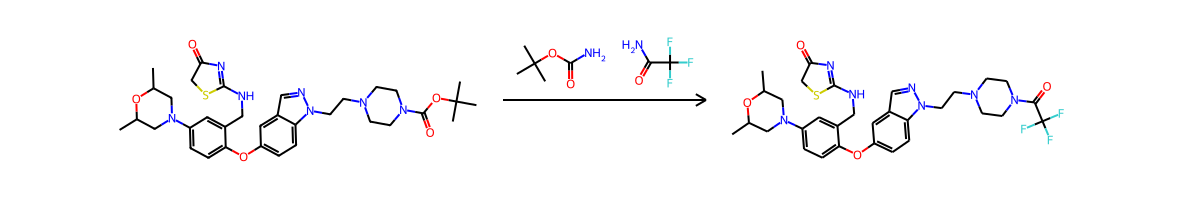

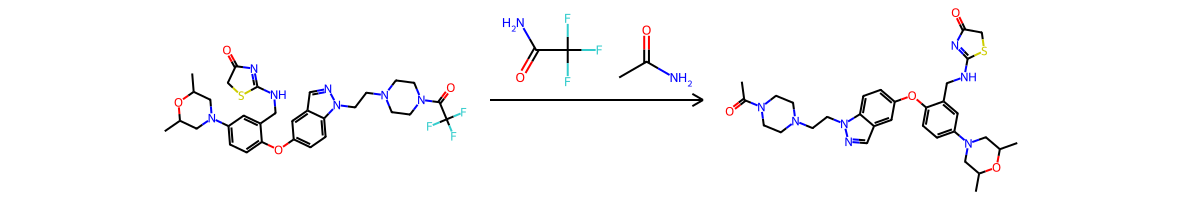

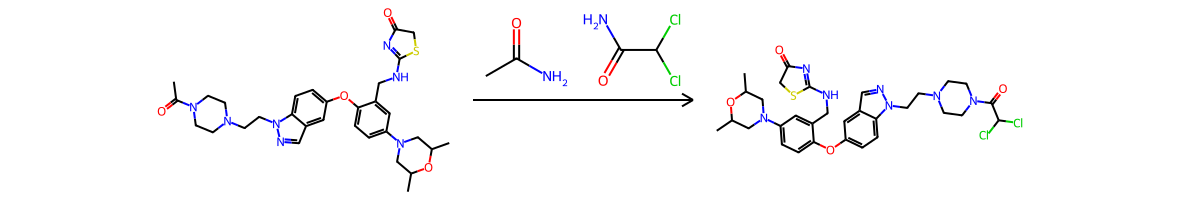

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
1989_1_2_0


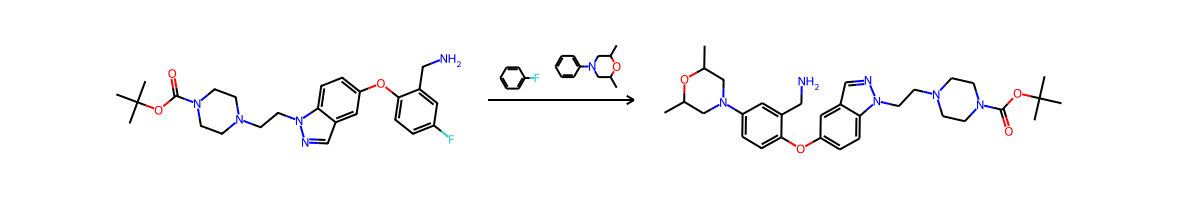

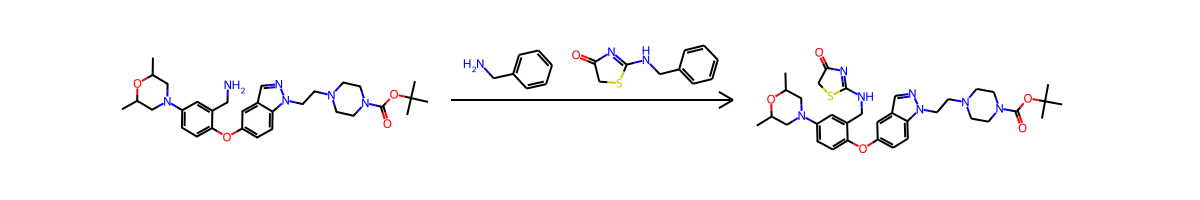

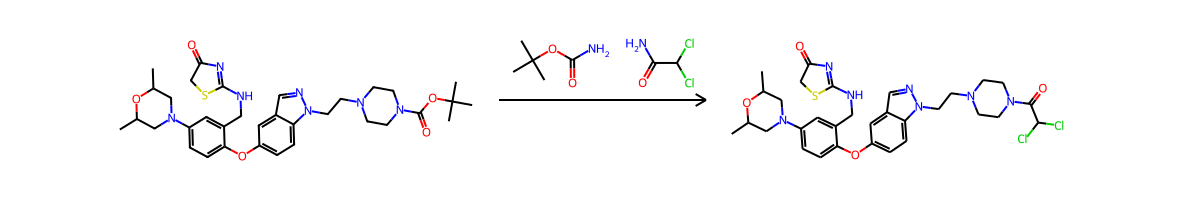

##############################################################################################################################################################################################
##############################################################################################################################################################################################
2028



##############################################################################################################################################################################################
##############################################################################################################################################################################################


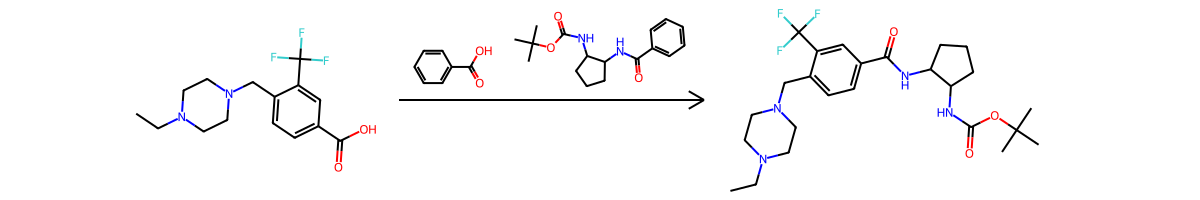

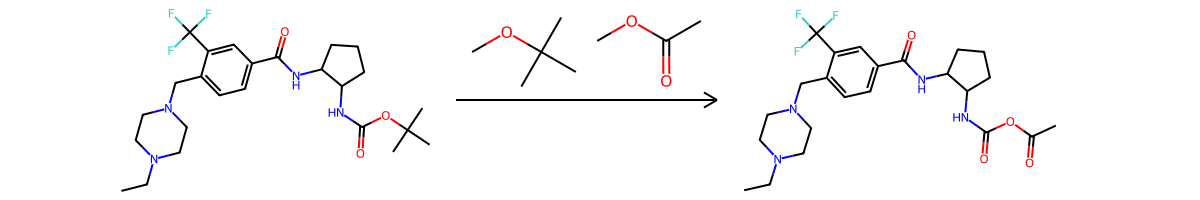

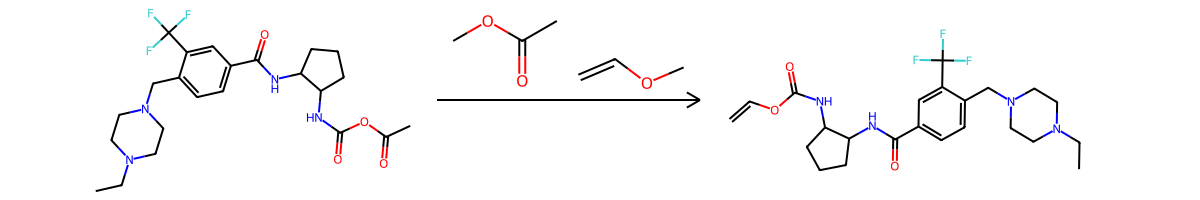

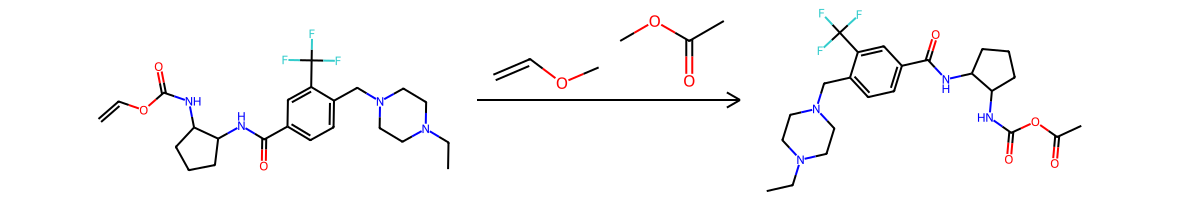

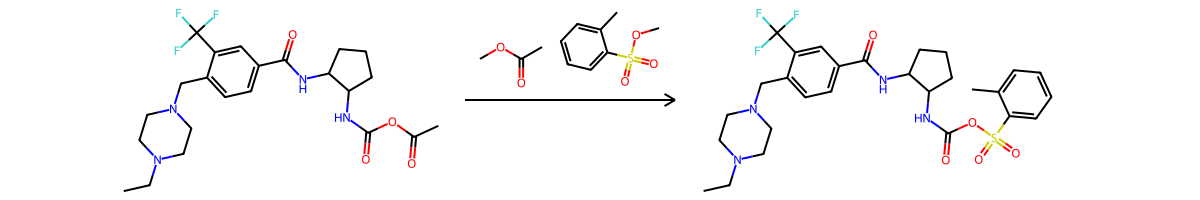

______________________________________________________________________________________________________________________________________________________________________________________________
______________________________________________________________________________________________________________________________________________________________________________________________
2028_3_0_0


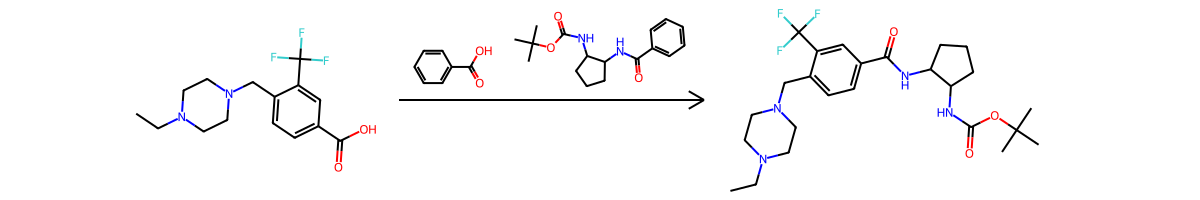

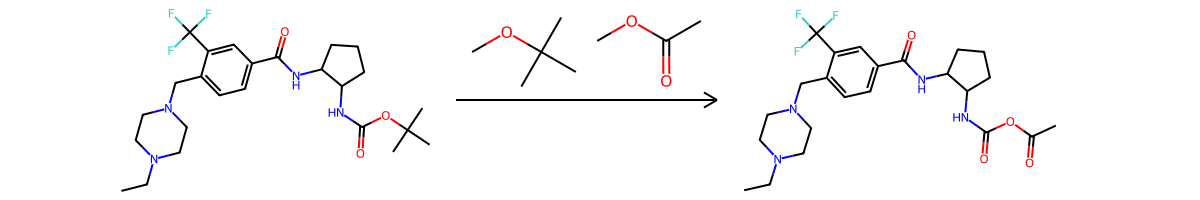

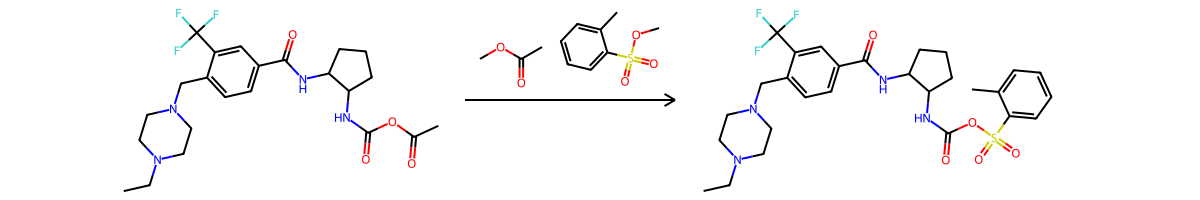

##############################################################################################################################################################################################
##############################################################################################################################################################################################


In [120]:
for idx in sim1_indices:
    print(idx)
# idx = 1053#sim1_indices[3]

    temp_df = test_data_df.iloc[5*idx:5*(idx+1)].copy()
    temp_df.loc[5] = temp_df.iloc[4].copy()
    temp_df.loc[5]["reactant"] = temp_df.iloc[4]["product"]
    print("\n\n")
    print("#"*190)
    print("#"*190)
    for i in range(5):
        reactant = temp_df.iloc[i]["reactant"]
        product = temp_df.iloc[i+1]["reactant"] 
    #     rsub = smiles_without_atom_index(temp_df.iloc[i]["rsub"])
    #     psub = smiles_without_atom_index(temp_df.iloc[i]["psub"])
        rsig = smiles_without_atom_index(temp_df.iloc[i]["rsig"])
        psig = smiles_without_atom_index(temp_df.iloc[i]["psig"])
        rxn = AllChem.ReactionFromSmarts(f"{reactant}>{rsig}.{psig}>{product}", useSmiles=True)
        display(Draw.ReactionToImage(rxn, (400, 200)))


    key_for_i = all_keys[target_map_for_all_keys == str(idx)]
    ultimate_key = key_for_i[np.vectorize(sim_dict.get)(key_for_i) == 1]

    for ult in ultimate_key:
        print("_"*190)
        print("_"*190)
        print(ult)
        splits = ult.split("_")

        for i in range(1, len(splits)):
            reactant = trajectory_dict["_".join(splits[:i])]
            product = trajectory_dict["_".join(splits[:i+1])]
    #             rsig = smiles_without_atom_index(temp_df.iloc[i]["rsig"])
    #             psig = smiles_without_atom_index(temp_df.iloc[i]["psig"])
            sig_calc = Reaction(mfs(reactant), mfs(product))
            sig_calc.calculate_centres_and_signatures()
            rsig, psig = sig_calc.get_smiles_signatures()
            rsig = smiles_without_atom_index(rsig)
            psig = smiles_without_atom_index(psig)
            rxn = AllChem.ReactionFromSmarts(f"{reactant}>{rsig}.{psig}>{product}", useSmiles=True)
            display(Draw.ReactionToImage(rxn, (400, 200)))


    print("#"*190)
    print("#"*190)
    # break